# Workflow to Validate OPERA DISP-S1 Transient Displacement Requirements

**Original code authored by:** NISAR Science Team Members and Affiliates  
**Updated by:** OPERA DISP-S1 CalVal team

*July 2024*

*OPERA DISP-S1 CalVal team*

<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. And all subsequent sections NEED to be run in order.
</div>

<hr/>

## Define CalVal Site 

In [1]:
# Parameters for papermill

site = 'F33039'     # site for DISP-S1 (rame ID)
work_dir = './'
mintpy_dir = 'mintpy_output'    # location of mintpy files 
inputs_dir = 'inputs'           # directory of ifgramStack.h5 inside mintpy_dir
output_dir = 'results'          # location to store output figures and text files
vmin = -50  # vmin/vmax for plotting
vmax = 50

calval_sites_csv = 'validation_data/DISP-S1_CalVal_sites.csv'

time_interval_thr = 12    # time interval threshold: only temporal baselines equal or less than 12 days are considered

# Mask file used for validation
maskFile = 'mask_temporalCoherence.h5' # maskSpatialCoh.h5, inputs/combined_msk.h5

# Define spatial coherence threshold (necessary to reject poor quality, long temporal baseline pairs)
minCoherence_parm = '0.6'
minTempCoherence_parm = '0.6'

#Set GNSS Parameters
gps_completeness_threshold = 0.8    #0.9  #percent of data timespan with valid GNSS epochs
gps_residual_stdev_threshold = 10.  #0.03  #0.03  #max threshold standard deviation of residuals to linear GNSS fit

#variability score threshold
apply_nonlinear_mask = True     # if apply non linear score mask
thr_var_score = 0.3      # variability score threshold

In [2]:
# load packages
import os
from datetime import datetime as dt
from pathlib import Path
import itertools

import copy
import random

import h5py

import numpy as np
import pandas as pd
from scipy import signal
import matplotlib
import matplotlib.colors
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 12})

# multi-processing related packages
import multiprocessing
from itertools import product
from functools import partial
from tqdm import tqdm
import psutil
ncpus = len(psutil.Process().cpu_affinity())    # number of available CPUs
print("number of available CPUs: ", ncpus)

from mintpy.objects import gnss
from mintpy.utils import readfile, utils as ut, utils0 as ut0
from mintpy.cli import view, generate_mask

from solid_utils.sampling import load_geo_utm, samp_pair, euclidean_distance
from solid_utils.plotting import plot_transient_table

import warnings
warnings.filterwarnings("ignore")

number of available CPUs:  128


## Table of Contents:
<a id='secular_TOC'></a>

<hr/>

[**Prep A. Environment Setup**](#transient_prep_a)

[**Prep B. Data Staging**](#transient_prep_b)

[**1. Generate DISP-S1 Stack**](#transient_gen_ifg)
- [1.1.  Crop DISP-S1s](#transient_crop_ifg)

[**2. Optional Corrections**](#transient_opt_correction)
- [2.1. Solid Earth Tides Correction](#transient_solid_earth)
- [2.2. Tropospheric Delay Correction](#transient_tropo_corr)
- [2.3. Topographic Residual Correction ](#transient_tropo_res_corr)

[**3. Make GNSS LOS Measurements**](#transient_gnss_los)
- [3.1. Find Collocated GNSS Stations](#transient_co_gnss)  
- [3.2. Make GNSS LOS Measurements](#transient_gnss_los2) 
- [3.3. Make GNSS and InSAR Relative Displacements](#transient_gnss_insar)

[**4. NISAR Validation Approach 1: GNSS-InSAR Direct Comparison**](#transient_validation1)
- [4.1. Pair up GNSS stations and make measurement residuals](#transient_pair1)
- [4.2. Validate the requirement based on binned measurement residuals](#transient_bin1)
- [4.3. Result visualization](#transient_result1)
- [4.3. Conclusion](#transient_conclusion1)

[**5. NISAR Validation Approach 2: Noise Level Validation**](#transient_validation2)
- [5.1. Randomly sample pixels and pair them up](#transient_pair2)
- [5.2. Validate the requirement based on binned measurement residuals](#transient_bin2)
- [5.3. Result visualization](#transient_result2)
- [5.3. Conclusion](#transient_conclusion2)

[**6. Appendix: GNSS Position Plots**](#transient_appendix)

<hr/>

<a id='transient_prep_a'></a>
## Prep A. Environment Setup
Setup your environment for processing data

In [3]:
################# Set Directories ##########################################
print('\nCurrent directory:', os.getcwd())

if 'work_dir' not in locals():
    work_dir = Path.cwd()

work_dir = os.path.abspath(work_dir)    # absolute path       
print("Work directory:", work_dir)
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)  # Change to Workdir   

mintpy_dir = f'{work_dir}/{mintpy_dir}'     # absolute path of mintpy directory 
if not os.path.isdir(mintpy_dir):
    raise FileNotFoundError(f"The folder '{mintpy_dir}' does not exist.")
print("   MintPy  dir:", mintpy_dir)

inputs_dir = f'{mintpy_dir}/{inputs_dir}'     # absolute path of mintpy directory 
if not os.path.isdir(inputs_dir):
    raise FileNotFoundError(f"The folder '{inputs_dir}' does not exist.")
print("   inputs  dir:", inputs_dir)

output_dir = f'{work_dir}/{output_dir}'     # absolute path of output directory
os.makedirs(output_dir, exist_ok=True)
print("   output  dir:", output_dir)

############################################################################
### List of OPERA DISP-S1 Cal/Val Sites for secular requirements:
if os.path.exists(calval_sites_csv):
    sites_df = pd.read_csv(calval_sites_csv) 
else:
    raise FileNotFoundError(f"The file {calval_sites_csv} does not exist.")  

display(sites_df)

available_sites = sites_df['site'].values


Current directory: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039
Work directory: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039
   MintPy  dir: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output
   inputs  dir: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/inputs
   output  dir: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/results


site     calval_location   reference_lalo gps_ref_site_name priority
0  F08882             Houston   29.692 -95.635              ALEF     high
1  F11115  Central California  37.104 -121.651              P217     high
2  F11116  Central California  36.612 -121.064              P249     high
3  F12640             Florida   29.056 -81.263              DLND     high
4  F18903            Rosamond  35.039 -118.006              P579     high
5  F28486            Oklahoma   34.133 -99.283              TXVE     high
6  F33039              Hawaii  19.450 -155.525              ELEP     high
7  F33065       Unimak Island  54.831 -163.781              AV38     high
8  F36542  Central California  36.516 -120.853              P286     high
9  F42779              Alaska  61.550 -149.327              STEM     high

In [4]:
# specify GNSS source for validation

gnss_source = 'UNR'
print(f'Searching for all GNSS stations from source: {gnss_source}')
print(f'May use any of the following supported sources: {gnss.GNSS_SOURCES}')
GNSS = gnss.get_gnss_class(gnss_source)

Searching for all GNSS stations from source: UNR
May use any of the following supported sources: ['UNR', 'ESESES', 'JPL-SIDESHOW', 'GENERIC']


In [5]:
#Set Global Plot Parameters
ifgs_file = f'{inputs_dir}/ifgramStack.h5'
geom_file = f'{mintpy_dir}/geometryGeo.h5'

if os.path.exists(ifgs_file) and os.path.exists(geom_file):
    print(f'{ifgs_file} and {geom_file} exist and we can continue this validation.')
else:
    raise FileNotFoundError(f"The {ifgs_file} and/or {geom_file} do not exist and are required for this validation.")

# Set path to mask file
msk_file = os.path.join(mintpy_dir, maskFile) 

if site not in available_sites:
    msg = '\nSelected site not available! Please select one of the following sites:: \n{}'.format(available_sites)
    raise Exception(msg)
else:
    print('\nSelected site: {}'.format(site))
    display(sites_df[sites_df['site'] == site])

os.chdir(mintpy_dir)  # move to MintPy directory 

/lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/inputs/ifgramStack.h5 and /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/geometryGeo.h5 exist and we can continue this validation.

Selected site: F33039


site calval_location   reference_lalo gps_ref_site_name priority
6  F33039          Hawaii  19.450 -155.525              ELEP     high

run view.py in MintPy version 1.6.0.post11, date 2024-06-25
input file is mask file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/mask_temporalCoherence.h5 in bool format
file size in y/x: (7870, 9525)
input dataset: "['mask']"
num of datasets in file mask_temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']
data   coverage in y/x: (0, 0, 9525, 7870)
subset coverage in y/x: (0, 0, 9525, 7870)
data   coverage in lat/lon: (72930.0, 2326890.0, 358680.0, 2090790.0)
subset coverage in lat/lon: (72930.0, 2326890.0, 358680.0, 2090790.0)
------------------------------------------------------------------------
colormap: jet
figure title: mask_temporalCoherence
figure size : [9.1, 6.0]
reading data ...
data has uniform and limited number (2 <= 20) of unique values --> discretize colormap
data    range: [False, True] 1
display range: [-0.5, 1.5] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image

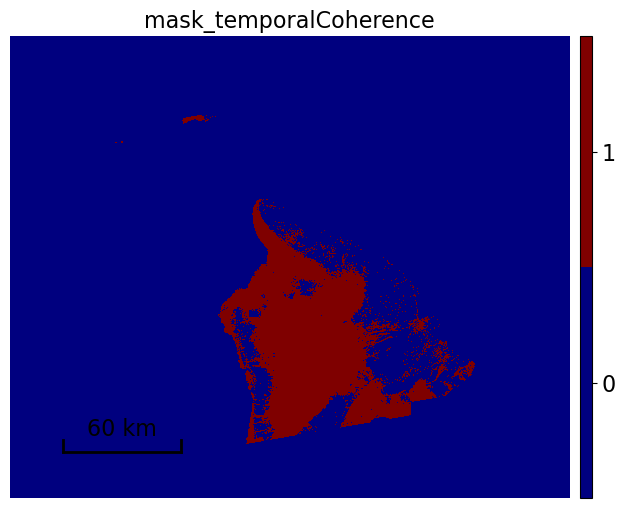

In [6]:
if not os.path.exists(msk_file):

    if (os.path.basename(msk_file) == 'maskSpatialCoh.h5'):

        if not os.path.exists('avgSpatialCoh.h5'):
            raise FileNotFoundError("cannot find avgSpatialCoh.h5")
        
        view.main(f'avgSpatialCoh.h5 --noaxis --noverbose'.split()) # average spatial coherence

        iargs = [f'avgSpatialCoh.h5', '-m', minCoherence_parm, '-o', maskFile]
        generate_mask.main(iargs)

    elif (os.path.basename(msk_file) == 'mask_temporalCoherence.h5'):

        if not os.path.exists('inputs/temporalCoherence.h5'):
            raise FileNotFoundError("cannot find inputs/temporalCoherence.h5")
        
        view.main(f'inputs/temporalCoherence.h5 --noaxis --noverbose'.split()) # average spatial coherence

        iargs = [f'inputs/temporalCoherence.h5', '-m', minTempCoherence_parm, '-o', maskFile]
        generate_mask.main(iargs)

    else:
        raise FileNotFoundError(f"The maskfile {msk_file} not found.")

# view mask
view.main([msk_file, 'mask', '--noaxis'])

mask_lyr, _ = readfile.read(msk_file)    # reading maskfile

In [7]:
# reading area of DISP-S1
disp_S1_metadata = readfile.read_attribute(ifgs_file)

assert 'UTM_ZONE' in disp_S1_metadata.keys()  # make sure data in UTM zone

DISP_region = list(ut.four_corners(disp_S1_metadata))

geo_S, geo_W = ut0.utm2latlon(disp_S1_metadata, DISP_region[2], DISP_region[0])
geo_N, geo_E = ut0.utm2latlon(disp_S1_metadata, DISP_region[3], DISP_region[1])
DISP_region_geo = (geo_S, geo_N, geo_W, geo_E)

print(f'region of DISP-S1 (UTM): {DISP_region}, Zone: {disp_S1_metadata["UTM_ZONE"]}')
print('region of DISP-S1 (lat/lon): ', DISP_region_geo)

wavelength = float(disp_S1_metadata['WAVELENGTH'])
global phase2range
phase2range = wavelength/(4*np.pi)

region of DISP-S1 (UTM): [2090790.0, 2326890.0, 72930.0, 358680.0], Zone: 05N
region of DISP-S1 (lat/lon):  (18.865105209397647, 21.037409220934865, -157.05172935959655, -154.36002063342457)


In [8]:
# # Instead of bringing all data into memory, we will read files when needed.    
def read_ifgram_hdf(hdf_file, keyword, channel=None, coh_thr=None):
    valid_keywords = ['coherence', 'date', 'unwrapPhase']
    if keyword not in valid_keywords:
        raise KeyError(f"Keyword '{keyword}' not found in the {hdf_file} file. Valid keywords are {valid_keywords}")

    with h5py.File(hdf_file, 'r') as f:
        if keyword == 'date':
            return f[keyword][()]

        data = f[keyword]
        num_ifgs, *_ = data.shape

        if channel is not None and channel >= num_ifgs:
            raise ValueError(f"Input channel {channel} exceeds the number of possible ifgrams ({num_ifgs})")

        output = data[channel] if channel is not None else data[:]

        if keyword == 'unwrapPhase' and coh_thr is not None:
            coh_data = f['coherence']
            coh = coh_data[channel] if channel is not None else coh_data[:]
            output[coh < float(coh_thr)] = np.nan

        return output
    
def slice_mask(arr, mask=None, cor_ref=None):
    """
    Mask and process a slice of an array.
    
    Args:
    arr (np.ndarray): Input array to be masked.
    mask (list of np.ndarray, optional): List of mask arrays.
    cor_ref (np.ndarray, optional): Reference array to be subtracted.
    
    Returns:
    np.ndarray: Processed array.
    """
    # Convert to numpy array if not already
    arr = np.asarray(arr)
    
    # Replace zeros with NaN
    arr[arr == 0] = np.nan
    
    # Apply masks if provided
    if mask is not None:
        arr[np.logical_or.reduce([m == 0 for m in mask])] = np.nan
    
    # Subtract reference if provided
    if cor_ref is not None:
        arr -= cor_ref
    
    return arr

Load the date of DISP-S1s into Python:

In [9]:
ifgs_date = read_ifgram_hdf(ifgs_file, 'date')  # all ifgs date in ifgramStack.h5
ifgs_date_dt = [ [dt.strptime(ref_date.decode(), '%Y%m%d'), dt.strptime(sec_date.decode(), '%Y%m%d')] for ref_date, sec_date in ifgs_date]  # ifgs_date in datetime format
ifgs_date_dt = np.array(ifgs_date_dt)   # all valuable ifgs dates will be kept with dates_index

Remove DISP-S1s with time interval larger than 12 days:

In [10]:
dates_index = []    # dates index only to be used for CalVal
dates_filter_flag = True   # if dates are filtered based on time interval of sequential pairs

# DISP-S1 has a single reference date for time-series
assert len(set(ifgs_date[:,0])) == 1     # The DISP-S1 should have a single reference date.

if dates_filter_flag:
    # filtered by time interval threshold
    for ii, (ref_date, sec_date) in enumerate(ifgs_date_dt):

        if (ii==0):
            delta_day = (sec_date-ref_date).days
            prev_sec_date = sec_date
        else:
            delta_day = (sec_date-prev_sec_date).days
            prev_sec_date = sec_date

        if delta_day <= time_interval_thr:
            dates_index.append(ii)
else:
    dates_index = list(range(len(ifgs_date_dt)))        # all data used for validation

# printing which pair will be used for validation
print(f'Number of pairs to be used for validation: {len(dates_index)}')
print('Pairs to be used for validation')
for ii in dates_index:
    print(ifgs_date_dt[ii,0].strftime('%Y%m%d'), ifgs_date_dt[ii,1].strftime('%Y%m%d'))

Number of pairs to be used for validation: 251
Pairs to be used for validation
20160711 20160723
20160711 20160804
20160711 20160816
20160711 20160921
20160711 20161003
20160711 20161015
20160711 20161027
20160711 20161108
20160711 20161114
20160711 20161120
20160711 20161202
20160711 20161214
20160711 20161226
20160711 20170107
20160711 20170212
20160711 20170224
20160711 20170308
20160711 20170320
20160711 20170401
20160711 20170501
20160711 20170507
20160711 20170519
20160711 20170525
20160711 20170531
20160711 20170606
20160711 20170612
20160711 20170618
20160711 20170624
20160711 20170630
20160711 20170706
20160711 20170712
20160711 20170718
20160711 20170724
20160711 20170730
20160711 20170805
20160711 20170811
20160711 20170817
20160711 20170823
20160711 20170829
20160711 20170904
20160711 20170910
20160711 20170916
20160711 20170922
20160711 20170928
20160711 20171004
20160711 20171010
20160711 20171016
20160711 20171022
20160711 20171028
20160711 20171103
20160711 20171109
201

- `disp_S1_metadata`: metadata of DISP-S1 stacks, including incident angle, longitude and latitude step width, etc
- `dates_index`: indices used for further CalVal excluding pairs not meeting temporal baseline thresholds or minimum GNSS observations
- `ifgs_date_dt`: list of DISP-S1 dates in datetime format used for CalVal along with `dates_index`

### Applying nonlinear-displacement mask

mask_nonDispScore.h5 already exists.


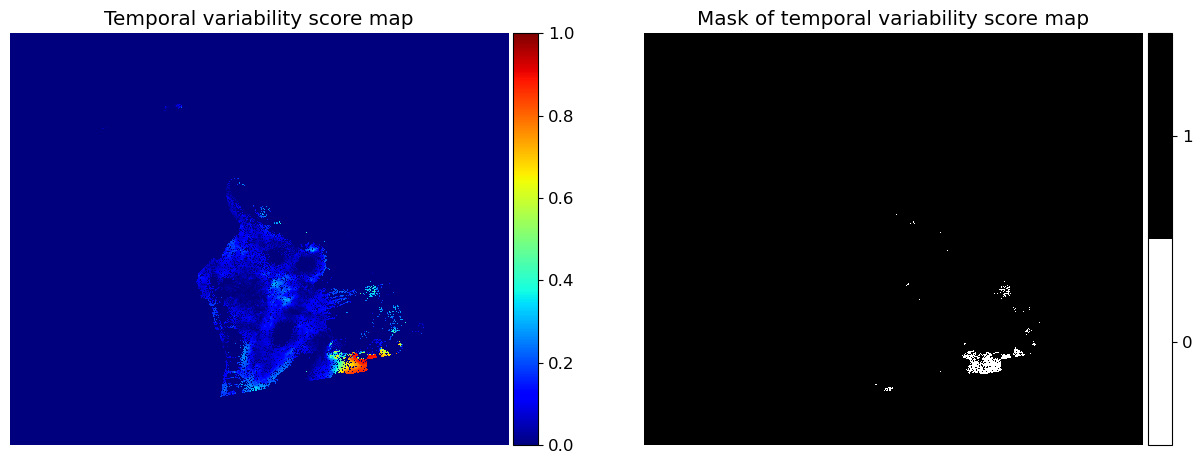

In [11]:
score_map_file = 'nonDispScore.h5'
score_map_file = os.path.join(mintpy_dir, score_map_file)

if apply_nonlinear_mask:

    variability_scores = readfile.read(score_map_file)[0]
    mask_var_score = variability_scores < thr_var_score     # selecting pixels with small temporal variability score

    mask_score_map_file = 'mask_nonDispScore.h5'
    if os.path.exists(mask_score_map_file):
        print(f'{mask_score_map_file} already exists.')
    else:
        print(f'Creating {mask_score_map_file} mask file')
        iargs = [f'{score_map_file}', '-M', str(thr_var_score), '-o', mask_score_map_file]
        generate_mask.main(iargs)       

    mask_var_score, _ = readfile.read(mask_score_map_file)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

    im1 = ax1.imshow(variability_scores, cmap='jet', vmin=0, vmax=1, interpolation='none')
    ax1.axis('off')
    ax1.set_title('Temporal variability score map')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax)

    cmap_bw = matplotlib.colors.ListedColormap(['white', 'black'])
    im2 = ax2.imshow(mask_var_score, cmap_bw, interpolation='none')
    ax2.axis('off')
    ax2.set_title('Mask of temporal variability score map')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im2, cax=cax)
    cbar.set_ticks([0.25, 0.75])    # Set tick locations to the center of each color range
    cbar.set_ticklabels(['0', '1'])     # Set tick labels

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cax.axis('off')

<a id='transient_gnss_los'></a>
# Make GNSS LOS Measurements

<a id='transient_co_gnss'></a>
## Find Collocated GNSS Stations
The project will have access to L2 position data for continuous GNSS stations in third-party networks such NSF’s Plate Boundary Observatory, the HVO network for Hawaii, GEONET-Japan, and GEONET-New Zealand, located in target regions for NISAR solid earth calval. Station data will be post-processed by one or more analysis centers, will be freely available, and will have latencies of several days to weeks, as is the case with positions currently produced by the NSF’s GAGE Facility and separately by the University of Nevada Reno. Networks will contain one or more areas of high-density station coverage (2~20 km nominal station spacing over 100 x 100 km or more) to support validation of L2 NISAR requirements at a wide range of length scales.

Get space and time range for searching GNSS station: 

In [12]:
# get analysis metadata from DISP-S1 stack
start_date = ifgs_date_dt[dates_index[0],0].strftime('%Y%m%d')
end_date = ifgs_date_dt[dates_index[-1],1].strftime('%Y%m%d')

start_date_gnss = ifgs_date_dt[dates_index[0],0]
end_date_gnss = ifgs_date_dt[dates_index[-1],1]

geom_file = os.path.join(mintpy_dir, 'geometryGeo.h5')
inc_angle = readfile.read(geom_file, datasetName='incidenceAngle')[0]
inc_angle = np.nanmean(inc_angle)
az_angle = readfile.read(geom_file, datasetName='azimuthAngle')[0]
az_angle = np.nanmean(az_angle)

# search for collocated GNSS stations
site_names, site_lats_wgs84, site_lons_wgs84 = gnss.search_gnss(SNWE=DISP_region_geo,
                                                                start_date=start_date,
                                                                end_date=end_date,
                                                                source=gnss_source)
# post-query: convert lat/lon to UTM for plotting
site_north, site_east = ut0.latlon2utm(disp_S1_metadata, site_lats_wgs84, site_lons_wgs84)

site_names = [str(stn) for stn in site_names]
print("Initial list of {} stations used in analysis:".format(len(site_names)))
print(site_names)

load 22009 GNSS sites with fields: site lat lon start_date end_date num_solution
keep sites within SNWE of (18.865105209397647, 21.037409220934865, -157.05172935959655, -154.36002063342457): [104]
keep sites with end_date >= 20160711: [90]
keep sites with start_date <= 20210428: [76]
keep sites with # of solutions >= 50: [76]
['AHUP' 'AINP' 'ALAL' 'ALEP' 'ANIP' 'APNT' 'BLBP' 'BYRL' 'CALM' 'CHRS'
 'CLSO' 'CNPK' 'CRIM' 'DVLT' 'ELEP' 'EPLA' 'ERL2' 'ERZ3' 'GOPM' 'HAL1'
 'HILR' 'HLNA' 'HOLE' 'JCUZ' 'JOKA' 'KAEP' 'KAMO' 'KANE' 'KAON' 'KEAW'
 'KFAP' 'KHKU' 'KNDS' 'KNNE' 'KOSM' 'KTPM' 'KULE' 'MAHU' 'MALU' 'MANE'
 'MAO0' 'MAUI' 'MKAI' 'MKEA' 'MLCC' 'MLES' 'MLO1' 'MLPR' 'MLRD' 'MLSP'
 'MMAU' 'MOKP' 'NANW' 'NIHO' 'NPIT' 'NPOC' 'NUPM' 'OKIT' 'OUTL' 'PAT3'
 'PG2R' 'PHAN' 'PIIK' 'PMAU' 'PUH2' 'PUHI' 'PUKA' 'PUOC' 'RADF' 'SLPC'
 'STEP' 'TOUO' 'UPO5' 'UPO6' 'UWEV' 'YEEP']
Initial list of 76 stations used in analysis:
['AHUP', 'AINP', 'ALAL', 'ALEP', 'ANIP', 'APNT', 'BLBP', 'BYRL', 'CALM', 'CHRS', 'CLS

<a id='transient_gnss_los2'></a>
## Make GNSS LOS Measurements

In this step, the 3-D GNSS observations are projected into LOS direction. The DISP-S1 measurements are averaged 3 by 3 near the station positions.

In [13]:
# get daily position solutions for GNSS stations
use_stn = []  #stations to keep
bad_stn = []  #stations to toss
use_north = [] 
use_east = []
# track latlon coordinates for UTM grids
use_lats_keepwgs84 = [] 
use_lons_keepwgs84 = []

for counter, stn in enumerate(site_names):
    gps_obj = GNSS(site = stn,
                   data_dir = os.path.join(mintpy_dir,f'GNSS-{gnss_source}'))
    gps_obj.open(print_msg=False)
    
    # count number of dates in time range
    dates = gps_obj.dates
    range_days = (end_date_gnss - start_date_gnss).days
    gnss_count = np.histogram(dates, bins=[start_date_gnss, end_date_gnss])
    gnss_count = int(gnss_count[0])
    
    # for this quick screening check of data quality, we use the constant incidence and azimuth angles 
    # get standard deviation of residuals to linear fit
    disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, az_angle)
    disp_detrended = signal.detrend(disp_los)
    stn_stdv = np.std(disp_detrended)
   
    # select GNSS stations based on data completeness and scatter of residuals
    disp_detrended = signal.detrend(disp_los)
    if range_days * gps_completeness_threshold <= gnss_count:
        if (stn_stdv > gps_residual_stdev_threshold):
            bad_stn.append(stn)
        else:
            use_stn.append(stn)
            use_north.append(site_north[counter])
            use_east.append(site_east[counter])
            use_lats_keepwgs84.append(site_lats_wgs84[counter])
            use_lons_keepwgs84.append(site_lons_wgs84[counter])
    else:
        bad_stn.append(stn)

site_names = use_stn
site_north = use_north
site_east = use_east
site_lats_wgs84 = use_lats_keepwgs84
site_lons_wgs84 = use_lons_keepwgs84

# [optional] manually remove additional stations
gnss_to_remove=[]

for i, gnss_site in enumerate(gnss_to_remove):
    if gnss_site in site_names:
        site_names.remove(gnss_site)
    if gnss_site not in bad_stn:
        bad_stn.append(gnss_site)

print("\nFinal list of {} stations used in analysis:".format(len(site_names)))
print(site_names)
print("List of {} stations removed from analysis".format(len(bad_stn)))
print(bad_stn)


Final list of 52 stations used in analysis:
['AHUP', 'AINP', 'ALAL', 'ALEP', 'ANIP', 'APNT', 'BLBP', 'BYRL', 'CNPK', 'CRIM', 'ELEP', 'GOPM', 'HILR', 'HLNA', 'HOLE', 'JCUZ', 'JOKA', 'KAEP', 'KAMO', 'KAON', 'KFAP', 'KHKU', 'KNNE', 'KOSM', 'KTPM', 'KULE', 'MANE', 'MAO0', 'MAUI', 'MKAI', 'MKEA', 'MLCC', 'MLES', 'MLPR', 'MLRD', 'MLSP', 'MMAU', 'MOKP', 'NPOC', 'NUPM', 'OUTL', 'PAT3', 'PHAN', 'PIIK', 'PMAU', 'PUH2', 'PUKA', 'RADF', 'SLPC', 'STEP', 'TOUO', 'UWEV']
List of 24 stations removed from analysis
['CALM', 'CHRS', 'CLSO', 'DVLT', 'EPLA', 'ERL2', 'ERZ3', 'HAL1', 'KANE', 'KEAW', 'KNDS', 'MAHU', 'MALU', 'MLO1', 'NANW', 'NIHO', 'NPIT', 'OKIT', 'PG2R', 'PUHI', 'PUOC', 'UPO5', 'UPO6', 'YEEP']


Get daily position solutions for GNSS stations:

In [14]:
def process_station(args, ifgs_date_dt, mintpy_dir, gnss_source, geom_file, disp_S1_metadata, site_north, site_east, site_lats_wgs84, 
                    site_lons_wgs84, ifgs_file, msk_file, mask_var_score_file=None):
    counter, stn, i = args  # counter is for counting gnss stations / i is index for dates_index

    gps_obj = GNSS(site=stn, data_dir=os.path.join(mintpy_dir, f'GNSS-{gnss_source}'))
    gps_obj.open(print_msg=False)
    
    gps_obj.read_displacement(print_msg=False)
    dates = gps_obj.dates
    
    start_date = ifgs_date_dt[i, 0]     # start date of ith DISP-S1
    end_date = ifgs_date_dt[i, 1]       # end date of ith DISP-S1
    
    range_days = (end_date - start_date).days
    gnss_count = np.histogram(dates, bins=[start_date, end_date])
    gnss_count = int(gnss_count[0])
    
    if range_days == gnss_count - 1:
        _, disp_gnss_time_series, disp_gnss_time_series_std, site_latlon = gps_obj.get_los_displacement(
            str(geom_file),
            start_date=start_date.strftime('%Y%m%d'),
            end_date=end_date.strftime('%Y%m%d'))[:4]
        
        y_value, x_value = ut.coordinate(disp_S1_metadata).geo2radar(site_latlon[0], site_latlon[1])[:2]
        
        stn_north = float(site_north[counter])  # location of gnss stations in UTM coordinates
        stn_east = float(site_east[counter])
        site_NE = [stn_north, stn_east]
        site_latlon = [float(site_lats_wgs84[counter]), float(site_lons_wgs84[counter])]    # location of gnss stations in geographic coordinates
        
        ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=i, coh_thr=minCoherence_parm) * phase2range * 1000  # reading only a corresponding pair for validation
        mask_lyr, _ = readfile.read(msk_file)    # reading maskfile
        if mask_var_score_file is not None:
            mask_var_score, _ = readfile.read(mask_var_score_file)            # to avoid memory error, mask is read from hdf
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score])     # applying masks to a pair
        else:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr])
            
        disp_dat = ifgs_slice[y_value-pixel_radius:y_value+pixel_radius, 
                                x_value-pixel_radius:x_value+pixel_radius]
        
        if np.isfinite(disp_dat).sum() == 0:
            return None
        
        disp_dat = np.nanmean(disp_dat)
        
        disp_gnss_time_series = disp_gnss_time_series * 1000
        disp_gnss_time_series_std = disp_gnss_time_series_std * 1000
        disp_gnss = disp_gnss_time_series[-1] - disp_gnss_time_series[0]
        
        return {
            'gnss_time_series': (i, stn, disp_gnss_time_series),
            'gnss_time_series_std': (i, stn, disp_gnss_time_series_std),
            'displacement': (i, stn, site_NE + site_latlon + [disp_gnss, disp_dat])
        }
    else:
        return {'bad_stn': (i, stn)}

In [15]:
# applying multi-processing to creating dict to compare DISP-S1 and gnss measurements
displacement = {}
gnss_time_series = {}
gnss_time_series_std = {}
bad_stn = {}  #stations to toss

global pixel_radius
pixel_radius = 1

# Create a list of all combinations
all_combinations = list(product(enumerate(site_names), dates_index))
all_args = [(counter, stn, i) for (counter, stn), i in all_combinations]

# Partial function with fixed arguments
process_func = partial(process_station,  
                        ifgs_date_dt=ifgs_date_dt, 
                        mintpy_dir=mintpy_dir, 
                        gnss_source=gnss_source, 
                        geom_file=geom_file, 
                        disp_S1_metadata=disp_S1_metadata, 
                        site_north=site_north, 
                        site_east=site_east, 
                        site_lats_wgs84=site_lats_wgs84, 
                        site_lons_wgs84=site_lons_wgs84, 
                        ifgs_file=ifgs_file, 
                        msk_file=msk_file, 
                        mask_var_score_file=mask_score_map_file)

# Use multiprocessing to parallelize the execution
with multiprocessing.Pool(processes=ncpus) as pool:
    results = list(tqdm(pool.imap(process_func, all_args), total=len(all_args), desc="Processing stations"))

# Process results
for result in results:
    if result is not None:
        if 'gnss_time_series' in result:
            i, stn, value = result['gnss_time_series']
            gnss_time_series[(i, stn)] = value
        if 'gnss_time_series_std' in result:
            i, stn, value = result['gnss_time_series_std']
            gnss_time_series_std[(i, stn)] = value
        if 'displacement' in result:
            i, stn, value = result['displacement']
            displacement[(i, stn)] = value
        if 'bad_stn' in result:
            i, stn = result['bad_stn']
            if i in bad_stn:
                bad_stn[i].append(stn)
            else:
                bad_stn[i] = [stn]

Processing stations: 100%|██████████| 13052/13052 [04:10<00:00, 52.01it/s] 


Do some data structure transformation:

In [16]:
gnss_time_series = dict(sorted(gnss_time_series.items()))
gnss_time_series_std = dict(sorted(gnss_time_series_std.items()))
displacement = dict(sorted(displacement.items()))
bad_stn = dict(sorted(bad_stn.items()))

In [17]:
# In cases cumulative time-series was used, the interval of cumulative time-series is in increments of 6,12,18,
# Such that gnss_time_series has differents length for each pairs, and cannot be converted to pandas table.
# Capture such cases.
try:
    gnss_time_series = pd.DataFrame.from_dict(gnss_time_series)
    gnss_time_series_std = pd.DataFrame.from_dict(gnss_time_series_std)
except ValueError:
    pass

In [18]:
displacement = pd.DataFrame.from_dict(displacement,orient='index',
                                      columns=['north','east','lat','lon','gnss_disp','disp_s1'])
displacement.index = pd.MultiIndex.from_tuples(displacement.index,names=['ifg index','station'])

If there are less than 3 GNSS stations, don't conduct comparison:

In [19]:
drop_index = []
dates_index_gnss = []

for i in displacement.index.get_level_values(0).unique():
    if len(displacement.loc[i]) < 3:
        drop_index.append(i)
    else:
        dates_index_gnss.append(i)

displacement=displacement.drop(drop_index)

All data needed for approach 1:

In [20]:
display(displacement)

north           east        lat         lon  \
ifg index station                                                       
0         AHUP     2.144337e+06  261989.143549  19.379101 -155.266098   
          AINP     2.143904e+06  241815.633528  19.372700 -155.457993   
          ALAL     2.145084e+06  227798.548633  19.381500 -155.591507   
          ALEP     2.162854e+06  222543.522133  19.541201 -155.644104   
          ANIP     2.146530e+06  235619.321241  19.395599 -155.517303   
...                         ...            ...        ...         ...   
220       PUKA     2.158741e+06  239821.053005  19.506399 -155.479004   
          RADF     2.167263e+06  244941.933089  19.584000 -155.431396   
221       MLES     2.154192e+06  232033.060941  19.464300 -155.552505   
          PUKA     2.158741e+06  239821.053005  19.506399 -155.479004   
          RADF     2.167263e+06  244941.933089  19.584000 -155.431396   

                    gnss_disp    disp_s1  
ifg index station                         
0         AHUP      -8.489014  -8.729660  
          AINP      -0.129517  16.254847  
          ALAL       3.783051  20.058474  
          ALEP      -9.319214  24.762331  
          ANIP      -5.862183  10.553190  
...                       ...        ...  
220       PUKA     108.080551  45.714424  
          RADF     128.459717  -0.889659  
221       MLES      78.520386  25.075939  
          PUKA      96.955795  -9.614357  
          RADF     131.045837 -50.384560  

[4181 rows x 6 columns]

**NOTE:** 
- A more general criterion is needed for GNSS station selection. Here the stations with uninterrupted data are selected while, in Secular Requirement Validation, stations are selected by data completeness and standard variation.

<a id='transient_gnss_DISP-S1'></a>
## Make GNSS and DISP-S1 Relative Displacements

Here we randomly select one reference site and make both the GNSS and DISP-S1 measurements relative to that reference to remove a constant offset.

In [21]:
ref_disp_s1 = {}

# reference GNSS stations to GNSS reference site
for i in displacement.index.get_level_values(0).unique():
    gps_ref_site_name = random.choice(displacement.loc[i].index.unique())
    displacement.loc[i,'gnss_disp'] = displacement.loc[i,'gnss_disp'].values - displacement.loc[(i,gps_ref_site_name),'gnss_disp']
    displacement.loc[i,'disp_s1'] = displacement.loc[i,'disp_s1'].values - displacement.loc[(i,gps_ref_site_name),'disp_s1']
    # post-query: convert lat/lon to UTM
    ref_lon = displacement.loc[(i,gps_ref_site_name),'lon']
    ref_lat = displacement.loc[(i,gps_ref_site_name),'lat']
    ref_y_value, ref_x_value = ut.coordinate(disp_S1_metadata).geo2radar(ref_lat, ref_lon)[:2]    # location of reference GNSS station on the image

    ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=i) * phase2range*1000    # unit in mm   
    if apply_nonlinear_mask:
        ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score])
    else:
        ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr])

    _ = ifgs_slice[ref_y_value-pixel_radius:ref_y_value+1+pixel_radius, 
                                ref_x_value-pixel_radius:ref_x_value+1+pixel_radius]
    ref_disp_s1[i] = [float(np.nanmean(_))]

Plot GNSS stations on DISP-S1 displacement fields

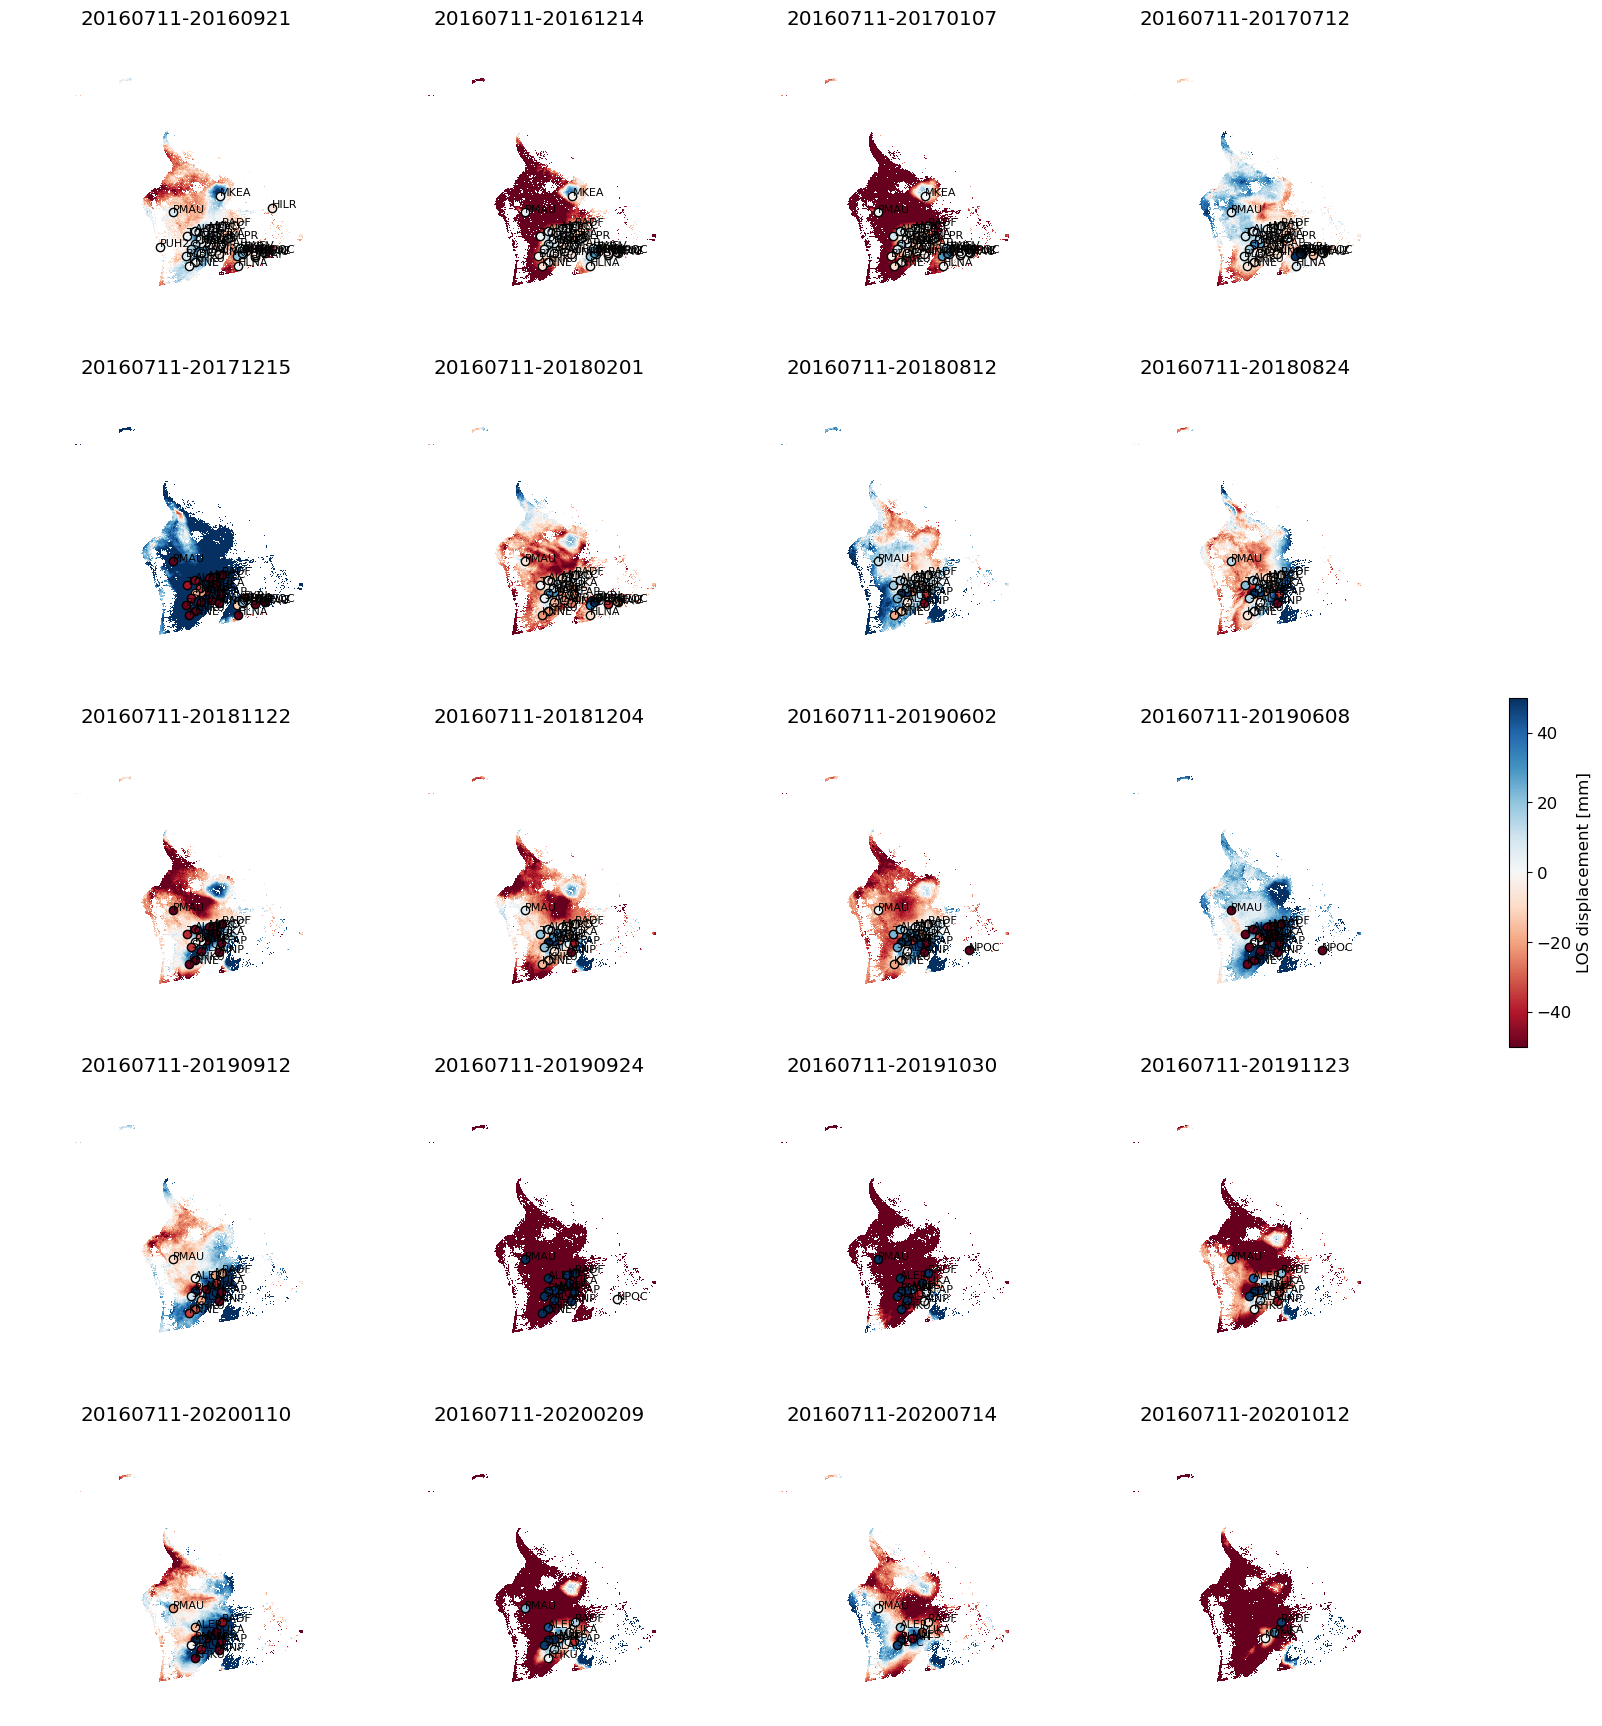

In [22]:
# Plotting only sampled pairs due to a large volume of DISP-S1
cmap = copy.copy(plt.get_cmap('RdBu'))

n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

col_figs = 4    # number of colums in figures
num_pairs_to_plot = 20

if num_pairs_to_plot > n_pairs:
    num_pairs_to_plot = n_pairs

num_figs = int(np.ceil(num_pairs_to_plot/col_figs)) * col_figs

sampled_index = sorted(random.sample(list(displacement.index.get_level_values(0).unique()),num_pairs_to_plot))

fig, ax = plt.subplots(int(np.ceil(num_pairs_to_plot/col_figs)), col_figs, figsize=[18, 18])
axs = ax.ravel()

for counter in range(num_figs):
    if (counter<n_pairs):
        _ind = sampled_index[counter]
        ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=_ind, coh_thr=minCoherence_parm) * phase2range*1000    # unit in mm   
        if apply_nonlinear_mask:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score], cor_ref=ref_disp_s1[_ind])
        else:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr], cor_ref=ref_disp_s1[_ind])

        im = axs[counter].imshow(ifgs_slice, cmap=cmap,vmin=vmin,vmax=vmax, interpolation='nearest', extent=(DISP_region[2],DISP_region[3],DISP_region[0],DISP_region[1]))
        axs[counter].axis('off')
        axs[counter].set_title(ifgs_date_dt[_ind,0].strftime('%Y%m%d')+'-'+ifgs_date_dt[_ind,1].strftime('%Y%m%d'), pad=-14)

        for stn in displacement.loc[_ind].index:
            _east, _north = displacement.loc[(_ind,stn),'east'],displacement.loc[(_ind,stn),'north']

            color = cmap((displacement.loc[(_ind,stn),'gnss_disp']-vmin)/(vmax-vmin))
            axs[counter].scatter(_east,_north,s=6**2,color=color,edgecolors='k')
            axs[counter].annotate(stn,(_east, _north),color='black', fontsize=8)
    else:
        axs[counter].axis('off')

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

cbar = fig.colorbar(im, ax=axs.tolist(), shrink=0.2)
cbar.set_label('LOS displacement [mm]')

out_fig = f'{output_dir}/Transient_DISP-S1_vs_gnss_randomSelected_site{site}.png'
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

In [23]:
separate_figure_flag = False     # if plotting separate figures is needed

if separate_figure_flag:
    cmap = copy.copy(plt.get_cmap('RdBu'))

    n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

    for counter in range(n_pairs):
        fig, ax = plt.subplots(figsize=[12,12])
        _ind = displacement.index.get_level_values(0).unique()[counter]
        ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=_ind, coh_thr=minCoherence_parm) * phase2range*1000    # unit in mm   
        if apply_nonlinear_mask:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score], cor_ref=ref_disp_s1[_ind])
        else:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr], cor_ref=ref_disp_s1[_ind])
        im = ax.imshow(ifgs_slice, cmap=cmap,vmin=vmin,vmax=vmax, interpolation='nearest', extent=(DISP_region[2],DISP_region[3],DISP_region[0],DISP_region[1]))
        ax.axis('off')
        ax.set_title(ifgs_date_dt[_ind,0].strftime('%Y%m%d')+'-'+ifgs_date_dt[_ind,1].strftime('%Y%m%d'), pad=-14)
        
        for stn in displacement.loc[_ind].index:
            _east, _north = displacement.loc[(_ind,stn),'east'],displacement.loc[(_ind,stn),'north']

            color = cmap((displacement.loc[(_ind,stn),'gnss_disp']-vmin)/(vmax-vmin))
            ax.scatter(_east,_north,s=6**2,color=color,edgecolors='k')
            ax.annotate(stn,(_east, _north),color='black', fontsize=8)

        cbar = fig.colorbar(im, shrink=0.2)
        cbar.set_label('LOS displacement [mm]')
        out_fig = f"{output_dir}/Transient_DISP-S1_vs_gnss_site{site}_date{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}.png"
        fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
        plt.close()

<a id='transient_validation1'></a>
# NISAR Validation Approach 1: GNSS-DISP-S1 Direct Comparison

<a id='transient_pair1'></a>
## Pair up GNSS stations and make measurement residuals

We first pair up all GNSS stations and compare the relative measurement from both GNSS and DISP-S1. 

In [24]:
disp_s1 = {}
gnss_disp = {}
ddiff_dist = {}
ddiff_disp = {}
abs_ddiff_disp = {}
for i in displacement.index.get_level_values(0).unique():
    displacement_i = displacement.loc[i]
    disp_s1_i = []
    gnss_disp_i = []
    ddiff_dist_i = []
    ddiff_disp_i = []

    gnss_pairs = list(itertools.combinations(displacement_i.index, 2))        # pick two without repeating

    for sta1, sta2 in gnss_pairs:
            disp_s1_i.append(displacement_i.loc[sta1,'disp_s1']-displacement_i.loc[sta2,'disp_s1'])
            gnss_disp_i.append(displacement_i.loc[sta1,'gnss_disp']-displacement_i.loc[sta2,'gnss_disp'])
            ddiff_disp_i.append(gnss_disp_i[-1]-disp_s1_i[-1])

            distance = euclidean_distance(displacement_i.loc[sta1,'east'],displacement_i.loc[sta1,'north'], 
                                          displacement_i.loc[sta2,'east'],displacement_i.loc[sta2,'north'])     # unit: km
            ddiff_dist_i.append(distance)

    disp_s1[i]=np.array(disp_s1_i)
    gnss_disp[i]=np.array(gnss_disp_i)
    ddiff_dist[i]=np.array(ddiff_dist_i)
    ddiff_disp[i]=np.array(ddiff_disp_i)
    abs_ddiff_disp[i]=abs(np.array(ddiff_disp_i))

Plot to compare displacement from GNSS and DISP-S1:

In [25]:
for i in displacement.index.get_level_values(0).unique():
    plt.figure(figsize=(11,7))
    disp_range = (min([*disp_s1[i],*gnss_disp[i]]),max([*disp_s1[i],*gnss_disp[i]]))
    plt.hist(disp_s1[i],bins=100,range=disp_range,color ="green",label='D_DISP-S1')
    plt.hist(gnss_disp[i],bins=100,range=disp_range,color="orange",label='D_GNSS', alpha=0.5)
    plt.legend(loc='upper right')
    date_range = f"{ifgs_date_dt[i,0].strftime('%Y%m%d')}-{ifgs_date_dt[i,1].strftime('%Y%m%d')}"
    plt.title(f"Displacements \n Date range {date_range} \n Number of station pairs used: {len(disp_s1[i])}")
    plt.xlabel('LOS Displacement (mm)')
    plt.ylabel('Number of Station Pairs')
    plt.savefig(os.path.join(str(output_dir),f'Transient_DISP-S1vsGNSS_hist_site{site}_date{date_range}.png'))
    plt.close()

Plot Displacement Residuals Distribution:

In [26]:
for i in displacement.index.get_level_values(0).unique():
    plt.figure(figsize=(11,7))
    plt.hist(ddiff_disp[i],bins = 100, color="darkblue",linewidth=1,label='D_gnss - D_DISP-S1')
    plt.legend(loc='upper right')
    date_range = f"{ifgs_date_dt[i,0].strftime('%Y%m%d')}-{ifgs_date_dt[i,1].strftime('%Y%m%d')}"
    plt.title(f"Residuals \n Date range {date_range} \n Number of stations pairs used: {len(ddiff_disp[i])}")
    plt.xlabel('Displacement Residual (mm)')
    plt.ylabel('N Stations')
    plt.savefig(os.path.join(str(output_dir),f'Transient_DISP-S1vsGNSS_hist_residuals_site{site}_date{date_range}.png'))
    plt.close()

Plot Absolute Displacement Residuals As a Function of Distance:

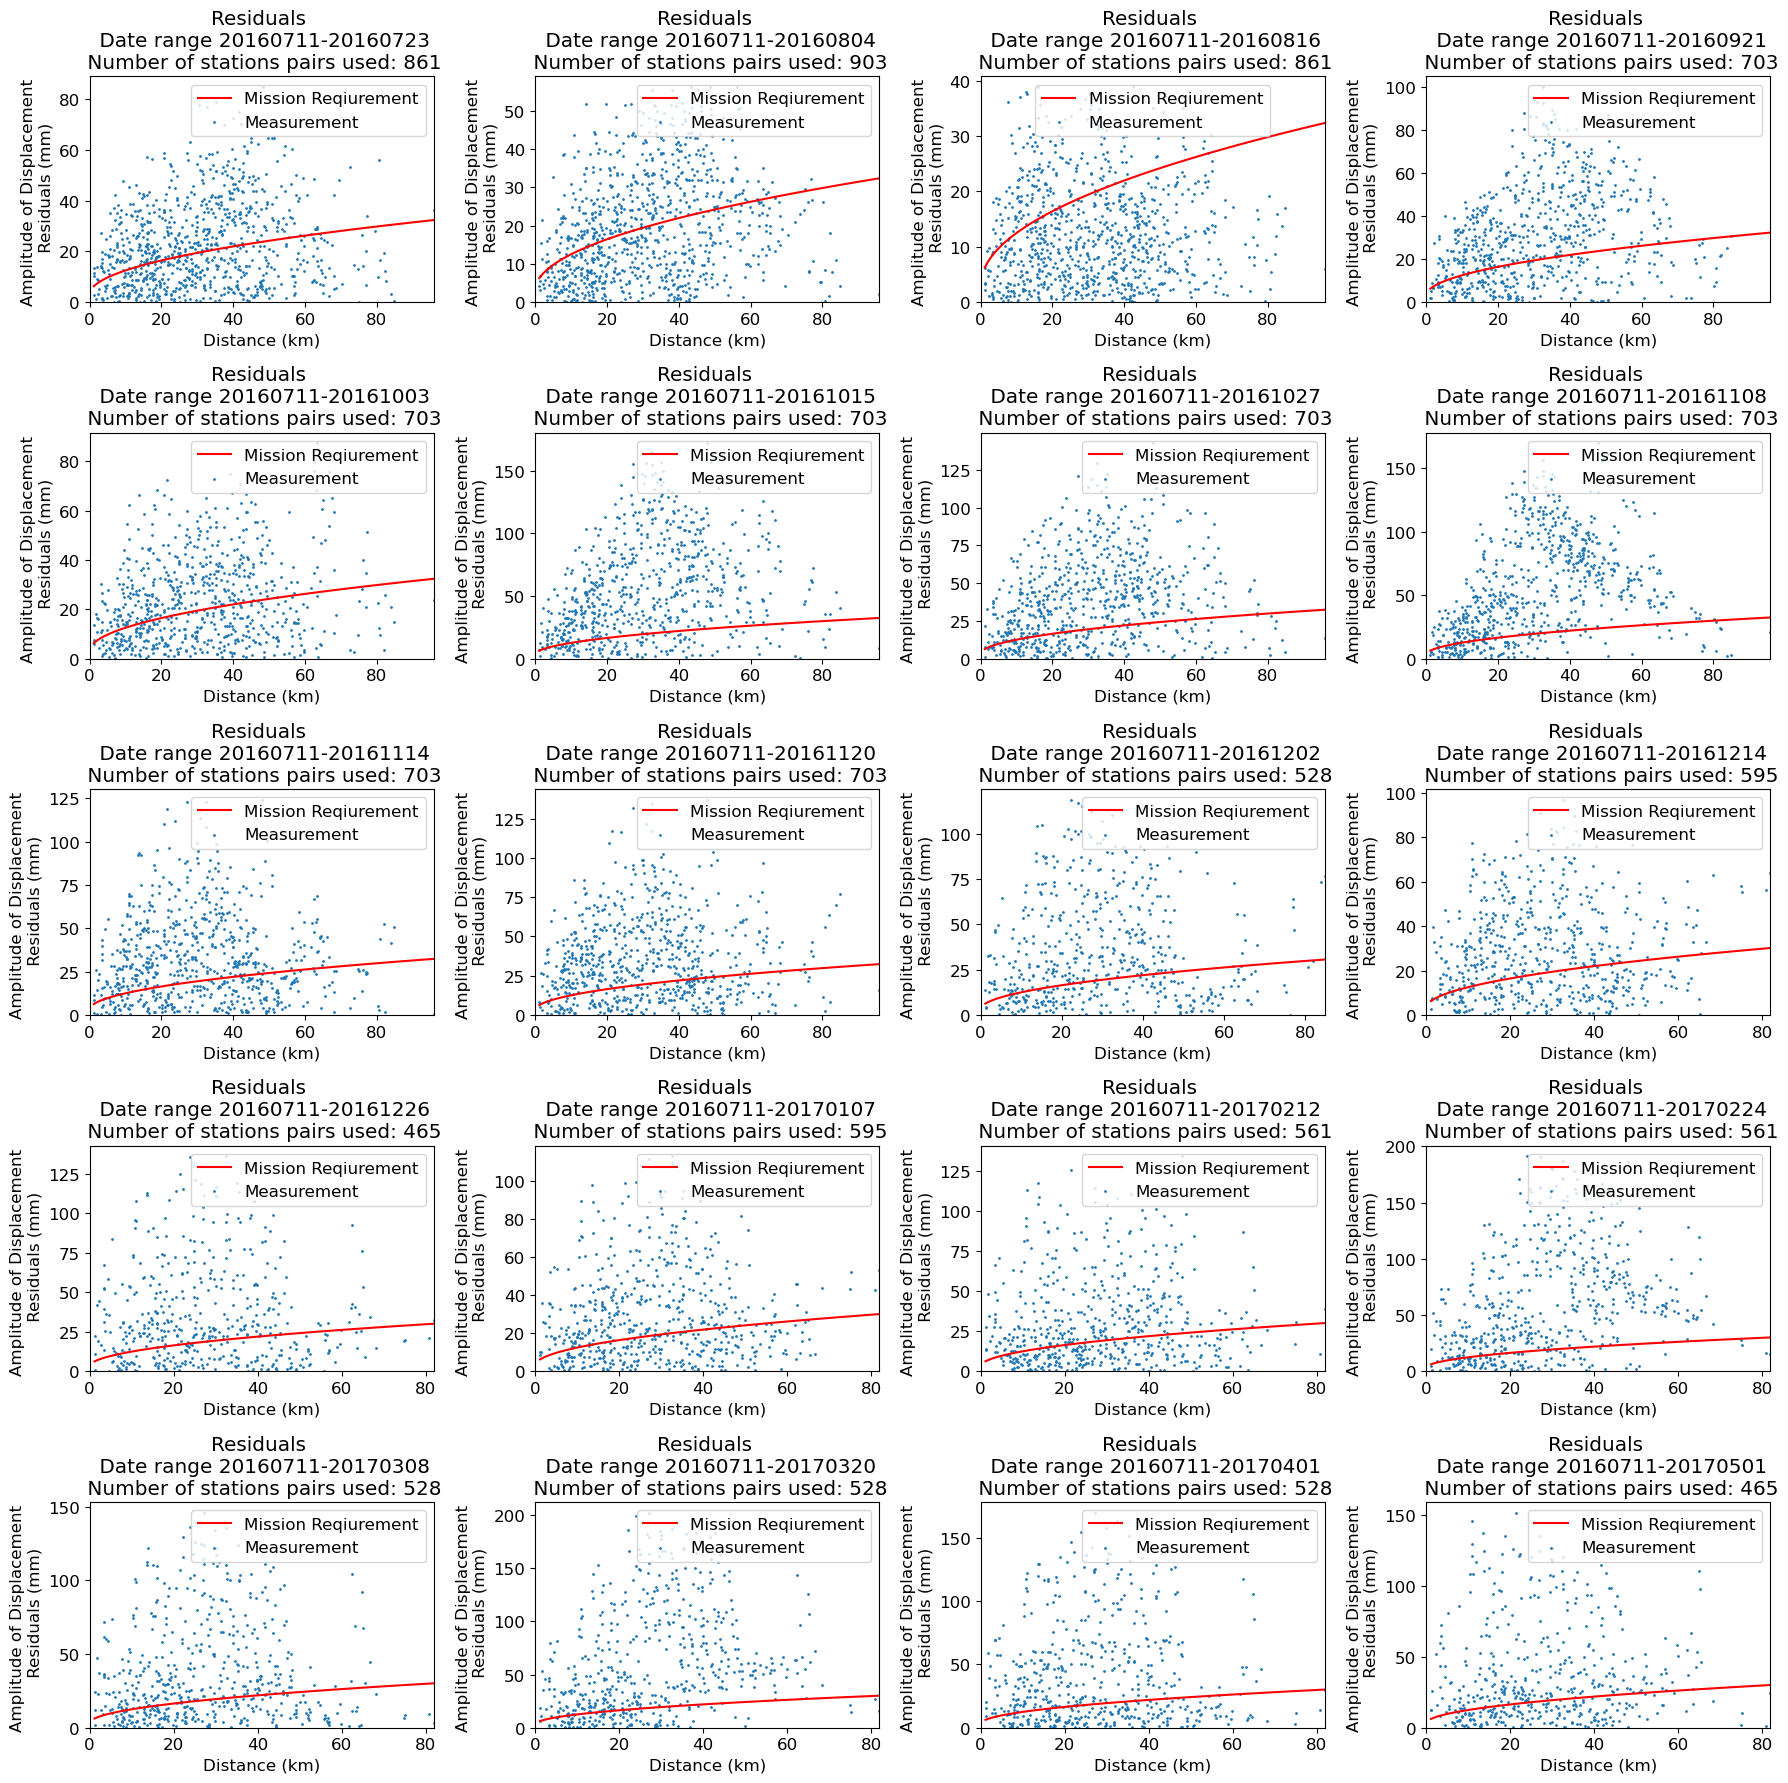

In [27]:
# Plotting only sampled pairs due to a large volume of DISP-S1
n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

col_figs = 4    # number of colums in figures
num_pairs_to_plot = 20

if num_pairs_to_plot > n_pairs:
    num_pairs_to_plot = n_pairs

num_figs = int(np.ceil(num_pairs_to_plot/col_figs)) * col_figs

sampled_index = sorted(random.sample(list(displacement.index.get_level_values(0).unique()),num_pairs_to_plot))

fig, ax = plt.subplots(int(np.ceil(num_pairs_to_plot/col_figs)), col_figs, figsize=[18, 18])
axs = ax.ravel()

for counter in range(num_figs):
    if (counter<n_pairs):
        _ind = displacement.index.get_level_values(0).unique()[counter]
        dist_th = np.linspace(min(ddiff_dist[_ind]),max(ddiff_dist[_ind]),100)
        acpt_error = 3*(1+np.sqrt(dist_th))
        axs[counter].plot(dist_th, acpt_error, 'r', label="Mission Reqiurement")
        axs[counter].scatter(ddiff_dist[_ind],abs_ddiff_disp[_ind],s=1, label="Measurement")
        date_range = f"{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}"
        axs[counter].set_xlabel("Distance (km)")
        axs[counter].set_ylabel("Amplitude of Displacement \n Residuals (mm)")
        axs[counter].set_title(f"Residuals \n Date range {date_range}\n Number of stations pairs used: {len(ddiff_dist[_ind])}")
        axs[counter].set_xlim(0,max(ddiff_dist[_ind]))
        axs[counter].set_ylim(ymin=0)
        axs[counter].legend()

    else:
        axs[counter].axis('off')

fig.tight_layout()

out_fig = f'{output_dir}/VA1_transient_Residuals_DISP-S1_gnss_randomSelected_site{site}.png'
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)


In [28]:
separate_figure_flag = False     # if plotting separate figures is needed

if separate_figure_flag:

    cmap = copy.copy(plt.get_cmap('RdBu'))

    n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

    for counter in range(n_pairs):
        fig, ax = plt.subplots(figsize=[12,12])
        _ind = displacement.index.get_level_values(0).unique()[counter]
        dist_th = np.linspace(min(ddiff_dist[_ind]),max(ddiff_dist[_ind]),100)
        acpt_error = 3*(1+np.sqrt(dist_th))
        ax.plot(dist_th, acpt_error, 'r', label="Mission Reqiurement")
        ax.scatter(ddiff_dist[_ind],abs_ddiff_disp[_ind],s=1, label="Measurement")
        date_range = f"{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}"
        ax.set_xlabel("Distance (km)")
        ax.set_ylabel("Amplitude of Displacement Residuals (mm)")
        ax.set_title(f"Residuals \n Date range {date_range}\n Number of stations pairs used: {len(ddiff_dist[_ind])}")
        ax.set_xlim(0,max(ddiff_dist[_ind]))
        ax.set_ylim(ymin=0)
        ax.legend()

        out_fig = f"{output_dir}/VA1_transient_Residuals_DISP-S1_gnss_site{site}_date{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}.png"
        fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
        plt.close()

In [29]:
ddiff_dist_ap1 = list(ddiff_dist.values())
abs_ddiff_disp_ap1 = list(abs_ddiff_disp.values())

We have got all needed data for approach 1:
- `ddiff_dist_ap1`: distance of GNSS pairs,
- `abs_ddiff_disp_ap1`: absolute value of measurement redisuals

<a id='transient_bin1'></a>
## Validate the requirement based on binned measurement residuals

In [30]:
n_ifgs = len(ddiff_dist_ap1)

Bin all measurement residuals to check if they pass the requirements or not:

In [31]:
n_bins = 10
bins = np.linspace(0.1,50.0,num=n_bins+1)

In [32]:
n_all = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points for each ifgs and bins
n_pass = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points pass
for i in range(n_ifgs):
    inds = np.digitize(ddiff_dist_ap1[i],bins)
    for j in range(1,n_bins+1):
        rqmt = 3*(1+np.sqrt(ddiff_dist_ap1[i][inds==j]))# mission requirement for i-th ifgs and j-th bins
        rem = abs_ddiff_disp_ap1[i][inds==j] # relative measurement
        assert len(rqmt) == len(rem)
        n_all[i,j-1] = len(rem)
        n_pass[i,j-1] = np.count_nonzero(rem<rqmt)
    n_all[i,-1] = np.sum(n_all[i,0:-2])
    n_pass[i,-1] = np.sum(n_pass[i,0:-2])

In [33]:
ratio = n_pass/n_all
thresthod = 0.683 
#The assumed nature of Gaussian distribution gives a probability of 0.683 of being within one standard deviation.
success_or_fail = ratio>thresthod

<a id='transient_result1'></a>
## Result visualization

Convert the result to pandas DataFrame for better visulization:

In [34]:
def to_str(x: bool):
    return 'true ' if x else 'false '

success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

index = []
for i in dates_index_gnss:
    index.append(ifgs_date_dt[i,0].strftime('%Y%m%d')+'-'+ifgs_date_dt[i,1].strftime('%Y%m%d'))

n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
n_pass_pd = pd.DataFrame(n_pass,columns=columns,index=index)
ratio_pd = pd.DataFrame(ratio,columns=columns,index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns,index=index)

Number of data points in each bin:

In [35]:
n_all_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160711-20160723         29          70           85           97   
20160711-20160804         29          70           91          106   
20160711-20160816         29          67           85          101   
20160711-20160921         25          58           69           75   
20160711-20161003         25          58           69           75   
...                      ...         ...          ...          ...   
20160711-20200924          0           2            0            1   
20160711-20200930          0           2            0            1   
20160711-20201006          0           2            0            1   
20160711-20201012          0           2            0            1   
20160711-20201018          0           2            0            1   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160711-20160723           82           79           79           82   
20160711-20160804           82           80           81           86   
20160711-20160816           79           72           75           84   
20160711-20160921           72           62           61           69   
20160711-20161003           72           62           61           69   
...                        ...          ...          ...          ...   
20160711-20200924            0            0            0            1   
20160711-20200930            0            0            0            1   
20160711-20201006            0            0            0            1   
20160711-20201012            0            0            0            0   
20160711-20201018            0            0            0            0   

                   40.02-45.01  45.01-50.00  total  
20160711-20160723           78           62    681  
20160711-20160804           83           67    708  
20160711-20160816           80           63    672  
20160711-20160921           64           49    555  
20160711-20161003           64           49    555  
...                        ...          ...    ...  
20160711-20200924            2            0      6  
20160711-20200930            2            0      6  
20160711-20201006            2            0      6  
20160711-20201012            0            0      3  
20160711-20201018            0            0      3  

[219 rows x 11 columns]

Number of data points that below the curve:

In [36]:
n_pass_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160711-20160723         12          25           41           40   
20160711-20160804         18          43           51           59   
20160711-20160816         17          40           42           64   
20160711-20160921         11          28           20           26   
20160711-20161003          9          28           29           29   
...                      ...         ...          ...          ...   
20160711-20200924          0           0            0            0   
20160711-20200930          0           0            0            0   
20160711-20201006          0           0            0            0   
20160711-20201012          0           0            0            0   
20160711-20201018          0           0            0            0   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160711-20160723           33           40           29           27   
20160711-20160804           32           40           31           40   
20160711-20160816           57           58           50           72   
20160711-20160921           28           22           12           12   
20160711-20161003           27           28           22           32   
...                        ...          ...          ...          ...   
20160711-20200924            0            0            0            0   
20160711-20200930            0            0            0            0   
20160711-20201006            0            0            0            0   
20160711-20201012            0            0            0            0   
20160711-20201018            0            0            0            0   

                   40.02-45.01  45.01-50.00  total  
20160711-20160723           32           34    279  
20160711-20160804           39           33    353  
20160711-20160816           74           59    474  
20160711-20160921           17           11    176  
20160711-20161003           26           24    230  
...                        ...          ...    ...  
20160711-20200924            2            0      2  
20160711-20200930            1            0      1  
20160711-20201006            1            0      1  
20160711-20201012            0            0      0  
20160711-20201018            0            0      0  

[219 rows x 11 columns]

Percentage of pass:

In [37]:
ratio_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160711-20160723   0.413793    0.357143     0.482353     0.412371   
20160711-20160804   0.620690    0.614286     0.560440     0.556604   
20160711-20160816   0.586207    0.597015     0.494118     0.633663   
20160711-20160921   0.440000    0.482759     0.289855     0.346667   
20160711-20161003   0.360000    0.482759     0.420290     0.386667   
...                      ...         ...          ...          ...   
20160711-20200924        NaN    0.000000          NaN     0.000000   
20160711-20200930        NaN    0.000000          NaN     0.000000   
20160711-20201006        NaN    0.000000          NaN     0.000000   
20160711-20201012        NaN    0.000000          NaN     0.000000   
20160711-20201018        NaN    0.000000          NaN     0.000000   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160711-20160723     0.402439     0.506329     0.367089     0.329268   
20160711-20160804     0.390244     0.500000     0.382716     0.465116   
20160711-20160816     0.721519     0.805556     0.666667     0.857143   
20160711-20160921     0.388889     0.354839     0.196721     0.173913   
20160711-20161003     0.375000     0.451613     0.360656     0.463768   
...                        ...          ...          ...          ...   
20160711-20200924          NaN          NaN          NaN     0.000000   
20160711-20200930          NaN          NaN          NaN     0.000000   
20160711-20201006          NaN          NaN          NaN     0.000000   
20160711-20201012          NaN          NaN          NaN          NaN   
20160711-20201018          NaN          NaN          NaN          NaN   

                   40.02-45.01  45.01-50.00     total  
20160711-20160723     0.410256     0.548387  0.409692  
20160711-20160804     0.469880     0.492537  0.498588  
20160711-20160816     0.925000     0.936508  0.705357  
20160711-20160921     0.265625     0.224490  0.317117  
20160711-20161003     0.406250     0.489796  0.414414  
...                        ...          ...       ...  
20160711-20200924     1.000000          NaN  0.333333  
20160711-20200930     0.500000          NaN  0.166667  
20160711-20201006     0.500000          NaN  0.166667  
20160711-20201012          NaN          NaN  0.000000  
20160711-20201018          NaN          NaN  0.000000  

[219 rows x 11 columns]

In [38]:
df_ratio = ratio_pd.copy()
df_success = success_or_fail_pd.copy()
s = None

In [39]:
# Assuming your dataframe is called 'df'
s = df_ratio.style.format(precision=3)

# Format the index (date ranges) for better readability
df_ratio.index = df_ratio.index.map(lambda x: f"{x[:8]} to {x[9:]}")
df_ratio.index.name = "Date range"
df_ratio.columns = [f"{col} km" if col != "total" else col for col in df_ratio.columns]     # Add units to column headers

df_success.index = df_success.index.map(lambda x: f"{x[:8]} to {x[9:]}")
df_success.index.name = "Date range"
df_success.columns = [f"{col} km" if col != "total" else col for col in df_success.columns] 

# Set table styles
s.set_table_styles([
    {'selector': 'th, td', 'props': 'text-align: center; vertical-align: middle; border: 1px solid black;'},
    {'selector': 'caption', 'props': 'caption-side: top; font-size: 1.25em; font-weight: bold; background-color: #f2f2f2; padding: 8px;'},
    {'selector': 'th, td', 'props': 'text-align: center; vertical-align: middle;'},
    {'selector': 'table', 'props': 'border-collapse: collapse;'},
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
    {'selector': f'td:nth-child({len(df_ratio.columns)})', 'props': 'border-right: 2px dashed black;'},
    {'selector': f'th:nth-child({len(df_ratio.columns)})', 'props': 'border-right: 2px dashed black;'},
    {'selector': '.index_name', 'props': 'font-weight: bold; font-size: 1.1em; text-align: center;'},
    {'selector': 'tr:first-child', 'props': 'border-top: none;'},
    {'selector': 'tr:last-child', 'props': 'border-bottom: none;'},
    {'selector': 'td:first-child, th:first-child', 'props': 'border-left: none;'},
    {'selector': 'td:last-child, th:last-child', 'props': 'border-right: none;'},
])

s.set_td_classes(df_success)

# Set caption
s.set_caption("Distance")

s.set_properties(**{'text-align': 'center'})

# Display the styled table
s

In [40]:
ratio_pd.to_csv(f'{output_dir}/VA1_transient_DISP-S1-gnss_distance_table_site{site}.csv')

html = s.to_html()

html_filename = f'{output_dir}/VA1_transient_DISP-S1-gnss_distance_table_site{site}.html'
with open(html_filename, "w") as f:
    f.write(html)

<a id='transient_conclusion1'></a>
## Conclusion

In [41]:
percentage = np.count_nonzero(ratio_pd['total']>thresthod)/n_ifgs
print(f"Percentage of DISP-S1s passes the requirement: {percentage}")
if percentage >= 0.70:
    print('The DISP-S1 stack passes the requirement.')
else:
    print('The DISP-S1 stack fails the requirement.')

Percentage of DISP-S1s passes the requirement: 0.0045662100456621
The DISP-S1 stack fails the requirement.


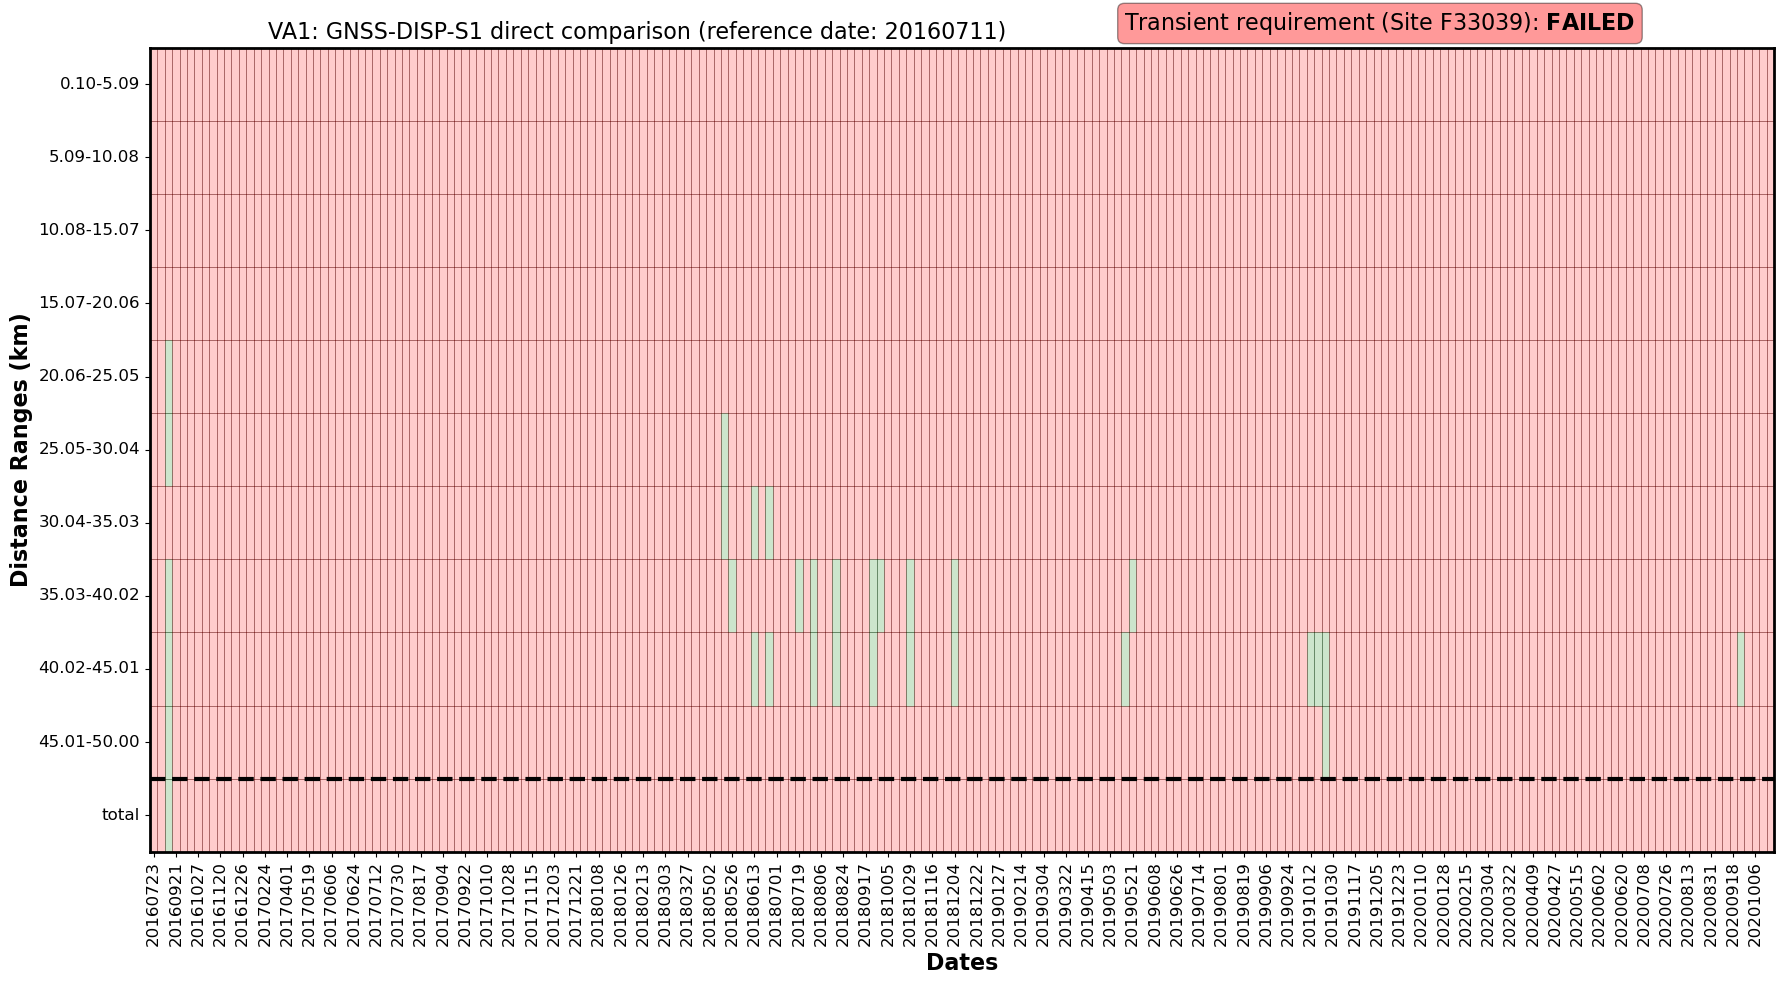

In [42]:
# output figure for displaying a validation result
reference_date = ifgs_date_dt[0,0].strftime('%Y%m%d') 
title_text = f'VA1: GNSS-DISP-S1 direct comparison (reference date: {reference_date})'
out_fig = f'{output_dir}/VA1_result_Transient_DISP-S1_vs_gnss_site{site}.png'
plot_transient_table(ratio_pd, site, percentage, thresthod, title_text, out_fig, annot=False) # generate a figure (annot=True means each cell has a value. Not recommended for large datasets)

<div class="alert alert-warning">
Approach 1 final result for CentralValleyA144: around 79% of DISP-S1s passes the requirement.
</div>

<a id='transient_validation2'></a>
# NISAR Validation Approach 2: Noise Level Validation

In this validation (Approach #2), we evaluate the estimated secular deformation rate (Requirements 658) or co-seismic displacement (Requirement 660) from time series processing or the individual DISP-S1 (Requirement 663) over selected cal/val areas with negligible deformation. Any estimated deformation should thus be treated as noise and our goal is to evaluate the significance of this noise. In general, noise in the modeled displacement or the unwrapped DISP-S1 is anisotropic, but here we neglect this anisotropy. Also, we assume the noise is stationary.

We first randomly sample measurements and pair up sampled pixel measurements. For each pixel-pair, the difference of their measurement becomes:
$$d\left(r\right)=|(f\left(x\right)-f\left(x-r\right))|$$
Estimates of $d(r)$ from all pairs are binned according to the distance r. In each bin, $d(r)$ is assumed to be a normal distribution.

**Note:** Now we simply assume there is no deformation in this study area and time interval. But in fact, it is hard to find a enough large area without any deformation. An more realistic solution is to apply a mask to mask out deformed regions.

<a id='transient_pair2'></a>
## Randomly sample pixels and pair them up

Calculate the coordinate for every pixel:

In [43]:
X0,Y0 = load_geo_utm(disp_S1_metadata)
X0_2d,Y0_2d = np.meshgrid(X0,Y0)

For each DISP-S1, randomly selected pixels need to be paired up. In order to keep measurements independent, different pixel pairs can not share same pixel. This is achieved by pairing up in sequence, i.e., pairing up pixel number 1 and number 2, 3 and 4...

In [44]:
dist = {}; rel_measure = {}
for i in dates_index:
    ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=i, coh_thr=minCoherence_parm) * phase2range*1000    # unit in mm   
    if apply_nonlinear_mask:
        ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score])
    else:
        ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr])

    dist_i, rel_measure_i = samp_pair(X0_2d,Y0_2d,ifgs_slice,num_samples=1000000)
    dist[i] = dist_i / 1000     # unit: km
    rel_measure[i] = rel_measure_i

Show the statistical property of selected pixel pairs:

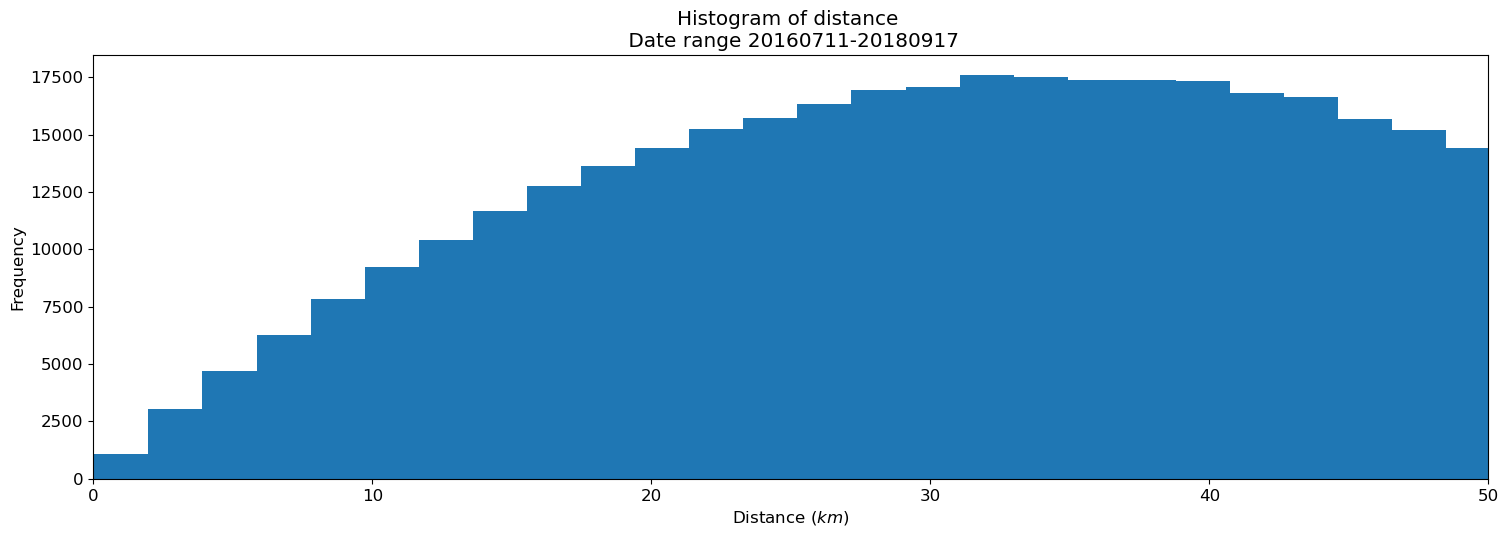

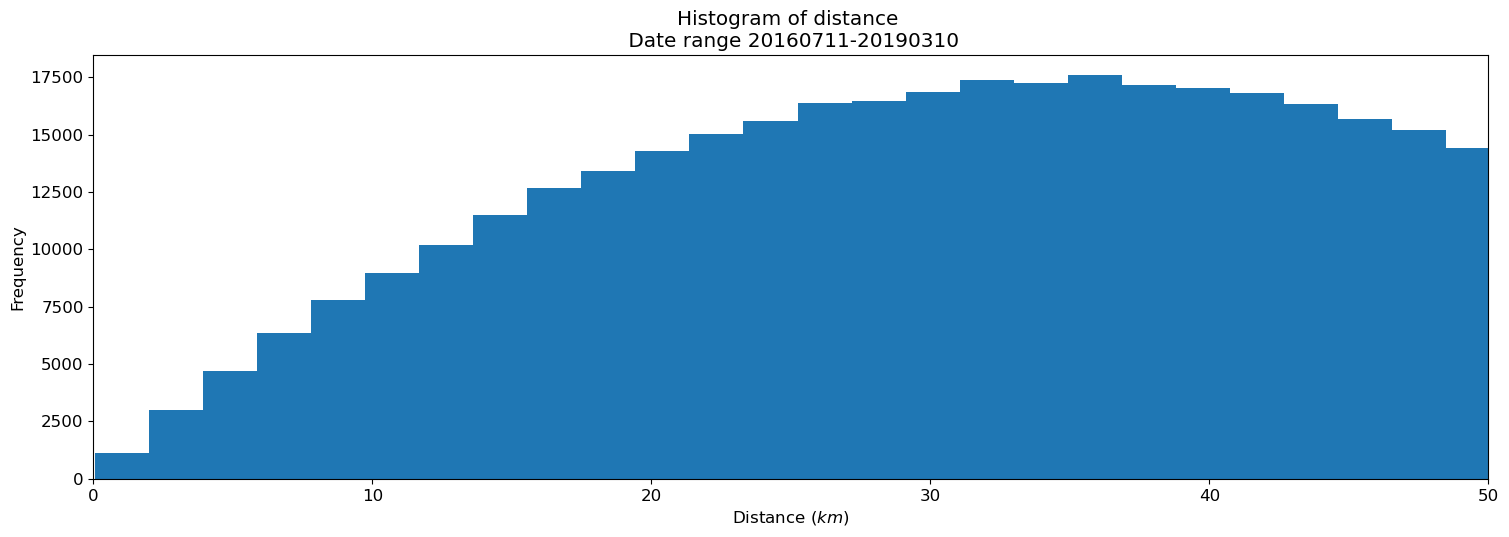

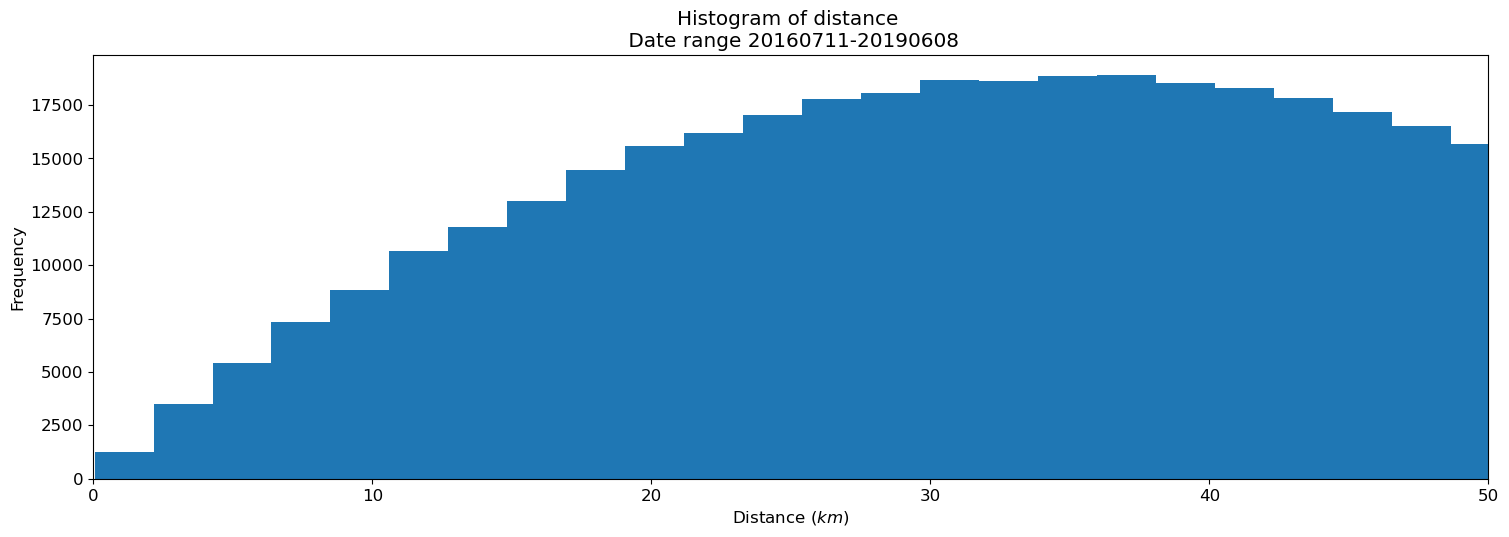

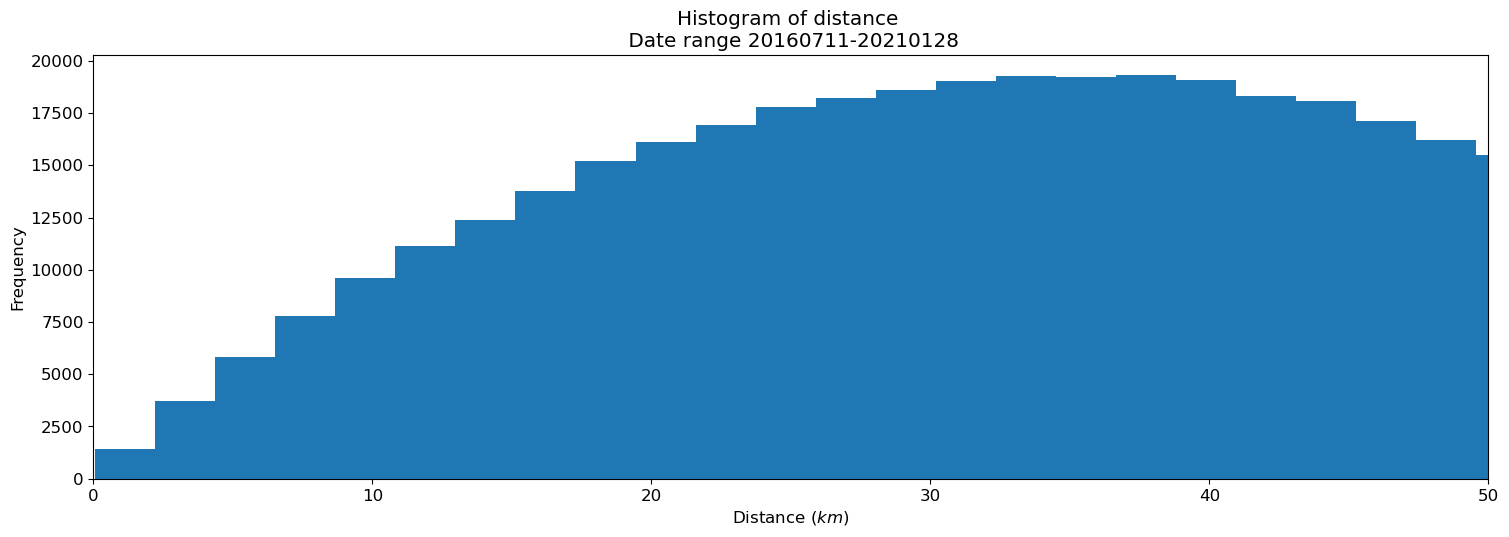

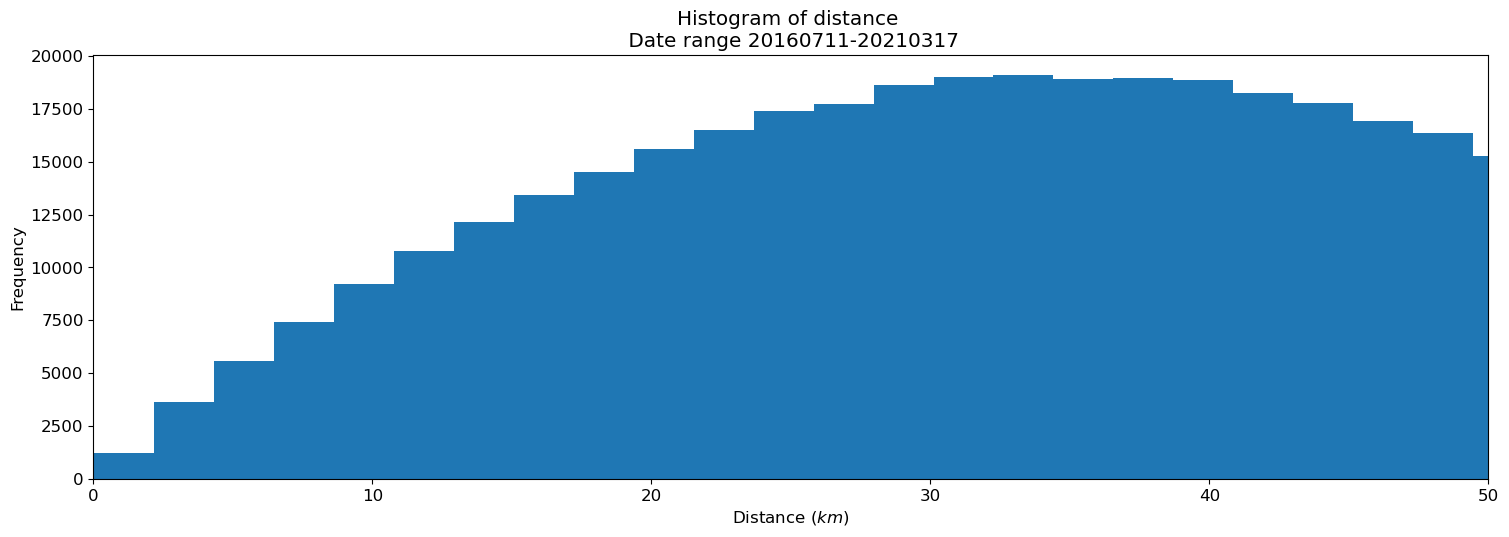

In [45]:
num_figs = 5  

sampled_index = sorted(random.sample(dates_index,num_figs))

for i in sampled_index:
    fig, ax = plt.subplots(figsize=[18, 5.5])
    img1 = ax.hist(dist[i], bins=100)
    ax.set_title(f"Histogram of distance \n Date range {ifgs_date_dt[i,0].strftime('%Y%m%d')}-{ifgs_date_dt[i,1].strftime('%Y%m%d')}")
    ax.set_xlabel(r'Distance ($km$)')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0,50)

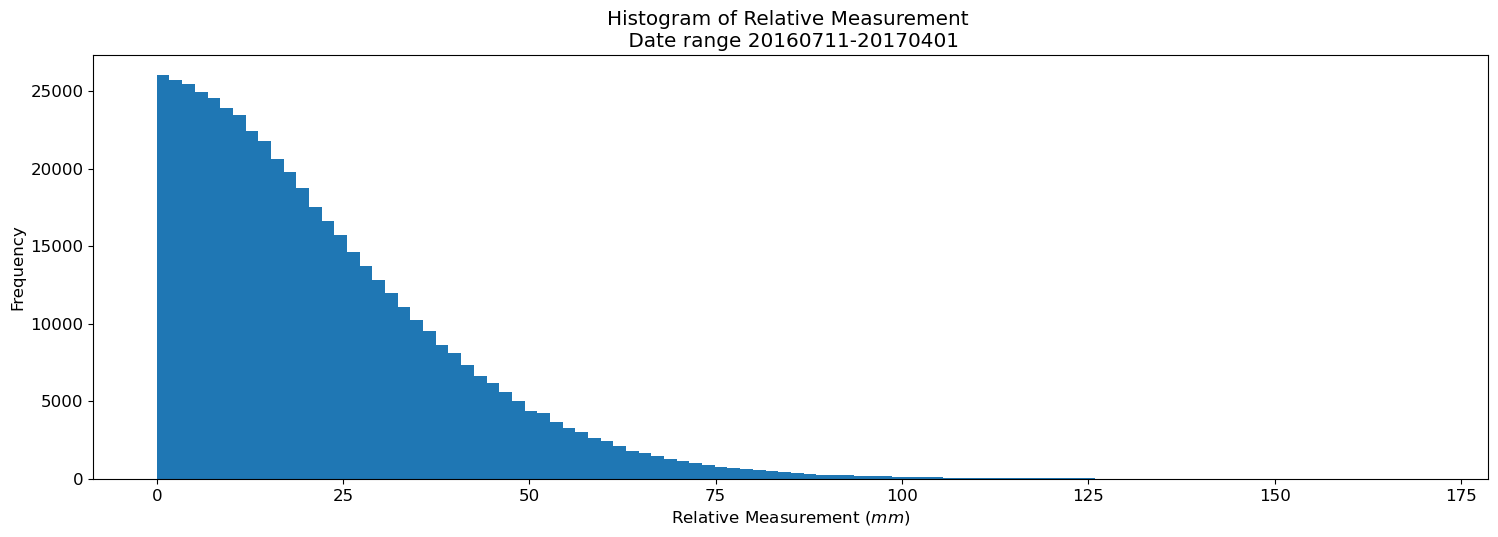

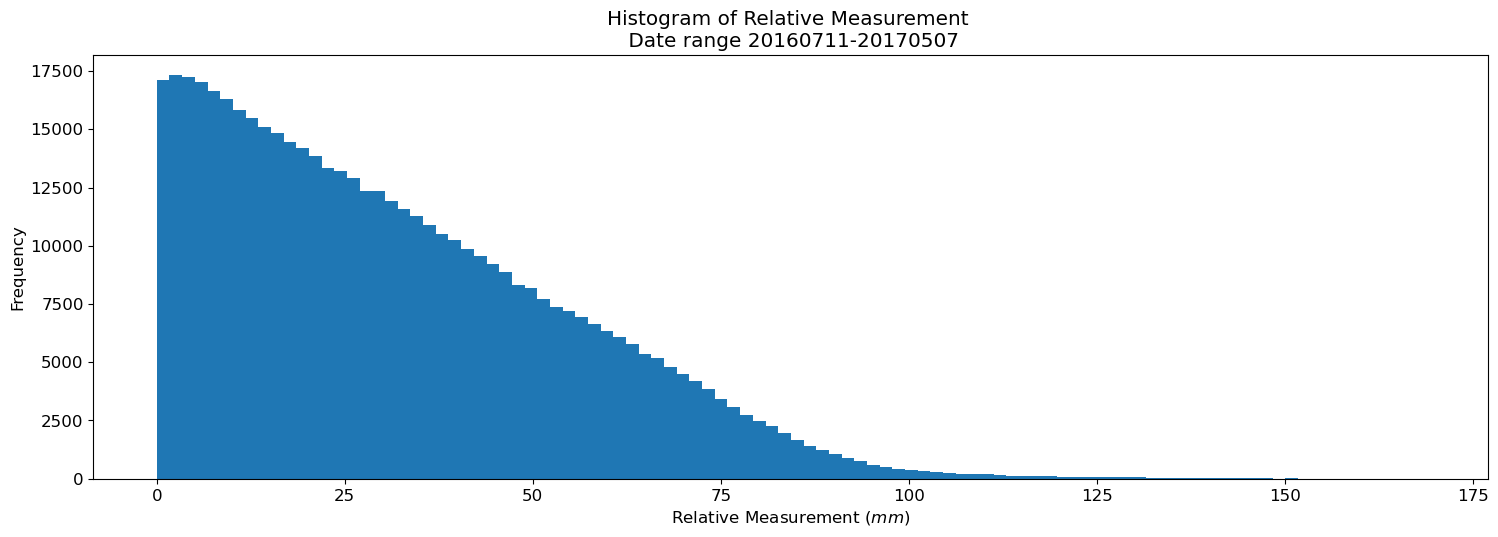

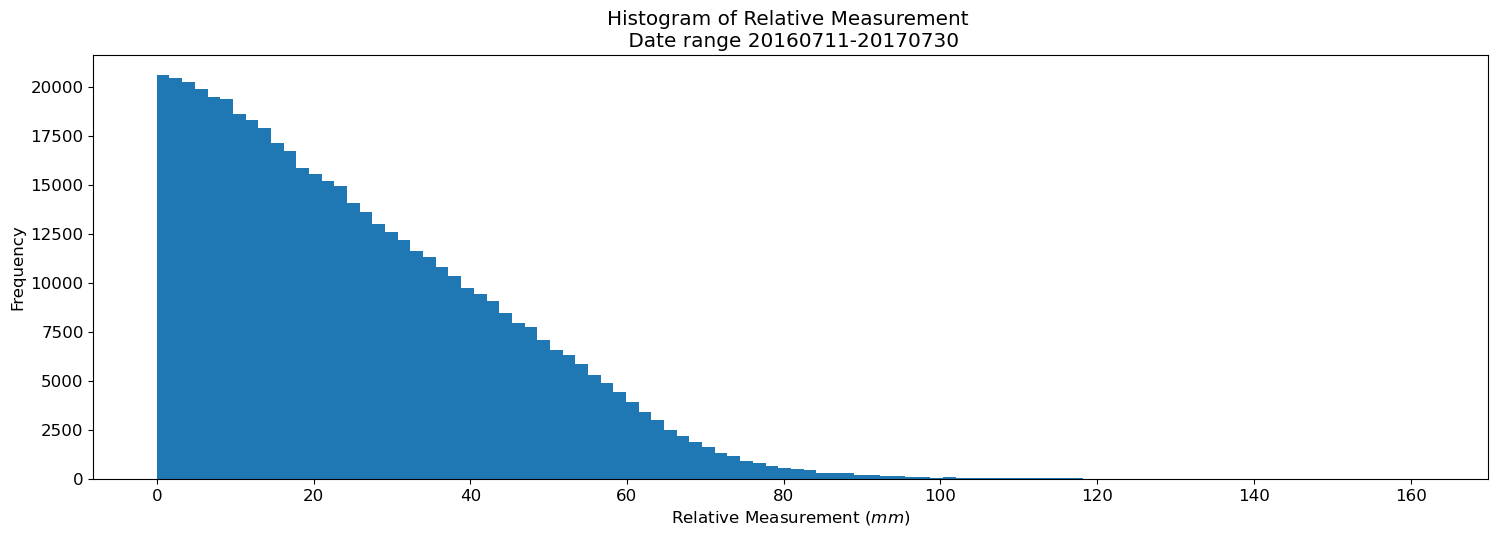

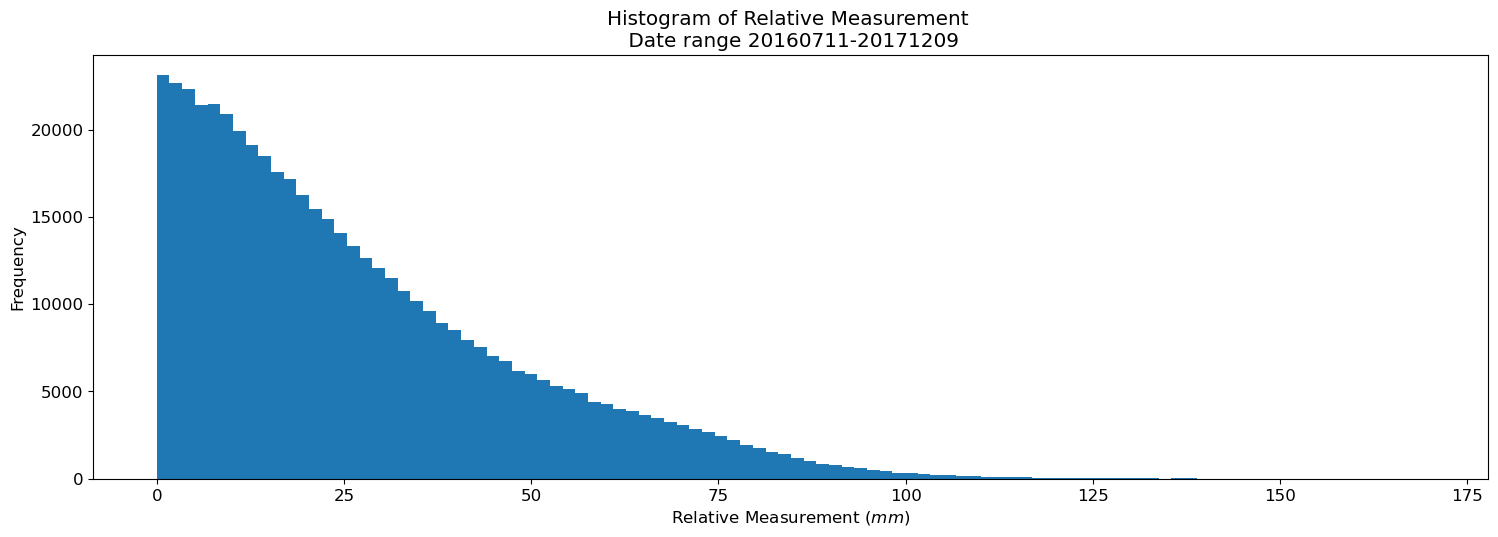

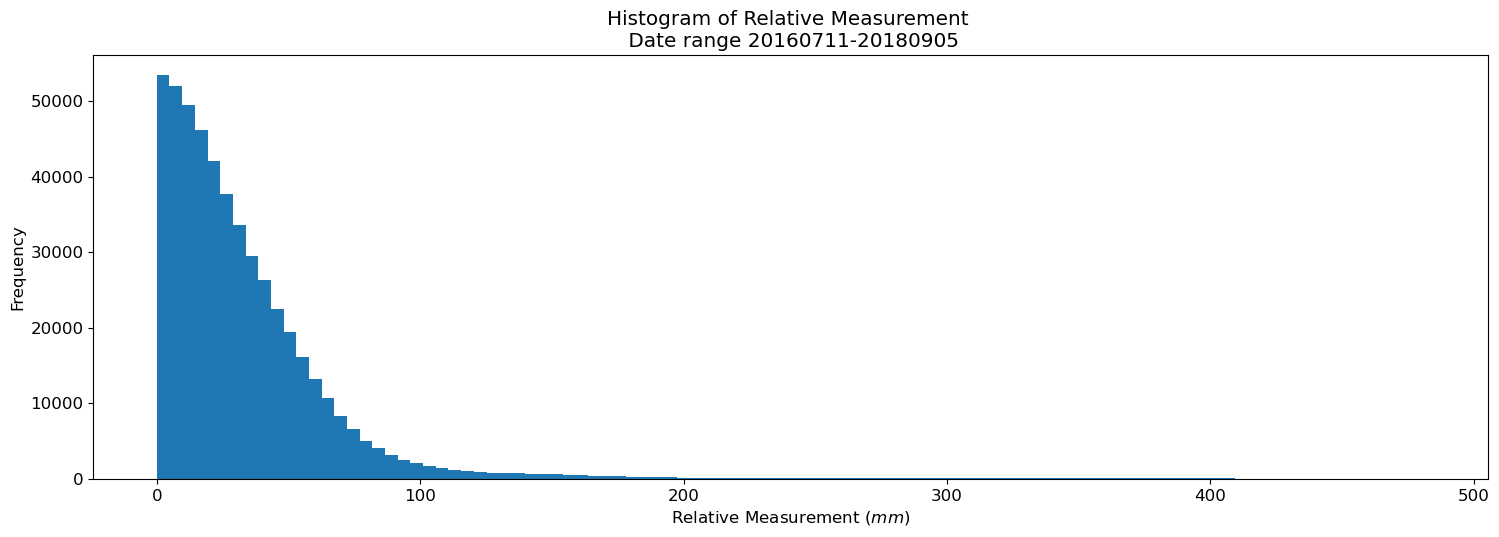

In [46]:
num_figs = 5  

sampled_index = sorted(random.sample(dates_index,num_figs))

for i in sampled_index:
    fig, ax = plt.subplots(figsize=[18, 5.5])
    img1 = ax.hist(rel_measure[i], bins=100)
    ax.set_title(f"Histogram of Relative Measurement \n Date range {ifgs_date_dt[i,0].strftime('%Y%m%d')}-{ifgs_date_dt[i,1].strftime('%Y%m%d')}")
    ax.set_xlabel(r'Relative Measurement ($mm$)')
    ax.set_ylabel('Frequency')

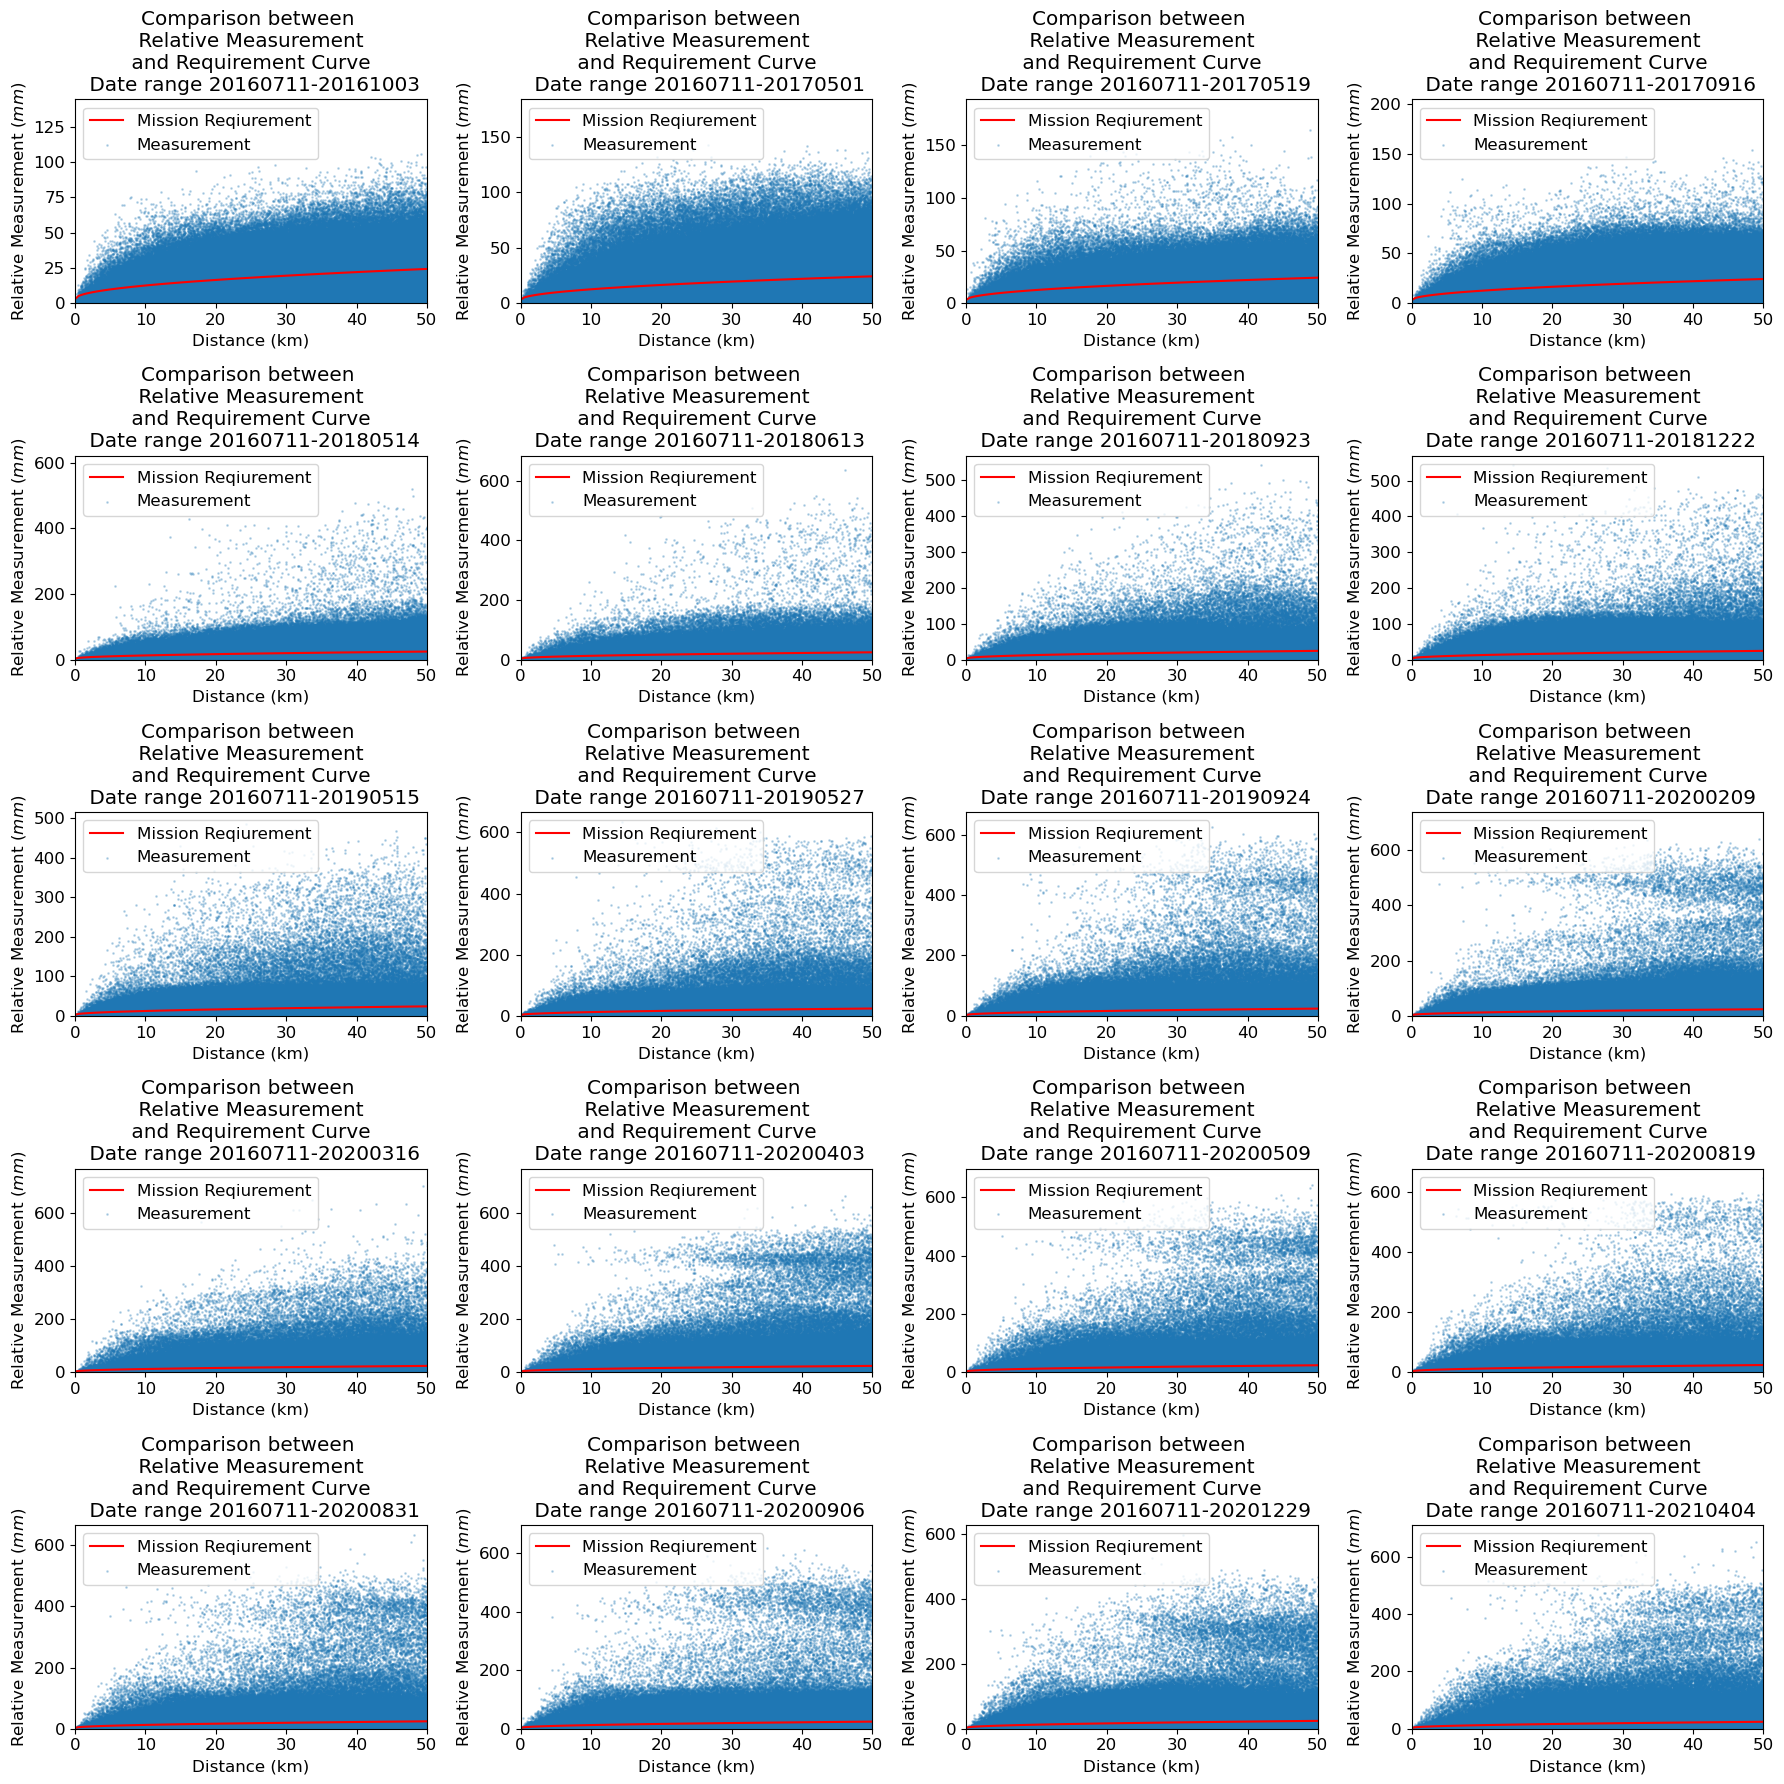

In [47]:
# Plotting only sampled pairs due to a large volume of DISP-S1
n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

col_figs = 4    # number of colums in figures
num_pairs_to_plot = 20

if num_pairs_to_plot > n_pairs:
    num_pairs_to_plot = n_pairs

num_figs = int(np.ceil(num_pairs_to_plot/col_figs)) * col_figs

sampled_index = sorted(random.sample(dates_index,num_pairs_to_plot))

fig, ax = plt.subplots(int(np.ceil(num_pairs_to_plot/col_figs)), col_figs, figsize=[18, 18])
axs = ax.ravel()

dist_th = np.linspace(0,50,100)
rqmt = 3*(1+np.sqrt(dist_th))

for counter in range(num_figs):
    if (counter<n_pairs):
        _ind = sampled_index[counter]
        axs[counter].plot(dist_th, rqmt, 'r', label="Mission Reqiurement")
        axs[counter].scatter(dist[_ind], rel_measure[_ind], s=1, alpha=0.25, label="Measurement")
        axs[counter].set_title(f"Comparison between \n Relative Measurement \n and Requirement Curve \n Date range {ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}")
        axs[counter].set_ylabel(r'Relative Measurement ($mm$)')
        axs[counter].set_xlabel('Distance (km)')
        axs[counter].set_xlim(0,50)
        axs[counter].set_ylim(ymin=0)
        axs[counter].legend()
    else:
        axs[counter].axis('off')

fig.tight_layout()

out_fig = f'{output_dir}/VA2_transient_relative_DISP-S1_measurements_randomSelected_site{site}.png'
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

In [48]:
separate_figure_flag = False     # if plotting separate figures is needed

if separate_figure_flag:

    cmap = copy.copy(plt.get_cmap('RdBu'))

    n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

    dist_th = np.linspace(0,50,100)
    rqmt = 3*(1+np.sqrt(dist_th))

    for counter in range(n_pairs):

        fig, ax = plt.subplots(figsize=[12,12])
        _ind = dates_index[counter]
        ax.plot(dist_th, rqmt, 'r', label="Mission Reqiurement")
        ax.scatter(dist[_ind], rel_measure[_ind], s=1, alpha=0.25, label="Measurement")
        ax.set_title(f"Comparison between \n Relative Measurement \n and Requirement Curve \n Date range {ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}")
        ax.set_ylabel(r'Relative Measurement ($mm$)')
        ax.set_xlabel('Distance (km)')
        ax.set_xlim(0,50)
        ax.set_ylim(ymin=0)

        out_fig = f"{output_dir}/VA2_transient_relative_DISP-S1_measurements_site{site}_date{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}.png"
        fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
        plt.close()

We have got data used of approach 2:
- `dist`: distance of pixel pairs,
- `rel_measure`: relative measurement of pixel pairs,

<a id='transient_bin2'></a>
## Validate the requirement based on binned measurement residuals

In [49]:
n_ifgs = len(dist)

Bin all measurement residuals to check if they pass the requirements or not:

In [50]:
n_bins = 10
bins = np.linspace(0.1,50.0,num=n_bins+1)

In [51]:
n_all = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points for each ifgs and bins
n_pass = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points pass

for counter, i in enumerate(dates_index):
    inds = np.digitize(dist[i],bins)
    for j in range(1,n_bins+1):
        rqmt = 3*(1+np.sqrt(dist[i][inds==j]))# mission requirement for i-th ifgs and j-th bins
        rem = rel_measure[i][inds==j] # relative measurement
        assert len(rqmt) == len(rem)
        n_all[counter,j-1] = len(rem)
        n_pass[counter,j-1] = np.count_nonzero(rem<rqmt)
    n_all[counter,-1] = np.sum(n_all[counter,0:-2])
    n_pass[counter,-1] = np.sum(n_pass[counter,0:-2])

In [52]:
ratio = n_pass/n_all
mean_ratio = np.array([np.mean(ratio[:,:-1],axis=1)])
ratio = np.hstack((ratio,mean_ratio.T))
thresthod = 0.683
#The assumed nature of Gaussian distribution gives a probability of 0.683 of being within one standard deviation.
success_or_fail = ratio>thresthod

<a id='transient_result2'></a>
## Result visualization

Convert the result to pandas DataFrame for better visulization:

In [53]:
def to_str(x: bool):
    return 'true ' if x else 'false '

success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

index = []
for i in dates_index:
    index.append(ifgs_date_dt[i,0].strftime('%Y%m%d')+'-'+ifgs_date_dt[i,1].strftime('%Y%m%d'))

n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
n_pass_pd = pd.DataFrame(n_pass,columns=columns,index=index)
ratio_pd = pd.DataFrame(ratio,columns=columns+['mean'],index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns+['mean'],index=index)

Number of data points in each bin:

In [54]:
n_all_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160711-20160723       6429       16486        24855        31853   
20160711-20160804       6528       16762        25149        32175   
20160711-20160816       6465       16832        25402        32273   
20160711-20160921       6523       16979        25312        32109   
20160711-20161003       6585       16900        25786        32707   
...                      ...         ...          ...          ...   
20160711-20210404       6833       17327        25857        33134   
20160711-20210410       6681       17413        25933        32999   
20160711-20210416       6730       17393        26011        33452   
20160711-20210422       6754       17086        26102        33172   
20160711-20210428       6729       17417        25733        33150   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160711-20160723        36778        40408        42785        43475   
20160711-20160804        37471        40956        43313        43648   
20160711-20160816        37408        40874        42983        43532   
20160711-20160921        37245        41118        43316        43527   
20160711-20161003        38265        41876        43888        43802   
...                        ...          ...          ...          ...   
20160711-20210404        38673        42108        44048        43885   
20160711-20210410        38247        42002        44021        44284   
20160711-20210416        38322        41775        43993        44369   
20160711-20210422        38127        42331        44179        44400   
20160711-20210428        38142        42041        44243        43806   

                   40.02-45.01  45.01-50.00   total  
20160711-20160723        41511        38816  284580  
20160711-20160804        42100        38561  288102  
20160711-20160816        41592        38622  287361  
20160711-20160921        41603        38727  287732  
20160711-20161003        41847        38387  291656  
...                        ...          ...     ...  
20160711-20210404        42296        38092  294161  
20160711-20210410        42026        38850  293606  
20160711-20210416        41684        38184  293729  
20160711-20210422        42021        38207  294172  
20160711-20210428        41889        38455  293150  

[251 rows x 11 columns]

Number of data points that below the curve:

In [55]:
n_pass_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160711-20160723       3478        7066         9972        13086   
20160711-20160804       4180        9150        12761        15868   
20160711-20160816       4909       11909        17535        22672   
20160711-20160921       4432        9792        13148        15829   
20160711-20161003       4361        9732        14073        17579   
...                      ...         ...          ...          ...   
20160711-20210404       4166        8337        11273        13330   
20160711-20210410       3621        6950         8927         9854   
20160711-20210416       3917        7812        10132        12331   
20160711-20210422       3716        7366        10060        12011   
20160711-20210428       3867        7857        10673        12769   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160711-20160723        15568        17567        18724        18587   
20160711-20160804        17986        19885        20631        20243   
20160711-20160816        27572        31671        35286        37050   
20160711-20160921        18587        21102        22646        23252   
20160711-20161003        20603        22640        24112        24046   
...                        ...          ...          ...          ...   
20160711-20210404        15109        16198        17315        17043   
20160711-20210410        11018        11962        11926        10962   
20160711-20210416        13226        13780        14203        14125   
20160711-20210422        13443        14533        15222        15461   
20160711-20210428        13796        15532        16672        16659   

                   40.02-45.01  45.01-50.00   total  
20160711-20160723        17688        15815  121736  
20160711-20160804        19208        17737  139912  
20160711-20160816        35810        33509  224414  
20160711-20160921        23031        22054  151819  
20160711-20161003        23158        21046  160304  
...                        ...          ...     ...  
20160711-20210404        15896        13453  118667  
20160711-20210410         9736         9071   84956  
20160711-20210416        13452        12551  102978  
20160711-20210422        15659        14623  107471  
20160711-20210428        15942        15445  113767  

[251 rows x 11 columns]

Ratio of pass:

In [56]:
ratio_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160711-20160723   0.540986    0.428606     0.401207     0.410825   
20160711-20160804   0.640319    0.545878     0.507416     0.493178   
20160711-20160816   0.759319    0.707521     0.690300     0.702507   
20160711-20160921   0.679442    0.576712     0.519437     0.492977   
20160711-20161003   0.662263    0.575858     0.545761     0.537469   
...                      ...         ...          ...          ...   
20160711-20210404   0.609688    0.481157     0.435975     0.402306   
20160711-20210410   0.541985    0.399127     0.344233     0.298615   
20160711-20210416   0.582021    0.449146     0.389528     0.368618   
20160711-20210422   0.550192    0.431113     0.385411     0.362082   
20160711-20210428   0.574677    0.451111     0.414759     0.385189   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160711-20160723     0.423297     0.434741     0.437630     0.427533   
20160711-20160804     0.479998     0.485521     0.476324     0.463778   
20160711-20160816     0.737062     0.774845     0.820929     0.851098   
20160711-20160921     0.499047     0.513206     0.522809     0.534197   
20160711-20161003     0.538429     0.540644     0.549398     0.548970   
...                        ...          ...          ...          ...   
20160711-20210404     0.390686     0.384677     0.393094     0.388356   
20160711-20210410     0.288075     0.284796     0.270916     0.247539   
20160711-20210416     0.345128     0.329862     0.322847     0.318353   
20160711-20210422     0.352585     0.343318     0.344553     0.348221   
20160711-20210428     0.361701     0.369449     0.376828     0.380290   

                   40.02-45.01  45.01-50.00     total      mean  
20160711-20160723     0.426104     0.407435  0.427774  0.433836  
20160711-20160804     0.456247     0.459973  0.485634  0.500863  
20160711-20160816     0.860983     0.867614  0.780948  0.777218  
20160711-20160921     0.553590     0.569473  0.527640  0.546089  
20160711-20161003     0.553397     0.548259  0.549634  0.560045  
...                        ...          ...       ...       ...  
20160711-20210404     0.375828     0.353171  0.403408  0.421494  
20160711-20210410     0.231666     0.233488  0.289354  0.314044  
20160711-20210416     0.322714     0.328698  0.350588  0.375691  
20160711-20210422     0.372647     0.382731  0.365334  0.387285  
20160711-20210428     0.380577     0.401638  0.388085  0.409622  

[251 rows x 12 columns]

In [57]:
df_ratio = ratio_pd.copy()
df_success = success_or_fail_pd.copy()

In [58]:
# Assuming your dataframe is called 'df'
s = df_ratio.style.format(precision=3)

# Format the index (date ranges) for better readability
df_ratio.index = df_ratio.index.map(lambda x: f"{x[:8]} to {x[9:]}")
df_ratio.index.name = "Date range"
df_ratio.columns = [f"{col} km" if (col != "total") and (col != "mean") else col for col in df_ratio.columns]     # Add units to column headers

df_success.index = df_success.index.map(lambda x: f"{x[:8]} to {x[9:]}")
df_success.index.name = "Date range"
df_success.columns = [f"{col} km" if (col != "total") and (col != "mean") else col for col in df_success.columns] 

# Set table styles
s.set_table_styles([
    {'selector': 'th, td', 'props': 'text-align: center; vertical-align: middle; border: 1px solid black;'},
    {'selector': 'caption', 'props': 'caption-side: top; font-size: 1.25em; font-weight: bold; background-color: #f2f2f2; padding: 8px;'},
    {'selector': 'th, td', 'props': 'text-align: center; vertical-align: middle;'},
    {'selector': 'table', 'props': 'border-collapse: collapse;'},
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
    {'selector': f'td:nth-child({len(df_ratio.columns)})', 'props': 'border-right: 2px dashed black;'},
    {'selector': f'th:nth-child({len(df_ratio.columns)})', 'props': 'border-right: 2px dashed black;'},
    {'selector': f'td:nth-child({len(df_ratio.columns) - 1})', 'props': 'border-right: 2px dashed black;'},
    {'selector': f'th:nth-child({len(df_ratio.columns) - 1})', 'props': 'border-right: 2px dashed black;'},
    {'selector': '.index_name', 'props': 'font-weight: bold; font-size: 1.1em; text-align: center;'},
    {'selector': 'tr:first-child', 'props': 'border-top: none;'},
    {'selector': 'tr:last-child', 'props': 'border-bottom: none;'},
    {'selector': 'td:first-child, th:first-child', 'props': 'border-left: none;'},
    {'selector': 'td:last-child, th:last-child', 'props': 'border-right: none;'},
])

s.set_td_classes(df_success)

# Set caption
s.set_caption("Distance")

s.set_properties(**{'text-align': 'center'})

# Display the styled table
s

In [59]:
ratio_pd.to_csv(f'{output_dir}/VA2_transient_insa_relative_distance_table_site{site}.csv')

html = s.to_html()

html_filename = f'{output_dir}/VA2_transient_insa_relative_distance_table_site{site}.html'
with open(html_filename, "w") as f:
    f.write(html)

<a id='transient_conclusion2'></a>
## Conclusion

Compared with percentage of total passed pairs, the mean value of percentage of passed pairs in all bin is a better indicator since it gives all bins same weight. 

In [60]:
percentage = np.count_nonzero(ratio_pd['mean']>thresthod)/n_ifgs

In [61]:
print(f"Percentage of DISP-S1s passes the requirement (70%): {percentage}.")
if percentage >= 0.70:
    print('The DISP-S1 stack passes the requirement.')
else:
    print('The DISP-S1 stack fails the requirement.')

Percentage of DISP-S1s passes the requirement (70%): 0.01593625498007968.
The DISP-S1 stack fails the requirement.


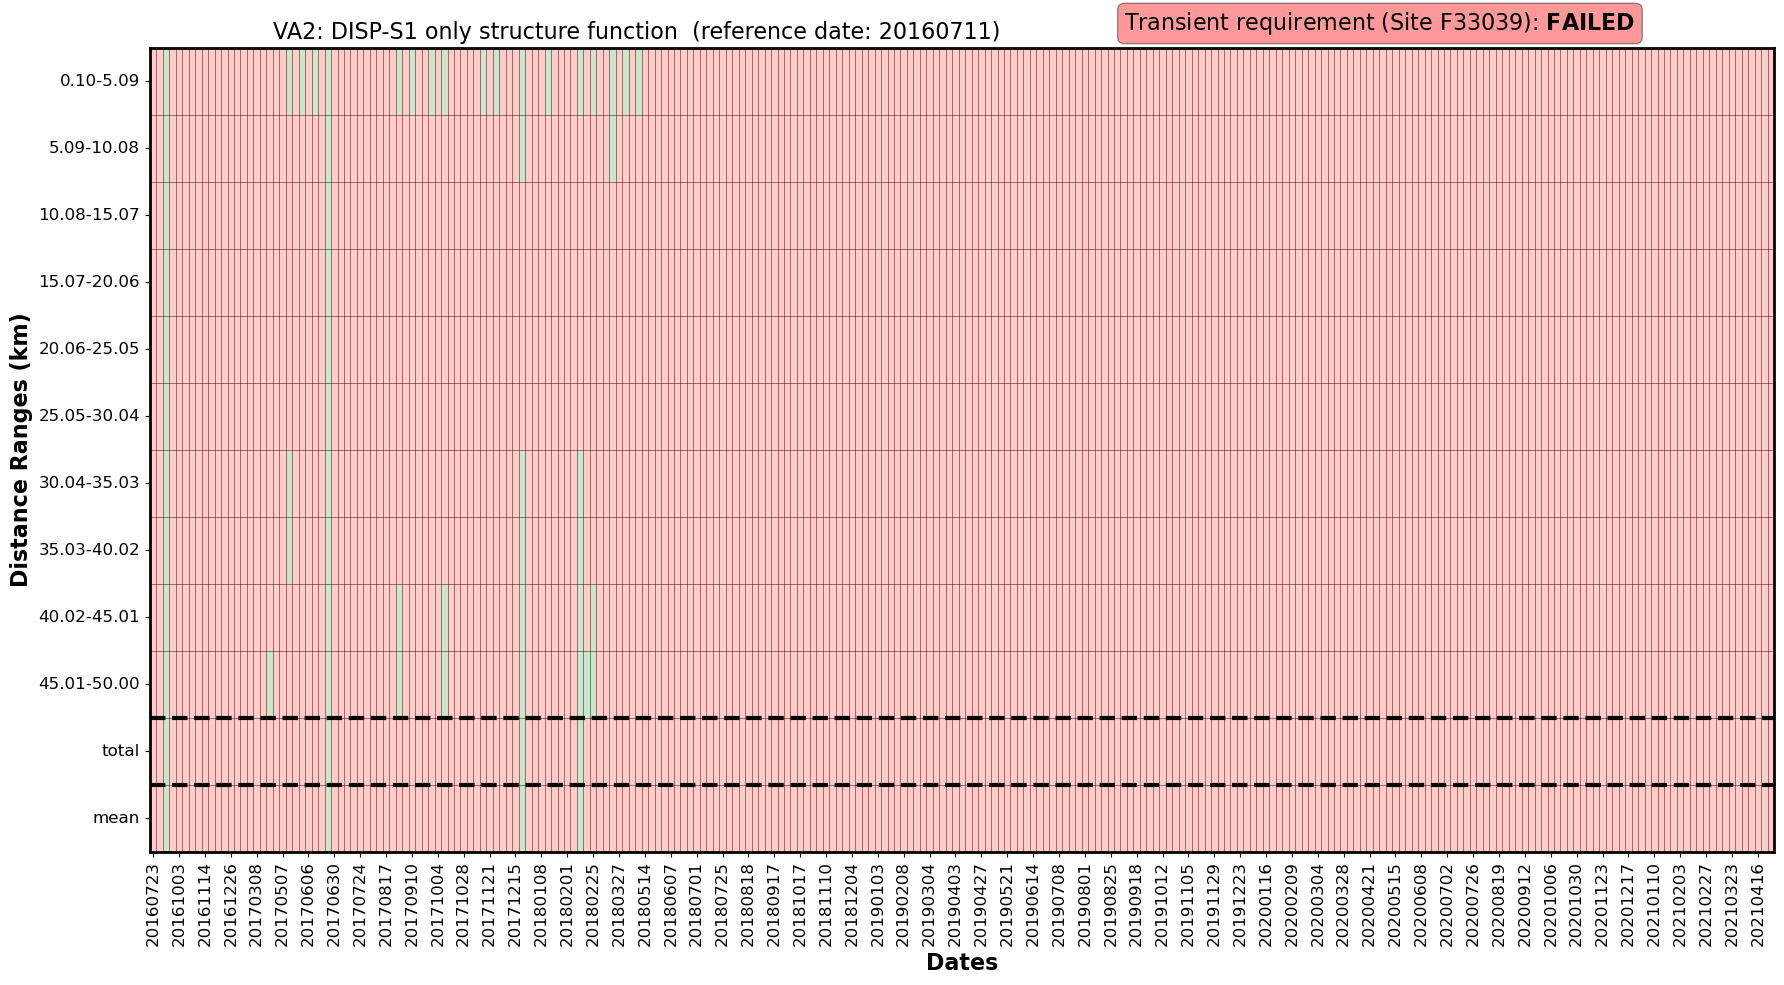

In [62]:
# output figure for displaying a validation result
reference_date = ifgs_date_dt[0,0].strftime('%Y%m%d') 
title_text = f'VA2: DISP-S1 only structure function  (reference date: {reference_date})'
out_fig = f'{output_dir}/VA2_result_Transient_relative_DISP-S1_measurements_site{site}.png'
plot_transient_table(ratio_pd, site, percentage, thresthod, title_text, out_fig, annot=False) # generate a figure (annot=True means each cell has a value. Not recommended for large datasets)

<div class="alert alert-warning">
Approach 2 final result for CentralValleyA144: 100% of DISP-S1s passes the requirement.
</div>

<a id='transient_appendix'></a>
# Appendix: GNSS Position Plots

GNSS vs DISP-S1 scatter plots

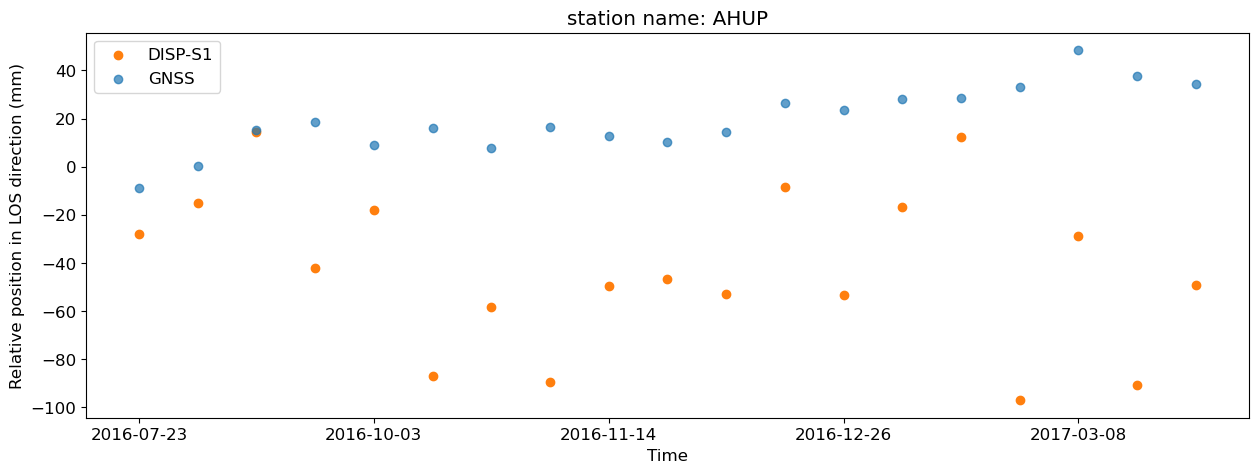

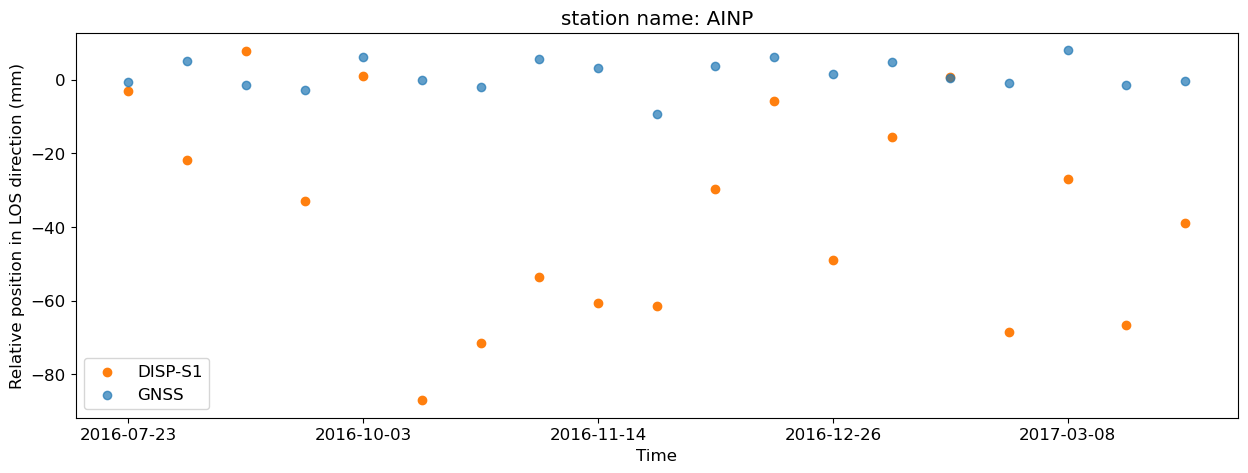

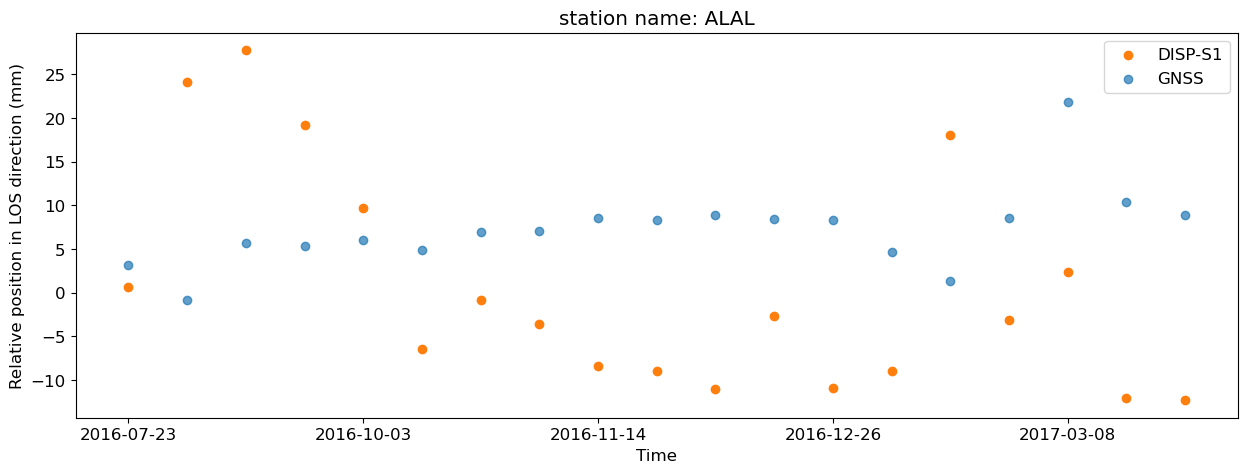

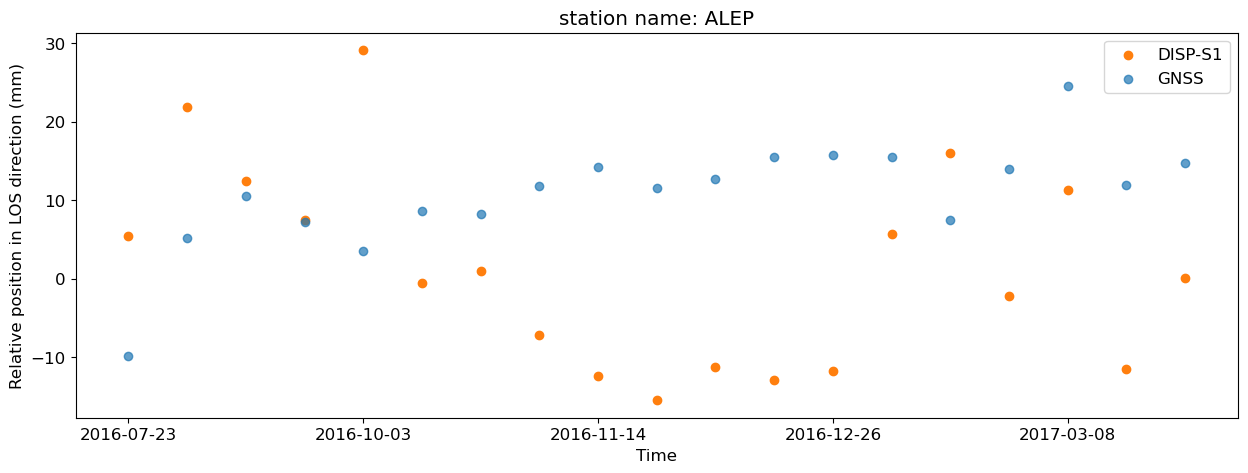

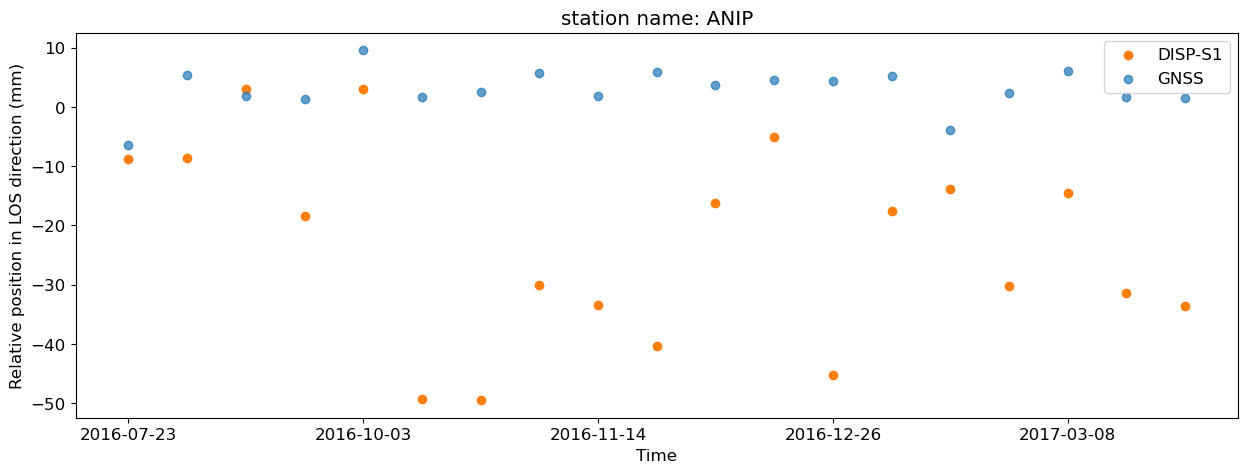

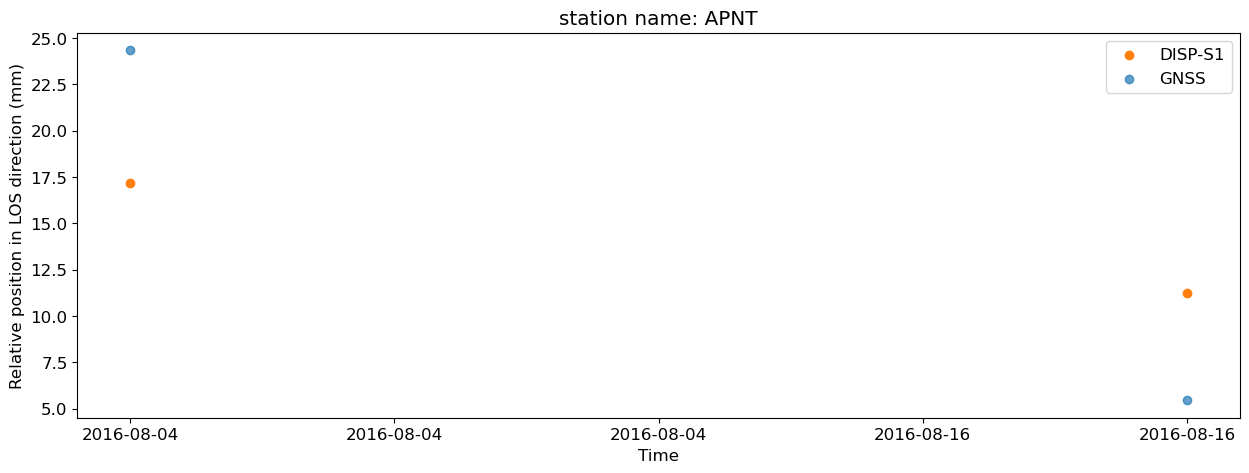

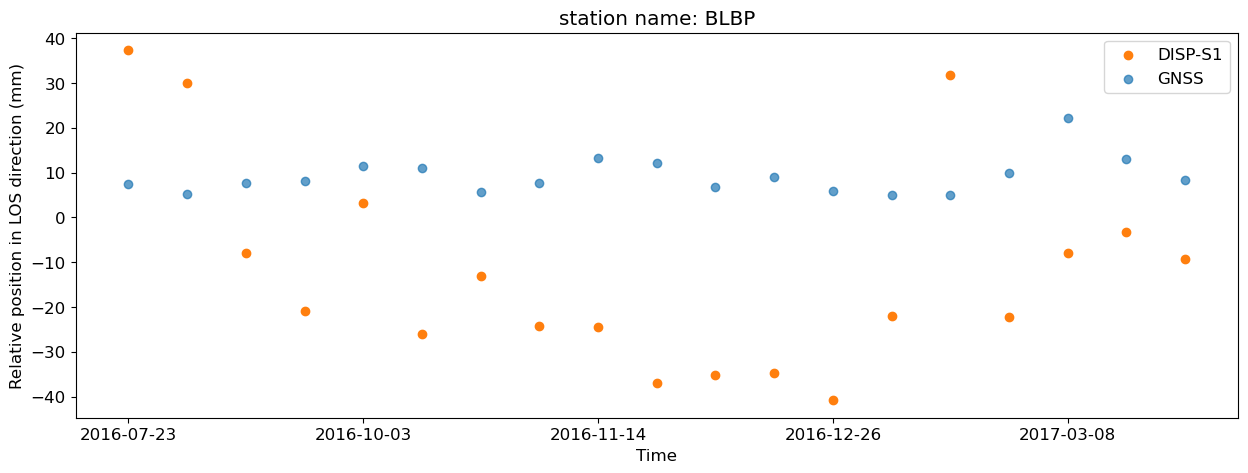

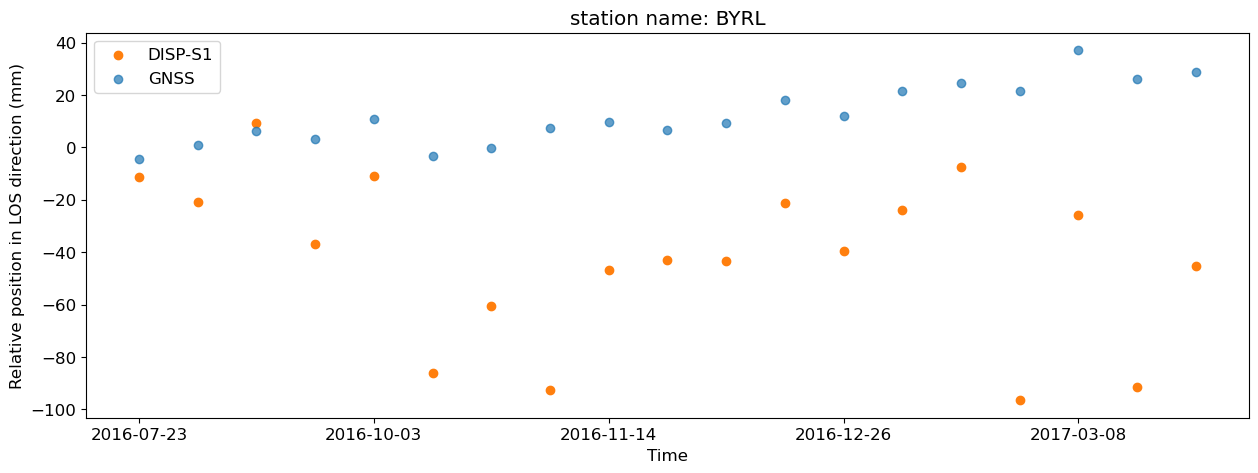

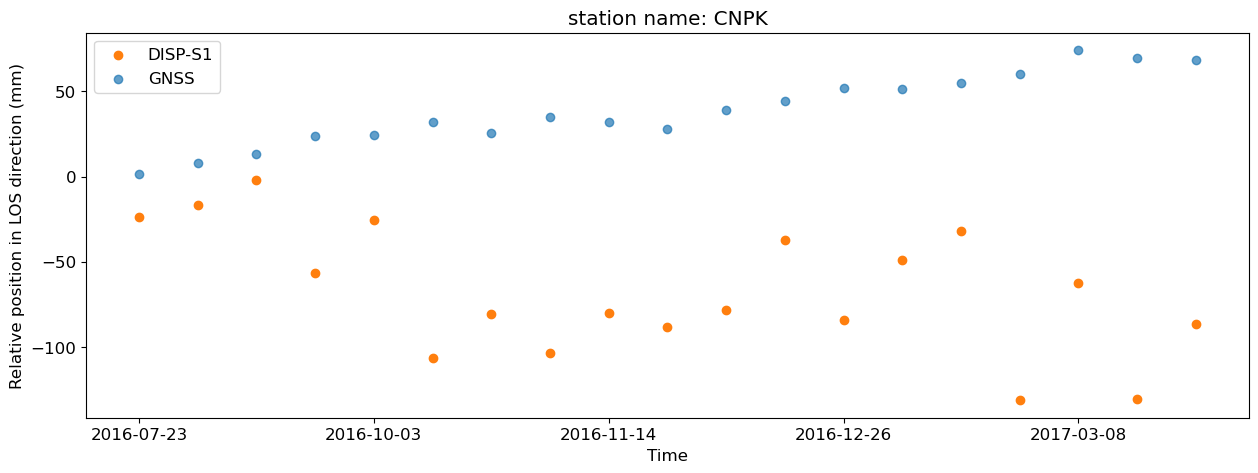

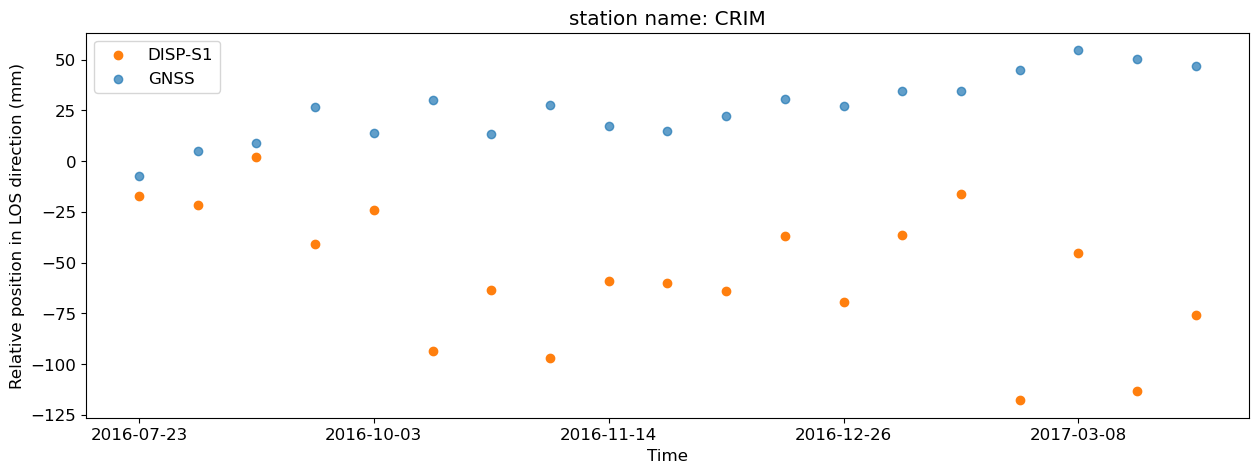

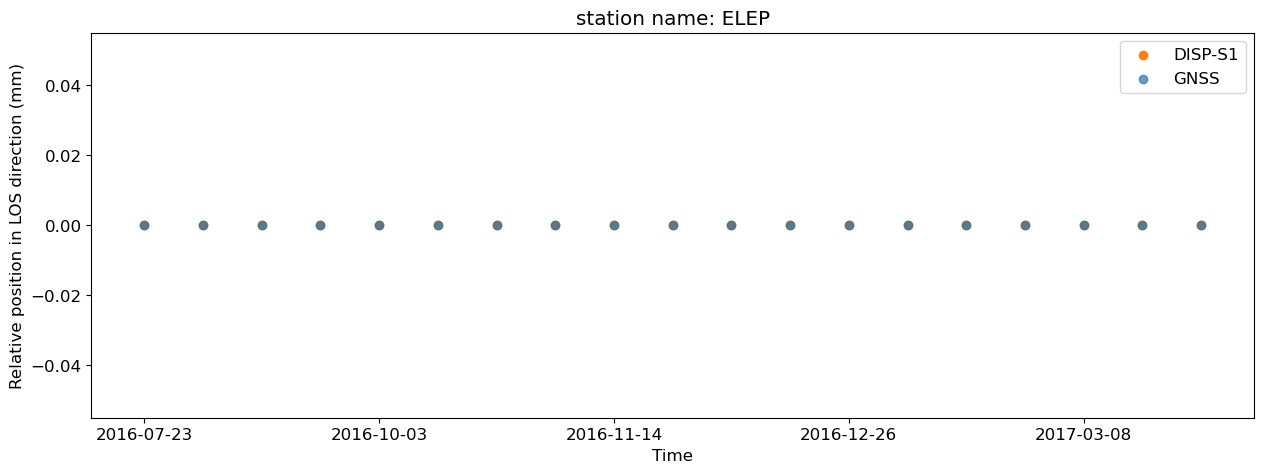

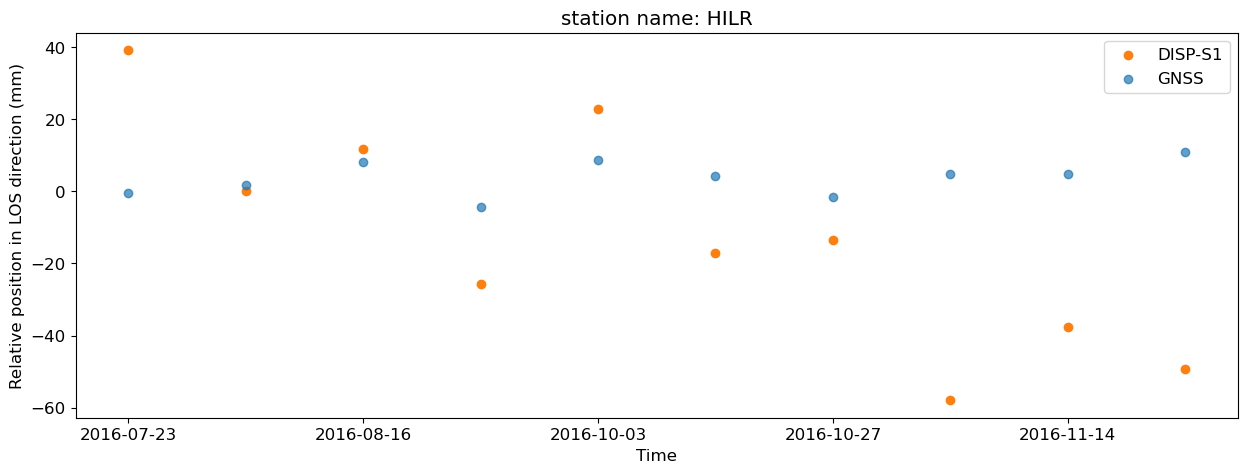

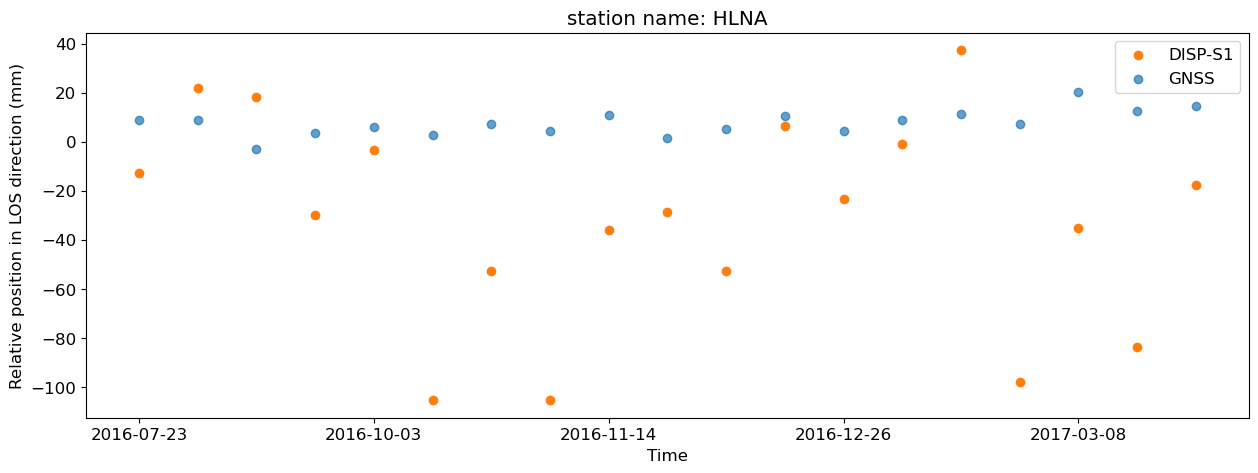

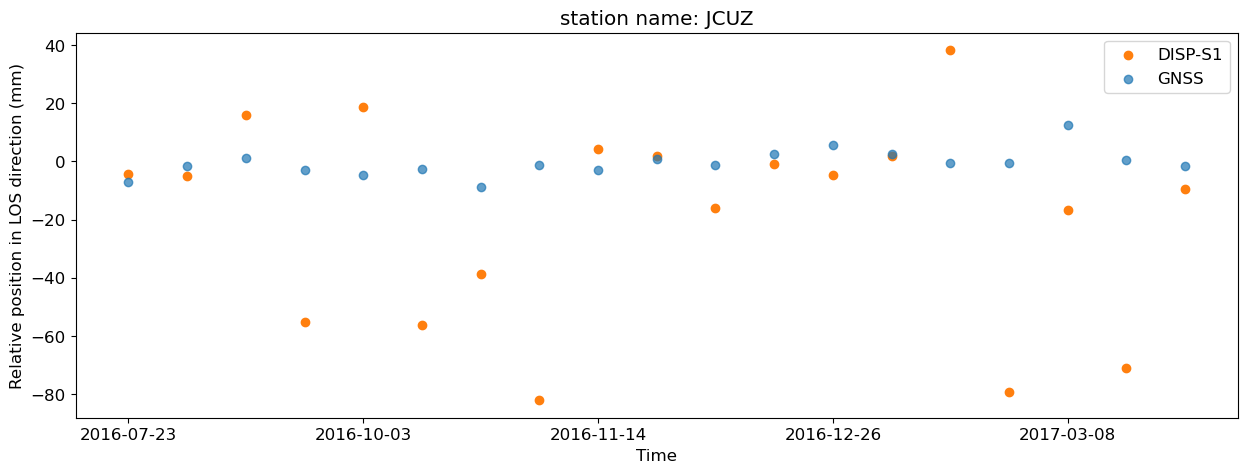

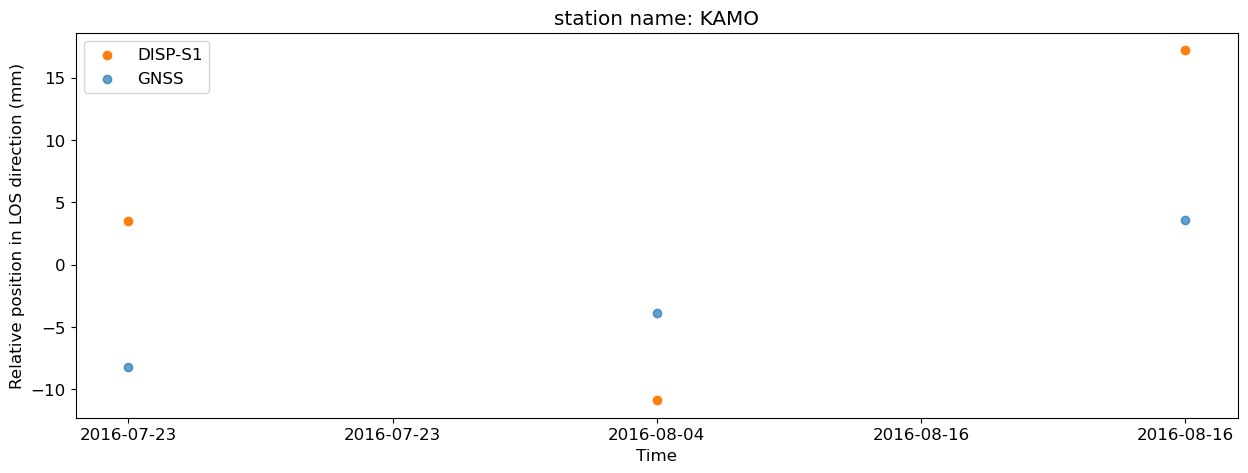

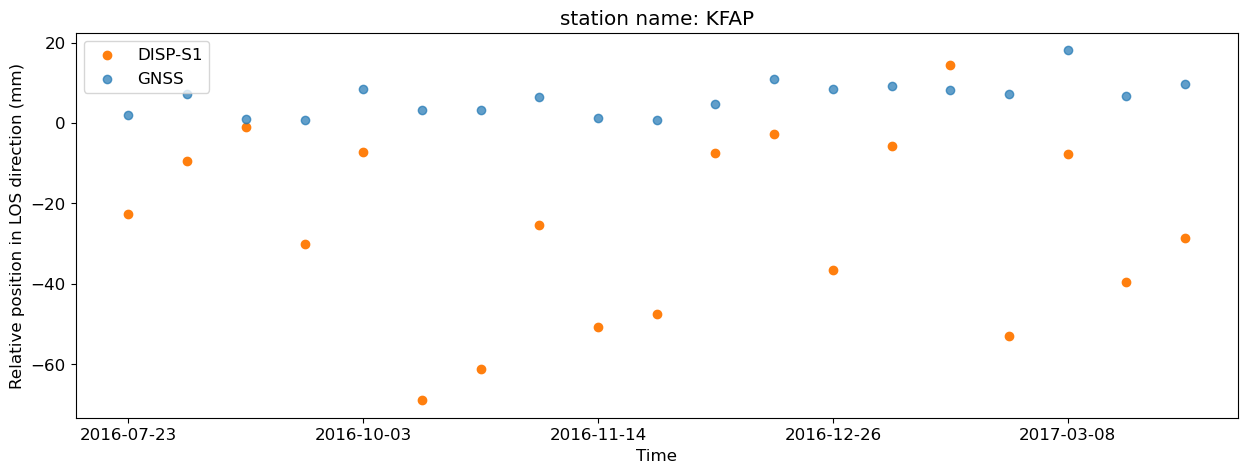

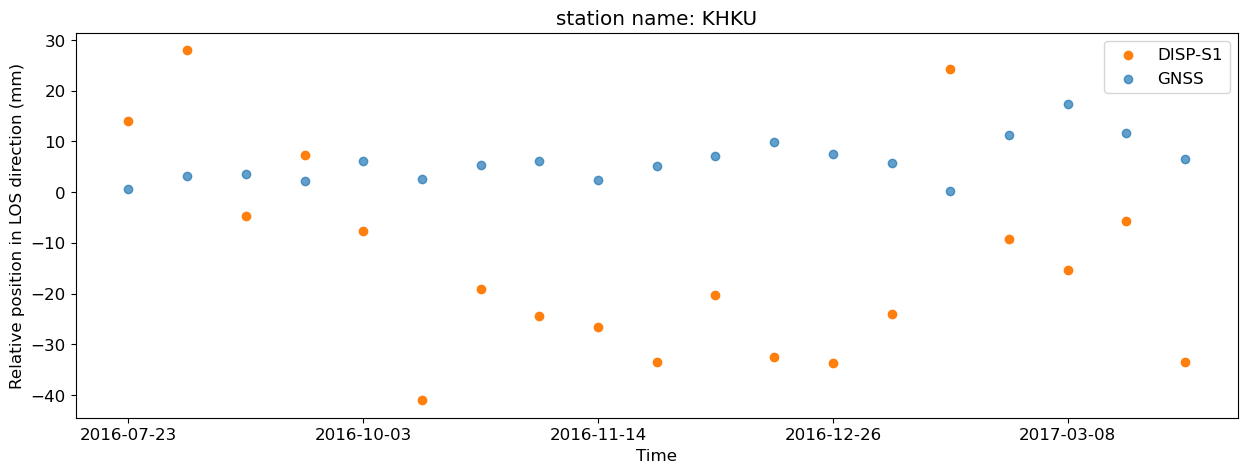

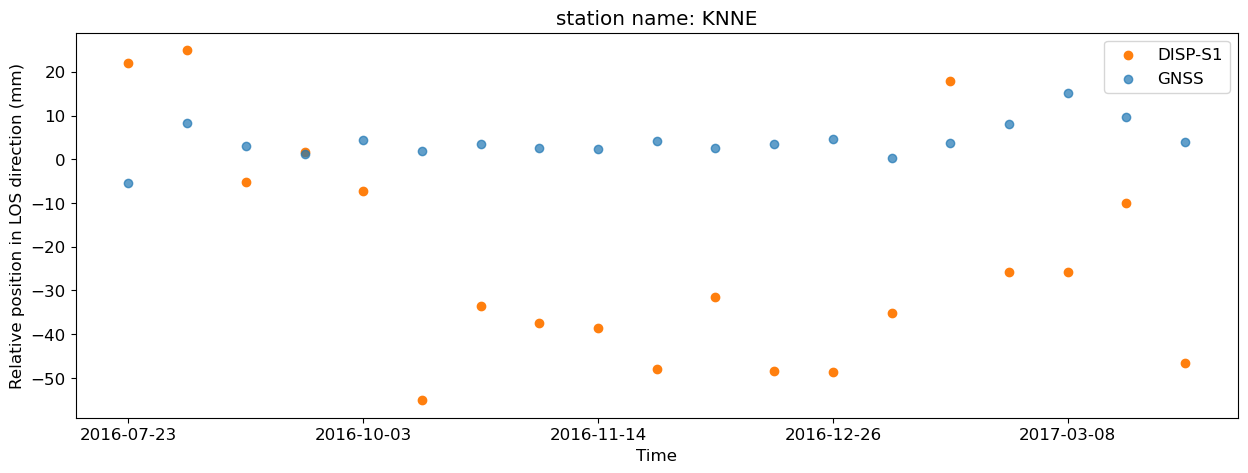

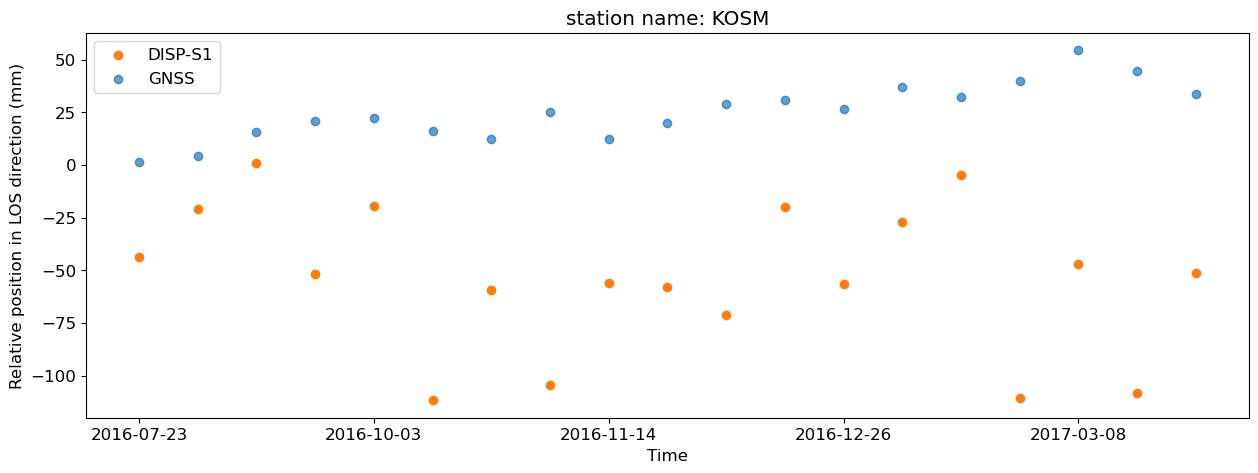

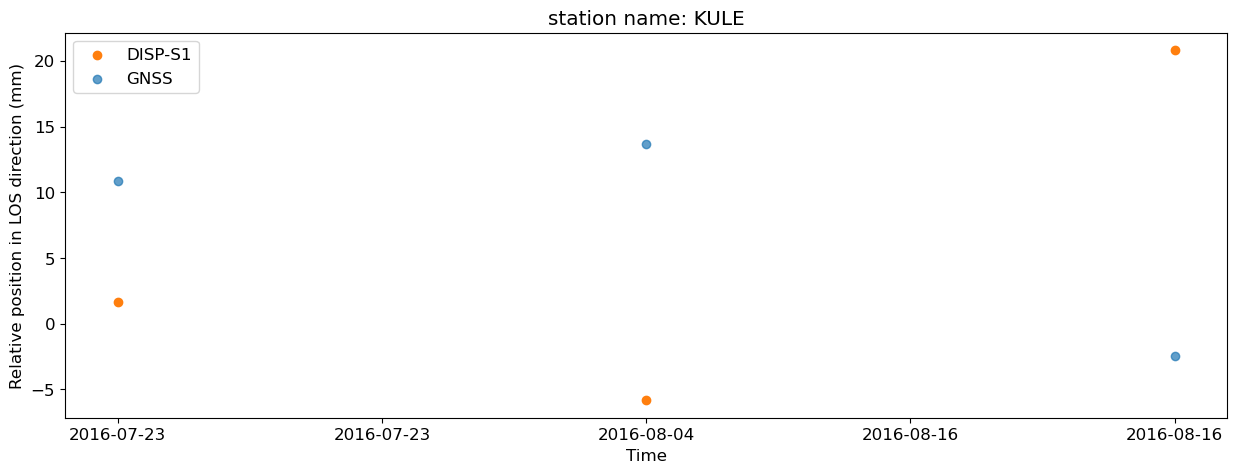

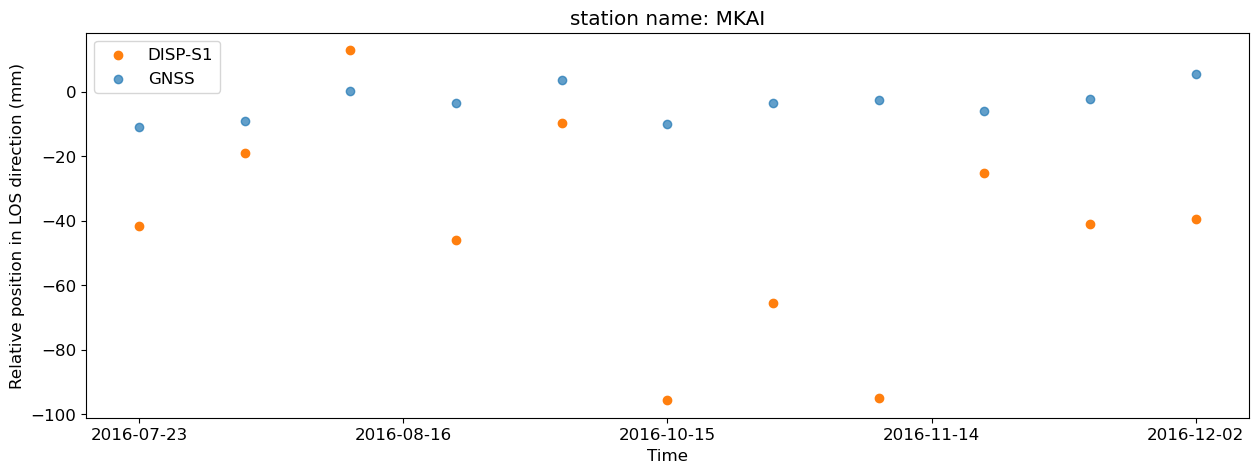

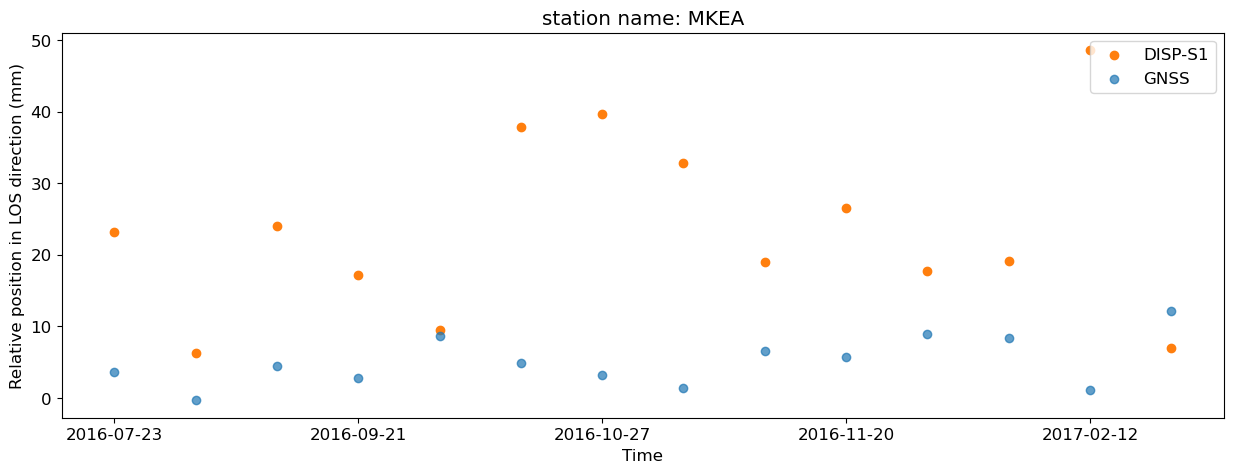

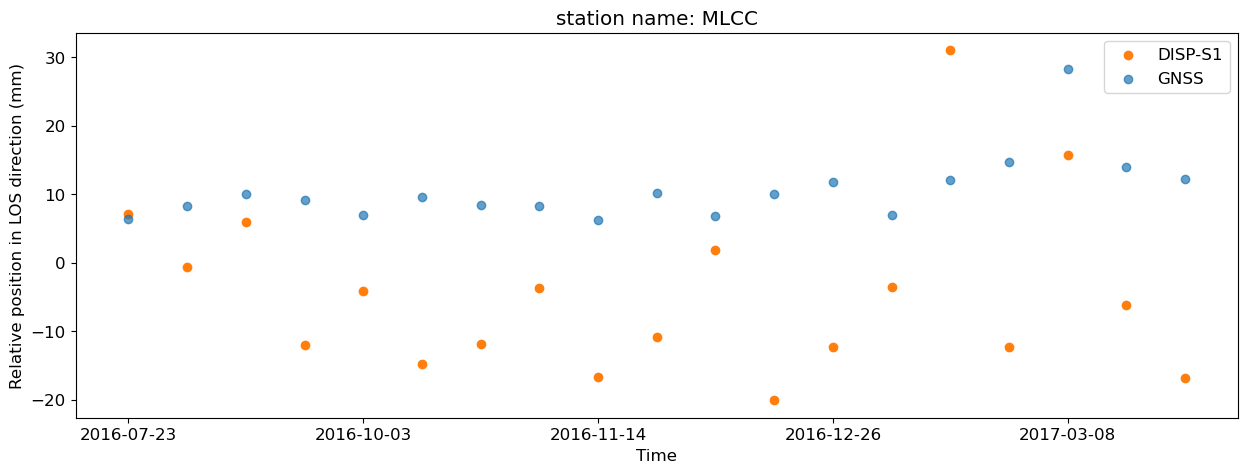

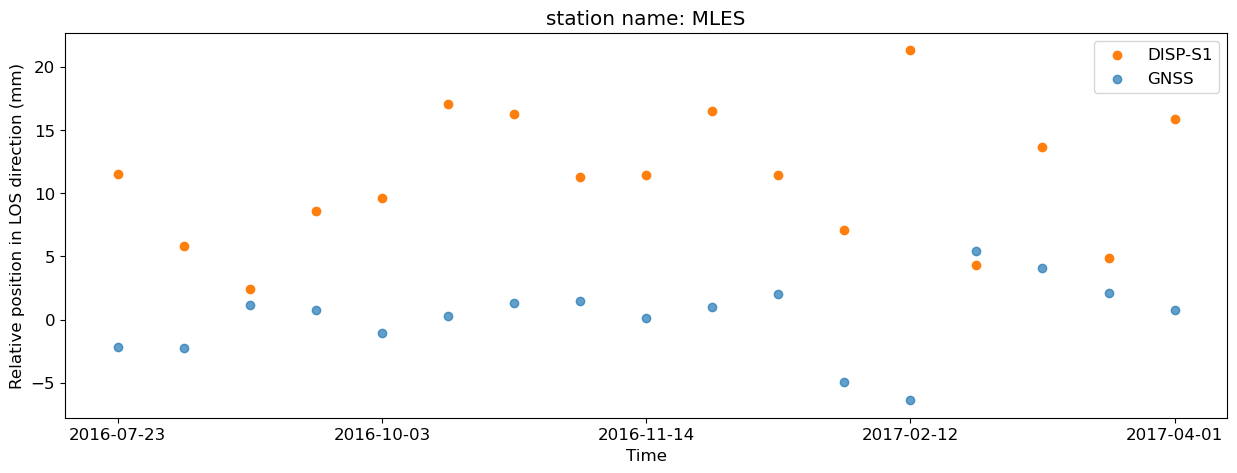

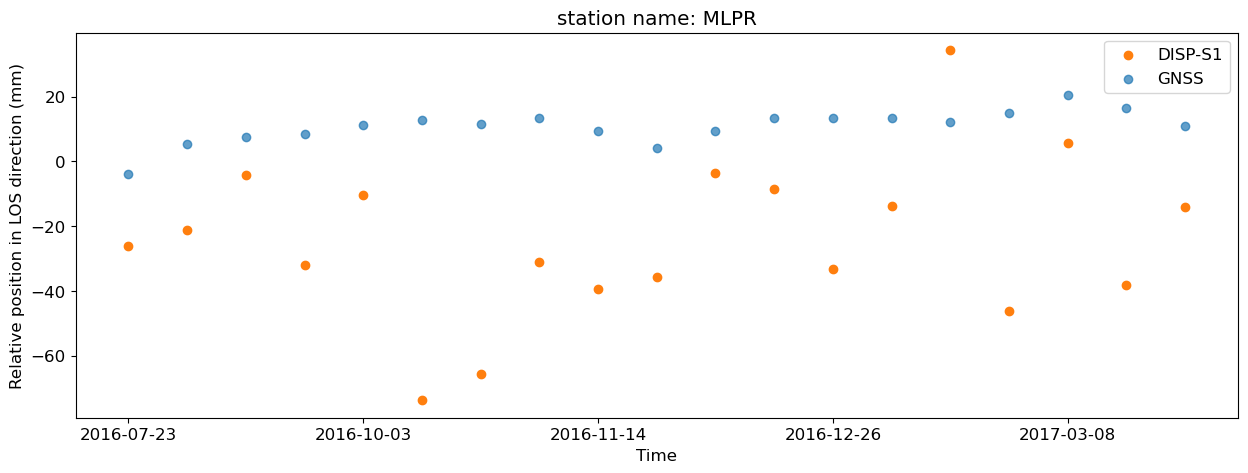

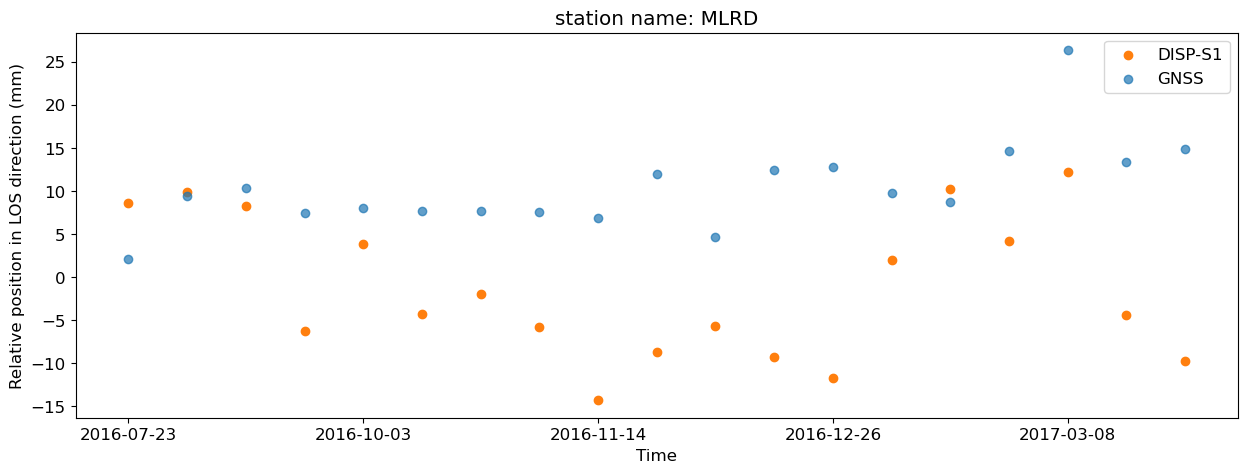

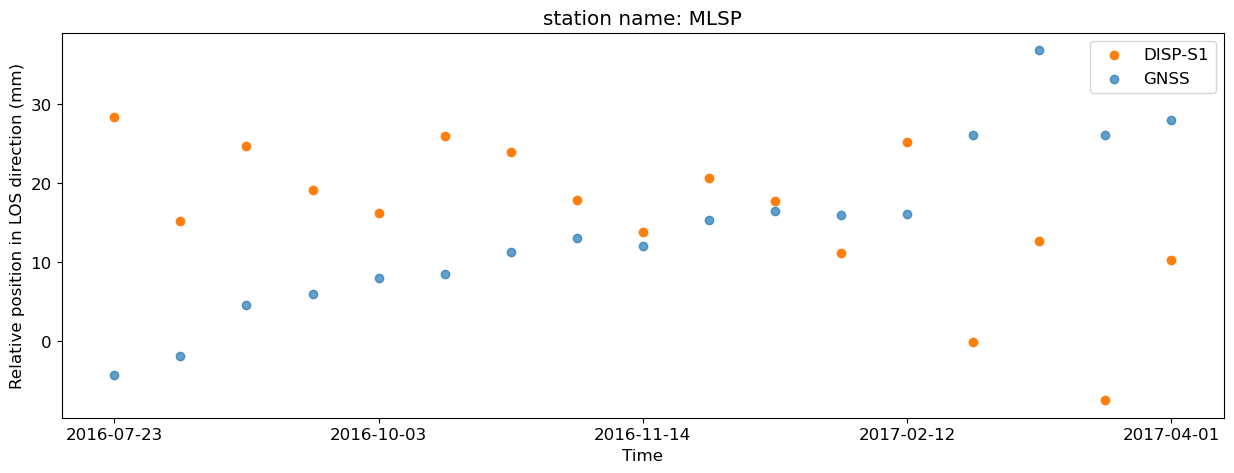

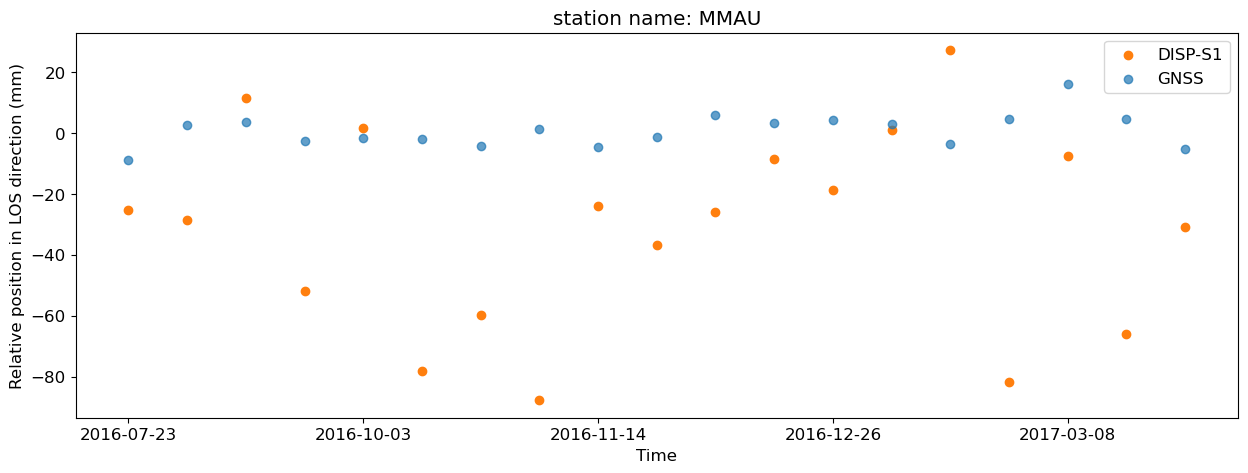

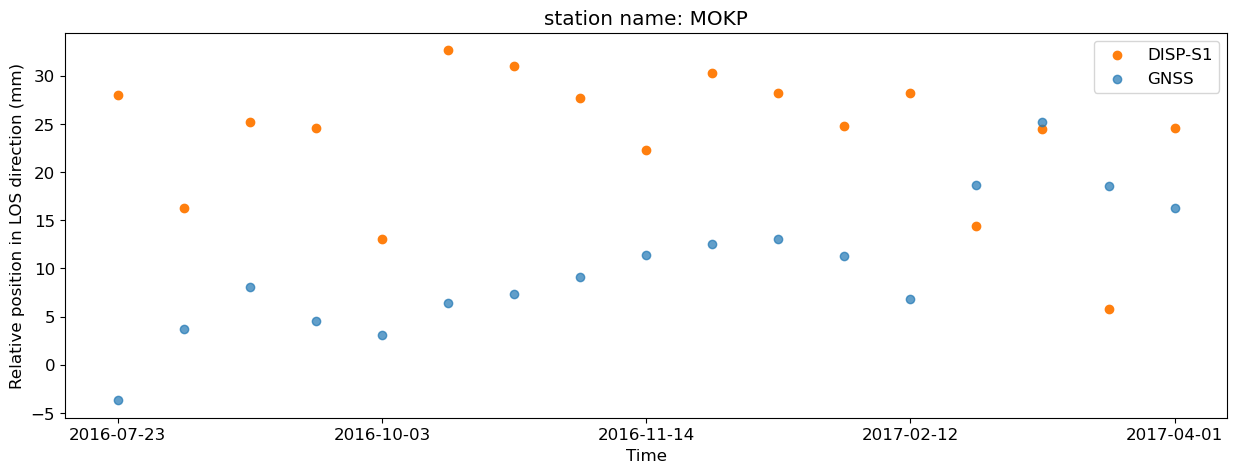

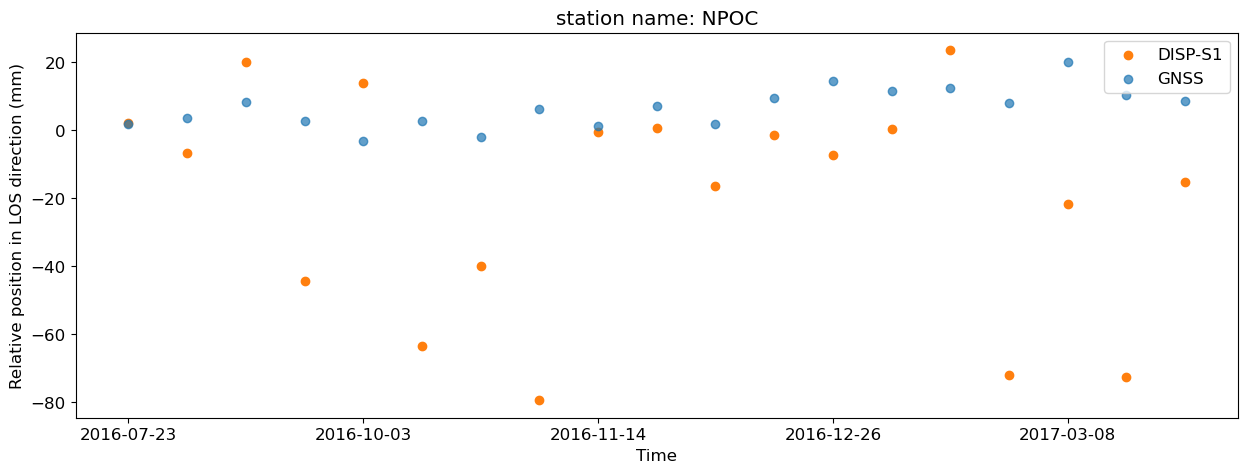

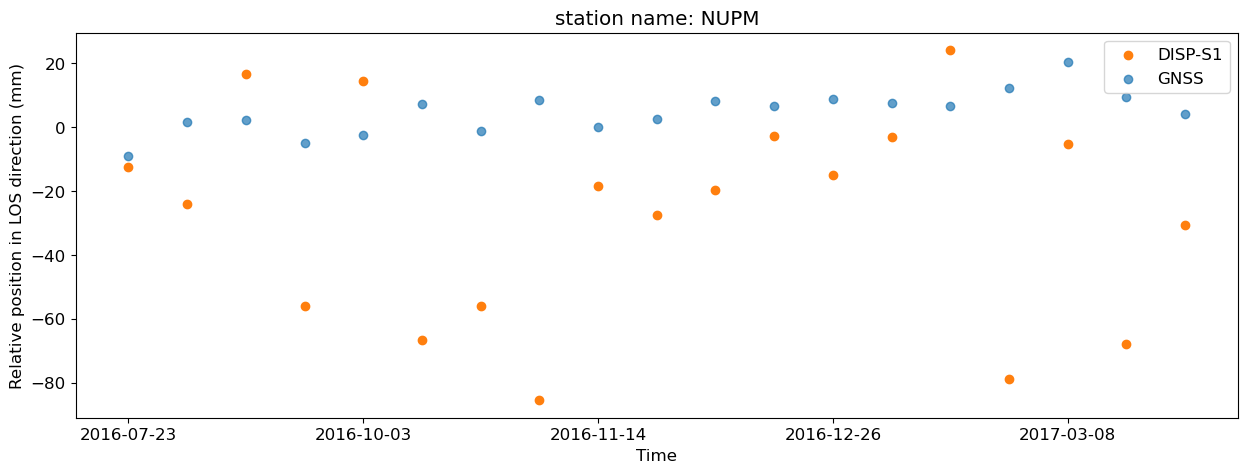

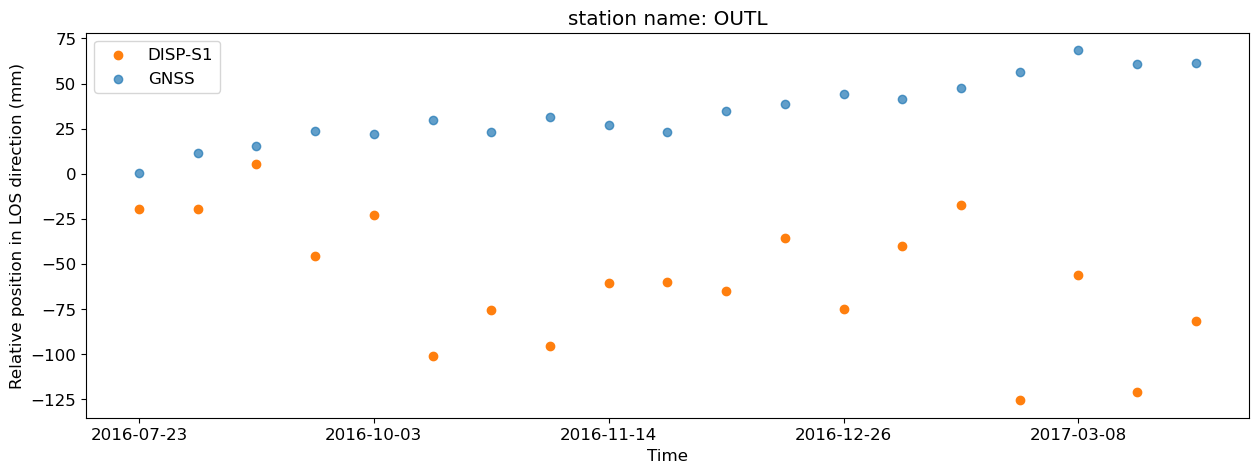

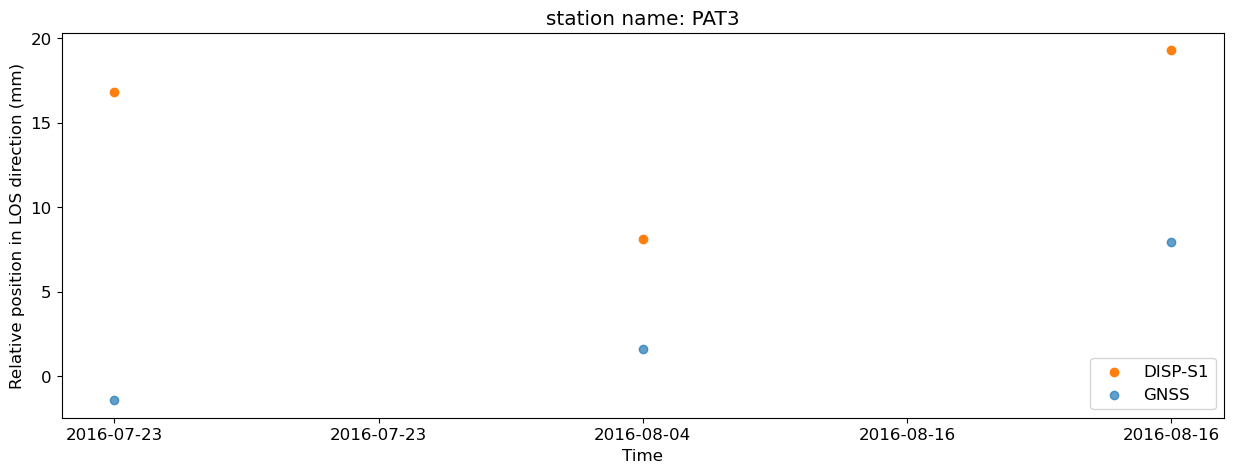

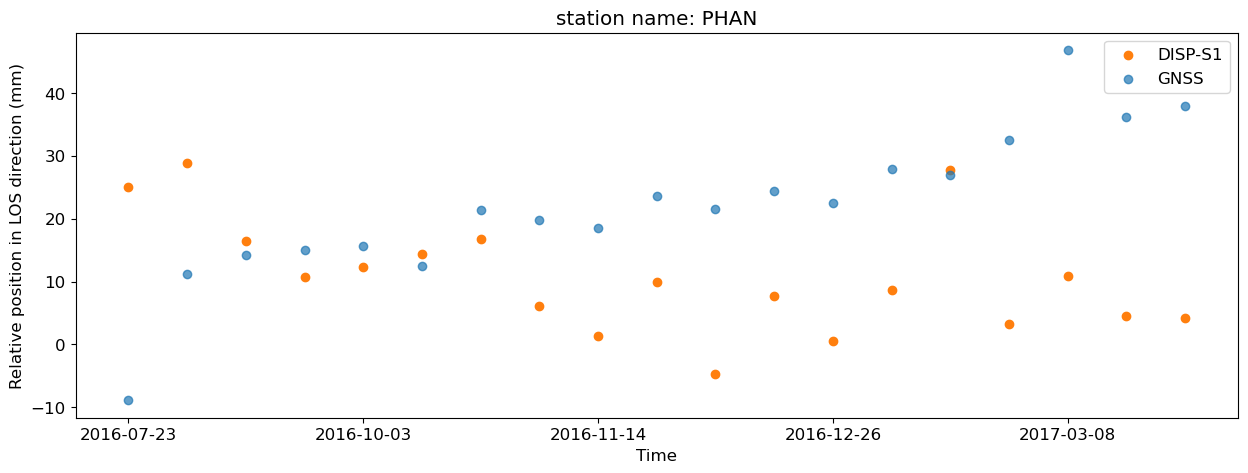

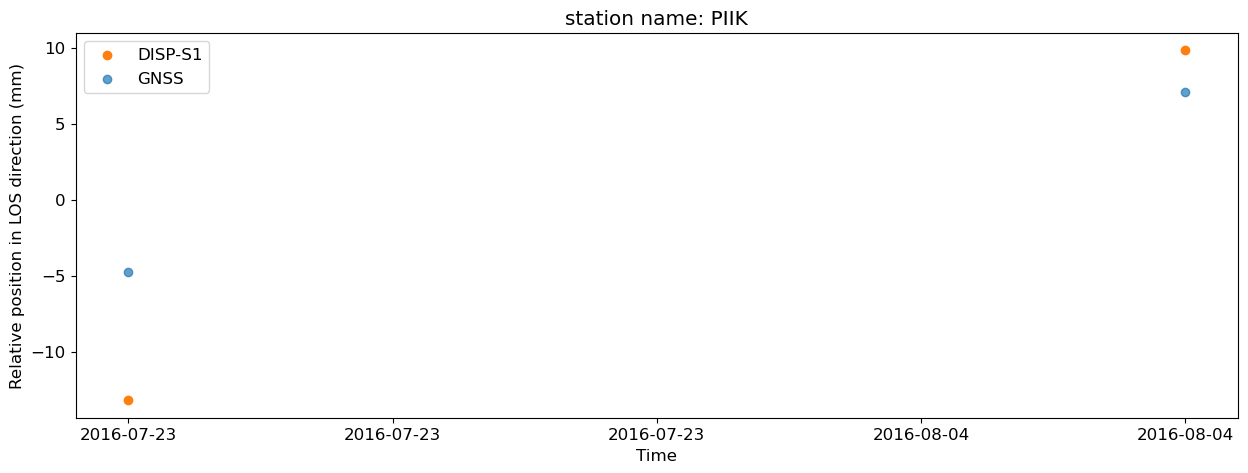

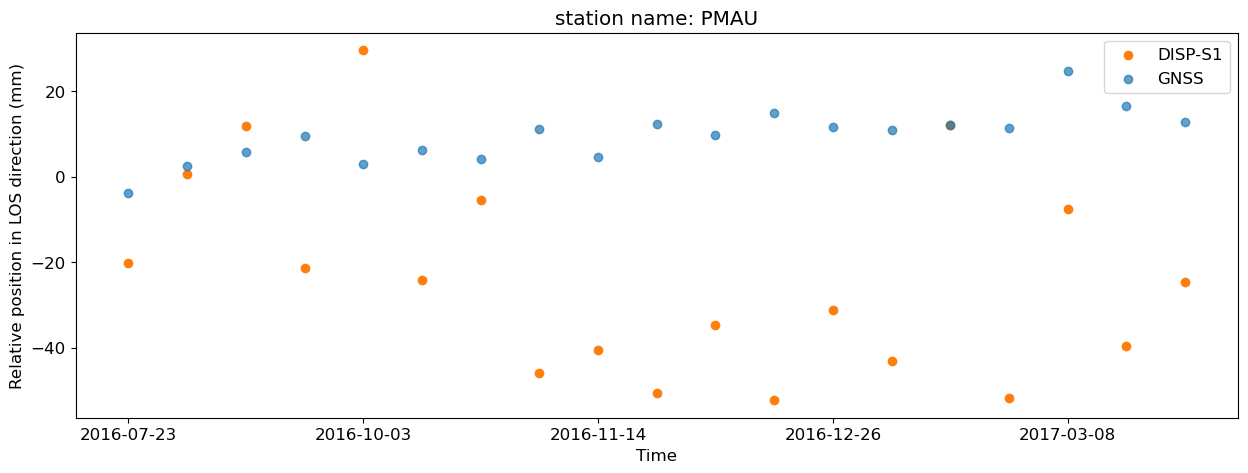

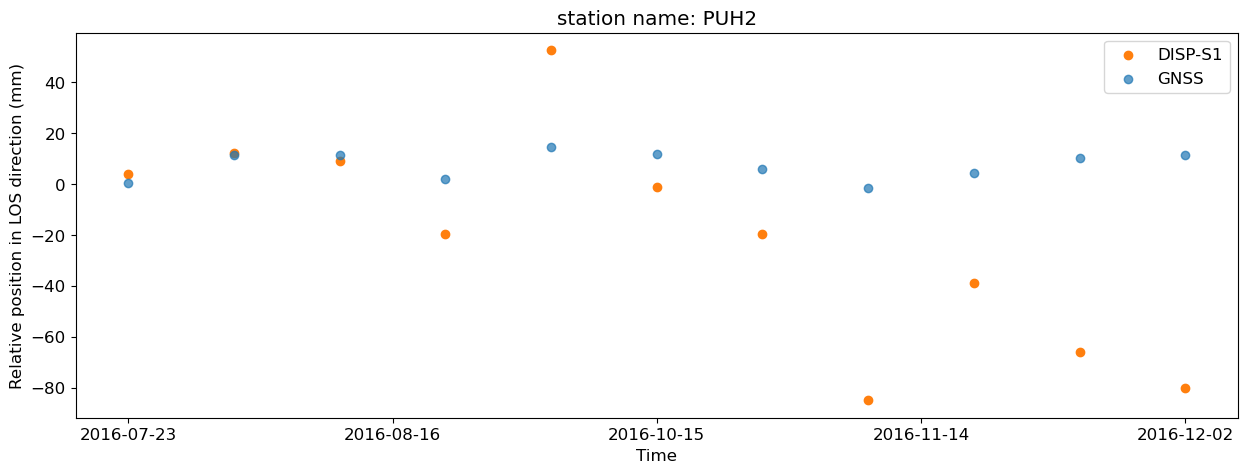

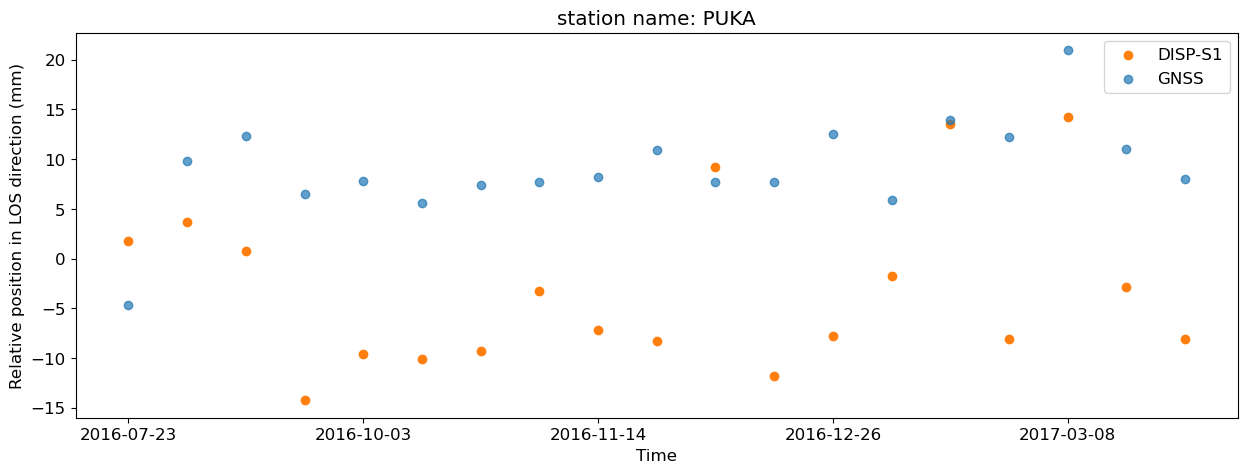

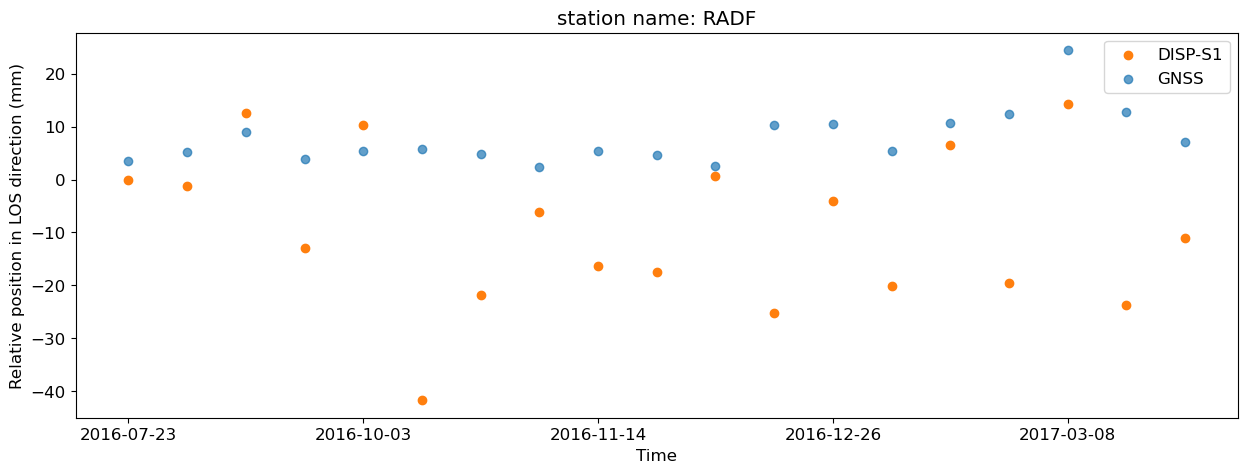

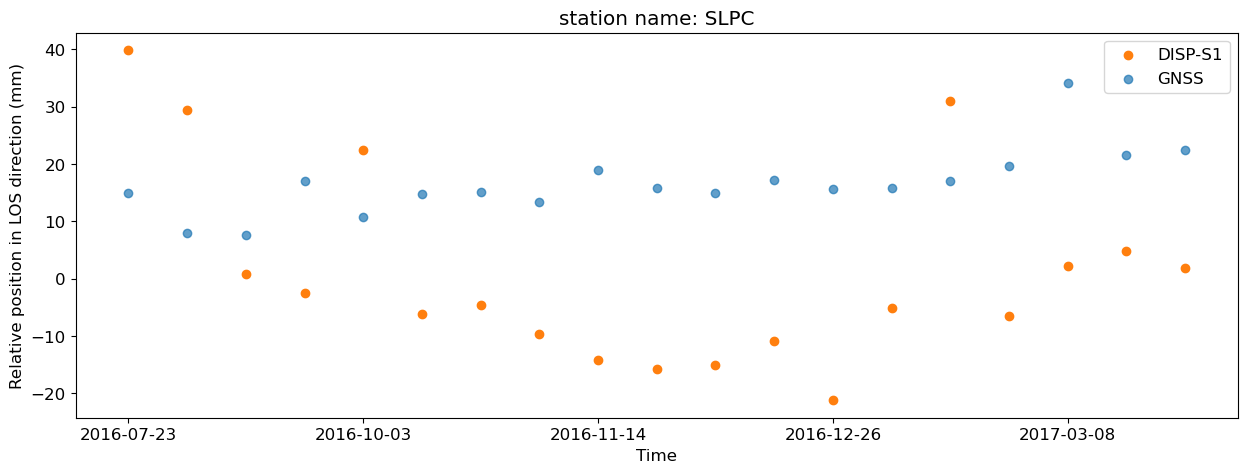

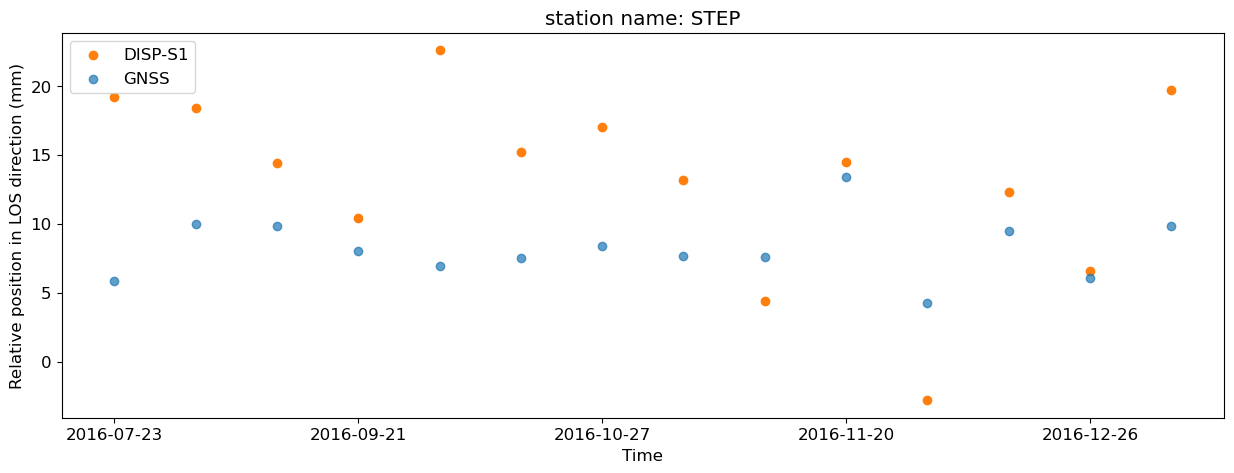

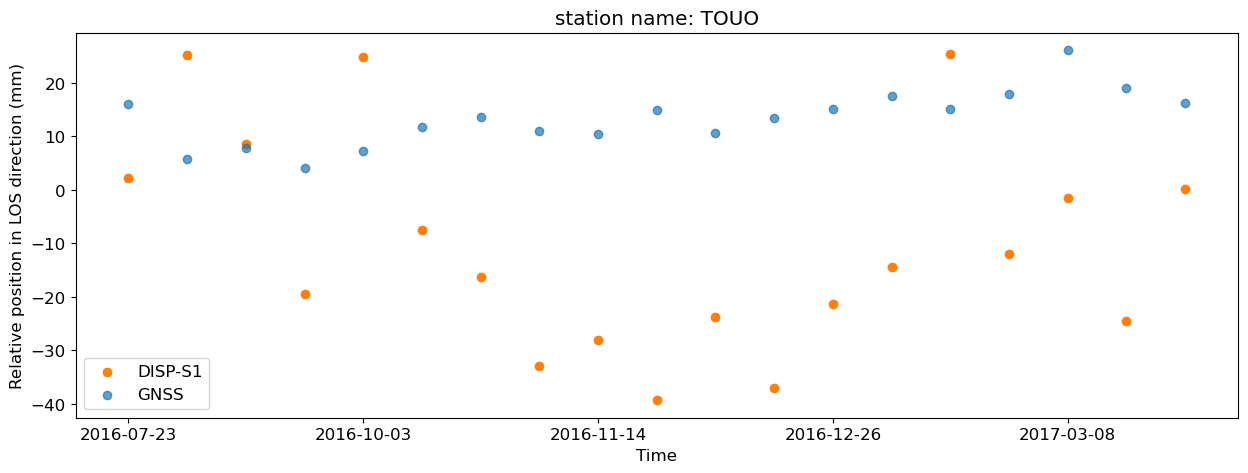

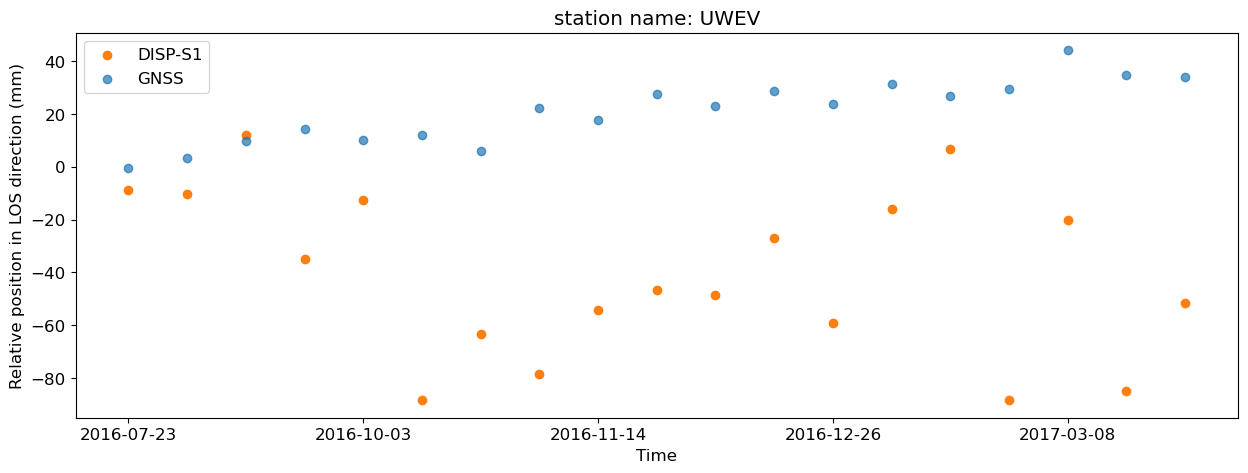

In [63]:
gnss_disp_s1_ts_plots_flag = True   # comparison of time-series gnss and DISP-S1

if gnss_disp_s1_ts_plots_flag:
    gps_ref_site_name = sites_df[sites_df["site"]==site]["gps_ref_site_name"].values[0]
    for stn in site_names:
        date_list = []
        gnss_series = []
        disp_s1_series = []
        for i in dates_index:
            # catch cases where GPS site has been filtered out
            try:
                ref_gnss_dat = displacement.loc[(i,gps_ref_site_name),'gnss_disp']
                ref_disp_s1_dat = displacement.loc[(i,gps_ref_site_name),'disp_s1']
                gnss_series.append(displacement.loc[(i,str(stn)),'gnss_disp'] - ref_gnss_dat)
                disp_s1_series.append(displacement.loc[(i,str(stn)),'disp_s1'] - ref_disp_s1_dat)
                date_list.append(ifgs_date_dt[i,1].strftime('%Y%m%d'))
            except KeyError:
                pass

        # only plot for cases where GPS site has not been filtered out
        if date_list != [] and gnss_series != [] and disp_s1_series != []:
            dt_date_list = [dt.strptime(date, '%Y%m%d').strftime('%Y-%m-%d') for date in date_list]
            # plot station TS
            fig, ax = plt.subplots(figsize=(15, 5))
            ax.set_title(f"station name: {stn}")
            ax.scatter(dt_date_list, disp_s1_series, c='#ff7f0e', label="DISP-S1")
            ax.scatter(dt_date_list, gnss_series, c='#1f77b4', label="GNSS", alpha=0.7)
            ax.set_xlabel('Time')
            ax.set_ylabel('Relative position in LOS direction (mm)')
            ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
            ax.legend()
            plt.show()